#This cell is the old way to set up the conda environment with all the dependencies and mpi4py to run mpi-dask.
#Deprecated
module load python
conda create -c conda-forge -n numeraidask1 \
    python=3 dask distributed ipykernel numpy pandas scikit-learn scipy matplotlib umap-learn scikit-learn-extra

source activate numeraidask1   
pip install umap-learn 

pip install umap
pip install tbb
pip install hdbscan
pip install pynndescent
pip install lhsmdu
pip install git+https://github.com/samueljackson92/coranking.git
pip install shap

wget https://bitbucket.org/mpi4py/mpi4py/downloads/mpi4py-3.0.3.tar.gz
tar zxvf mpi4py-3.0.3.tar.gz
cd mpi4py-3.0.3
module swap PrgEnv-intel PrgEnv-gnu
module unload craype-hugepages2M
python setup.py build --mpicc="$(which cc) -shared"
python setup.py install

conda install -c conda-forge --no-deps dask-mpi


#This is the current way to set up the environment.
module load python
conda create --name numeraidask0 --clone lazy-mpi4py
source activate numeraidask0
conda install dask distributed ipykernel numpy pandas scikit-learn scipy matplotlib 
pip install hdbscan
pip install pynndescent
pip install lhsmdu
pip install git+https://github.com/samueljackson92/coranking.git

pip install umap-learn 
pip install umap
pip install scikit-learn-extra
pip install shap
pip install tbb
conda install -c conda-forge --no-deps dask-mpi


python -m ipykernel install --user --name numeraidask0 --display-name NumeraiDask

In [1]:
#Importing depedencies
import pandas as pd
import numpy as np
import datetime
from dask import delayed,compute
from numpy import loadtxt

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import KernelPCA
import hdbscan
from sklearn.ensemble import RandomForestClassifier
import joblib
from joblib import parallel_backend
import itertools
import scipy.stats as st
from sklearn.model_selection import ParameterGrid
from coranking.metrics import trustworthiness as tw
from coranking.metrics import continuity as ct
from coranking.metrics import LCMC as lcmc
import ast
from sklearn.metrics import pairwise_distances_chunked
import dask.array as da
import re
import lhsmdu
from sklearn.neighbors import KNeighborsRegressor
import shap

In [2]:
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import squareform
import scipy.stats as ss
from sklearn.metrics import mutual_info_score
import copy
import dask
from dask.distributed import wait
from sklearn_extra.cluster import KMedoids
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [3]:

#import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten
from keras.layers import Dense

from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LeakyReLU
from keras import optimizers
from keras.layers import Dense, Activation, Dropout 
from keras.layers import AveragePooling1D
from keras.layers import TimeDistributed
from keras.layers import CuDNNLSTM
from keras.layers import LSTM
from keras.layers import Reshape
from keras.constraints import maxnorm
from matplotlib.pyplot import figure
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
from keras import backend as K


from scipy.stats import spearmanr
from scipy.stats import uniform, randint
from random import randrange
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.decomposition import IncrementalPCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
import random
import umap
from sklearn.utils import parallel_backend
import os
import sys
from os.path import join
from keras.utils import to_categorical

KeyboardInterrupt: 



## Load the Numerai Dataset as X and Y Dataset

In [4]:
#Read the csv data with Pandas
train_num = pd.read_csv( "../numerai_training_data.csv")
train_num.head(5)

id   era data_type  feature_intelligence1  \
0  n000315175b67977  era1     train                   0.00   
1  n0014af834a96cdd  era1     train                   0.00   
2  n001c93979ac41d4  era1     train                   0.25   
3  n0034e4143f22a13  era1     train                   1.00   
4  n00679d1a636062f  era1     train                   0.25   

   feature_intelligence2  feature_intelligence3  feature_intelligence4  \
0                   0.50                   0.25                   0.00   
1                   0.00                   0.00                   0.25   
2                   0.50                   0.25                   0.25   
3                   0.00                   0.00                   0.50   
4                   0.25                   0.25                   0.25   

   feature_intelligence5  feature_intelligence6  feature_intelligence7  ...  \
0                    0.5                   0.25                   0.25  ...   
1                    0.5                   0.00                   0.00  ...   
2                    1.0                   0.75                   0.75  ...   
3                    0.5                   0.25                   0.25  ...   
4                    0.0                   0.25                   0.50  ...   

   feature_wisdom38  feature_wisdom39  feature_wisdom40  feature_wisdom41  \
0              1.00              1.00              0.75              0.50   
1              1.00              1.00              0.00              0.00   
2              0.25              0.50              0.00              0.00   
3              1.00              1.00              0.75              0.75   
4              0.75              0.75              0.25              0.50   

   feature_wisdom42  feature_wisdom43  feature_wisdom44  feature_wisdom45  \
0              0.75              0.50              1.00              0.50   
1              0.75              0.25              0.00              0.25   
2              0.50              1.00              0.00              0.25   
3              1.00              1.00              0.75              1.00   
4              0.75              0.00              0.50              0.25   

   feature_wisdom46  target_kazutsugi  
0              0.75              0.75  
1              1.00              0.25  
2              0.75              0.00  
3              1.00              0.00  
4              0.75              0.75  

[5 rows x 314 columns]

In [5]:
#This cleans the data into integer era column and a training data DataFrame
hr_train_num = train_num
hr_train_num['era'] = hr_train_num['era'].map(lambda x: (x.lstrip('era')))
hr_train_num['era'] = hr_train_num['era'].map(lambda x: (int(x)))
num_era = hr_train_num['era']
num_col_names = list(train_num.columns[3:-1])


num_x = hr_train_num.iloc[:, 3:-1]
num_x_nn= pd.concat([num_era, num_x], axis = 1)
#Unsure if eras do anything for predictions
#num_x = pd.concat([hr_train_num['era'], num_x], axis = 1)
num_y = hr_train_num.iloc[:, -1]
num_y_encoded = pd.get_dummies(num_y)
#Sets up the comparison DataFrame for the different dimensionality reduction techniques
redux_race = pd.DataFrame(columns = ['Reduction Technique', 'Spearman Rank Corr by ERA Mean', 'S CI 2.5%','S CI 97.5%','Quartic Mean Error', 'Q CI 2.5%','Q CI 97.5%'])
num_x


feature_intelligence1  feature_intelligence2  feature_intelligence3  \
0                        0.00                   0.50                   0.25   
1                        0.00                   0.00                   0.00   
2                        0.25                   0.50                   0.25   
3                        1.00                   0.00                   0.00   
4                        0.25                   0.25                   0.25   
...                       ...                    ...                    ...   
501803                   0.50                   0.50                   0.25   
501804                   1.00                   0.00                   0.00   
501805                   0.75                   0.50                   0.50   
501806                   0.25                   0.25                   0.25   
501807                   0.75                   0.50                   0.50   

        feature_intelligence4  feature_intelligence5  feature_intelligence6  \
0                        0.00                   0.50                   0.25   
1                        0.25                   0.50                   0.00   
2                        0.25                   1.00                   0.75   
3                        0.50                   0.50                   0.25   
4                        0.25                   0.00                   0.25   
...                       ...                    ...                    ...   
501803                   0.00                   0.00                   0.50   
501804                   1.00                   0.50                   0.75   
501805                   0.50                   0.25                   0.50   
501806                   0.50                   0.00                   1.00   
501807                   0.75                   0.75                   0.00   

        feature_intelligence7  feature_intelligence8  feature_intelligence9  \
0                        0.25                   0.25                   0.75   
1                        0.00                   0.25                   0.50   
2                        0.75                   0.25                   0.00   
3                        0.25                   0.75                   0.25   
4                        0.50                   0.25                   0.25   
...                       ...                    ...                    ...   
501803                   0.75                   0.00                   0.75   
501804                   0.75                   1.00                   0.00   
501805                   0.25                   0.50                   0.25   
501806                   1.00                   0.50                   0.25   
501807                   0.00                   0.75                   0.00   

        feature_intelligence10  ...  feature_wisdom37  feature_wisdom38  \
0                         0.75  ...              1.00              1.00   
1                         0.50  ...              0.75              1.00   
2                         0.25  ...              0.50              0.25   
3                         0.50  ...              0.75              1.00   
4                         0.50  ...              0.50              0.75   
...                        ...  ...               ...               ...   
501803                    0.75  ...              0.75              0.50   
501804                    0.00  ...              1.00              1.00   
501805                    0.25  ...              1.00              1.00   
501806                    0.25  ...              0.50              0.75   
501807                    0.00  ...              0.50              0.50   

        feature_wisdom39  feature_wisdom40  feature_wisdom41  \
0                   1.00              0.75              0.50   
1                   1.00              0.00              0.00   
2                   0.50              0.00              0.00   
3   

In [6]:
# Submissions are scored by spearman correlation
# These are functions used in different parallel functions and hypeparameter tuning.
def score(Y_True, Y_Pred, era):
    """
    Inputs: Y_True (array-like) True targets
            Y_Pred (DataFrame) Predicted targets (should have an era column)
    """
    # Rank-correlation by era
    Y_Pred = pd.DataFrame(Y_Pred, index = Y_True.index)
    Y_Pred = Y_Pred.join(era).dropna()
    ranked_pred = Y_Pred.groupby('era').apply(lambda x: x.rank(pct=True, method="first")).values[:,0]
    x = np.corrcoef(np.ravel(Y_True), ranked_pred)[0,1]
    print(x)
    return x
def quartic_error(y_true, y_pred):
    """
    This function finds the l_4 error to increase the influence of extreme errors, which is important for financial markets. 
    """
    return np.mean((y_true-y_pred)**4)

def kfold_era(num_folds, era):
    """
    This function makes k folds of the data keeping the eras together, as eras are representing a unit of time.
    """
    fold_idx = []
    train = []
    test = []
    num_per_fold = len(np.unique(era))//num_folds
    unique = np.array_split(np.unique(era), num_folds)
    k =0
    for i in unique:
        fold_idx.append(np.asarray([int(i) for i in era[era.isin(i)].index.tolist()]))
        k+=1
    for k in range(num_folds):
        test.append( ( np.asarray(fold_idx[k]).flatten() ) )
        if k ==0:
            train.append(np.concatenate(fold_idx[(k+1):]).flatten() )
        elif k == num_folds-1:
            train.append(np.concatenate(fold_idx[:k]).flatten())
        else:
            train.append( np.concatenate((np.concatenate(fold_idx[:(k)]).flatten(),np.concatenate(fold_idx[(k+1):]).flatten())).flatten() )

    return train, test
# The payout function
def payout(scores):
    """
    The hypothetical payout from Numerai given the Spearman Rank Correlation.
    """
    return ((scores - 0) / .2).clip(lower=-1, upper=1)

def loader(l):
    """
    A helper function for certain functions using Dask,
    """
    lis = [x for x in l]
    return lis
def timer(lis):
    
    i = 0
    while(True):
            complete = 0
            error = 0
            pending = 0
            for m in lis:
                if m == 0:
                    complete+=1
                elif m.status == 'finished':
                    complete += 1
                elif m.status == 'error':
                    error+=1
                else:
                    pending +=1
            print(complete, error,pending)
            if pending ==0:
                break
            print(i*5)
            i+=1
            time.sleep(5)
    return

In [7]:
def LHS_RandomizedSearch(num_samples,params ):

    new = []
    x = ((np.array(lhsmdu.sample(len(params[0].keys()),num_samples))))
   
    parameter_grid = np.array(ParameterGrid(params))
    t = np.array([len(p) for p in params[0].values()])
    for i in range(len(t)):
        if t[i] == 1:
            new.append(np.zeros(len(x[i])))
        else:
            new.append(np.floor(x[i]*t[i]))
    idx = np.array(new).astype(int)
    k = (parameter_grid.reshape([len(p) for p in params[0].values()]))
    parameters = []
    for l in range(num_samples):
        j = 0
        for i in (idx[:,l]):
        
            if j == 0:
                ph = k[i]

            else:

                ph = ph[i]
            j+=1
        parameters.append(ph)
    return parameters


Train-Test Split

In [8]:
train_era_idx = num_era[num_era==90].index[0]
train_era_idx

360490

In [9]:
num_train_x = num_x.iloc[:train_era_idx, :].to_numpy()
num_test_x = num_x.iloc[train_era_idx:, :].to_numpy()
num_train_y = num_y.iloc[:train_era_idx]
num_train_era = num_era.iloc[:train_era_idx]
num_test_era = num_era.iloc[train_era_idx:].reset_index(drop=True)
num_test_y = num_y.iloc[train_era_idx:].reset_index(drop=True)
num_cluster_x = num_x.sample(n = 2000).to_numpy()

cd $SCRATCH
module load python
source activate numeraidask0

export DASK_WORK_STEALING=TRUE
export OMP_NUM_THREADS=1
salloc \
    -N 32 \
    -c  16 \
    -t 4:00:00 \
    -C haswell \
    -q interactive \
    --mem 0 \
    srun -u python -u \
        $(which dask-mpi) \
            --scheduler-file=scheduler.json \
            --dashboard-address=0 \
            --memory-limit=0 \
            --no-nanny \
            --local-directory=/tmp 
  

In [33]:
import os

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar 
from dask.distributed import progress
import dask.array as da


import time
os.environ["OMP_NUM_THREADS"] = "1"
scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [81]:
client = Client(threads_per_worker=63, scheduler_file=scheduler_file)
workers = np.array(list(client.get_worker_logs().keys()))
client.restart()




<Client: 'tcp://10.128.0.10:44365' processes=110 threads=1760>

In [15]:
def MDA(trainx, trainy,eras, client,num_workers, features =None):
    rf =RandomForestRegressor(criterion= 'mse',random_state = 42,n_estimators = 250, max_depth= 14,verbose = 0,max_features= 5, n_jobs=-1, max_leaf_nodes= 138, max_samples = .8, min_samples_leaf = 21, min_samples_split = 2 )
    spearm = dict()
    qme = dict()
    names = pd.DataFrame(trainx).columns.values
    kftrain,kftest= kfold_era(60,eras)
    
    spearman = []
    np_num_train_x = trainx
    np_num_train_y = trainy
    n_classes = 5
    fold_num = 1
    accs = []
    shuff_accs = []
    models = []
    test_indices = []
    
    k_folds =60
    h = num_workers/k_folds
    if features != None:
        clustDict = features.values()
    else:
        clustDict = np.array_split(np.arange(trainx.shape[1]),trainx.shape[1])
    # Maybe make an array of pretrained models, waiting for each to train in parallel, then find the differences afterward?
    def score(Y_True, Y_Pred, era):
        """
        Inputs: Y_True (array-like) True targets
                Y_Pred (DataFrame) Predicted targets (should have an era column)
        """
        # Rank-correlation by era
        Y_Pred = pd.DataFrame(Y_Pred, index = Y_True.index)
        Y_Pred = Y_Pred.join(era).dropna()
        print(Y_Pred)
        ranked_pred = Y_Pred.groupby('era').apply(lambda x: x.rank(pct=True, method="first")).values[:,0]

        return np.corrcoef(np.ravel(Y_True), ranked_pred)[0,1]
    def predict_score(model, x_test, y_test, era):
        pred = model.predict(x_test)
        s = score(y_test,pred,era)
        return s
    
    def predict_mean(model, x_test, y_test, acc,era):
        def score(Y_True, Y_Pred, era):
            """
            Inputs: Y_True (array-like) True targets
                    Y_Pred (DataFrame) Predicted targets (should have an era column)
            """
            # Rank-correlation by era
            Y_Pred = pd.DataFrame(Y_Pred, index = Y_True.index)
            Y_Pred = Y_Pred.join(era).dropna()
            ranked_pred = Y_Pred.groupby('era').apply(lambda x: x.rank(pct=True, method="first")).values[:,0]
            return np.corrcoef(np.ravel(Y_True), ranked_pred)[0,1]
        def perc(acc, shuff):
            return [(acc-shuff)/(1-shuff)]
  
        scores=[]
    
        s_ = []
        #X_t = np.array([t[fold] for t in x_test])
        i = 0
        for t in x_test:
            pred = model[i].predict(t.result())
            s = score(y_test[i],pred, era[i])
          
            scores.append(perc(acc[i],s))
         
            i+=1
        return np.mean(scores)
              
    def perc(acc, shuff):
            return [(acc-shuff)/(1-shuff)]
              
   
    #get auc for per k-fold set
    work_id = 0
    x_s = []
    y_s = []
    x_t = []
    y_t = []
    e = []
    for train_idx, test_idx in zip(kftrain,kftest):
        
        x_train = np_num_train_x[train_idx]
        y_train= np_num_train_y[train_idx]
        x_s.append(client.scatter(x_train,workers = workers[int(work_id%num_workers)].tolist(), broadcast =True))
        y_s.append(client.scatter(y_train, workers = workers[int(work_id%num_workers)].tolist(), broadcast =True))
        test_indices.append(test_idx)
        e.append(eras.iloc[test_idx])
        work_id += 1
    work_id = 0
    for i in range(len(x_s)):
        models.append(client.submit(rf.fit, x_s[i], y_s[i], workers = workers[int(work_id%num_workers)].tolist()))
        work_id += 1
    timer(models)
    models = client.gather(models, direct =True)
    i = 0
    accs = []
    train_x = []
    train_y = []
    while i < len(models):
        start = int(i%num_workers)
        end = int((i+len(clustDict))%num_workers)
        if start>=end:
            w = np.append(workers[np.arange(start, num_workers)],workers[np.arange(1, end)]).tolist()
        else:
            w = (workers[int(i%num_workers):int((i+len(clustDict))%num_workers)]).tolist()
        print(w)
        val_x=(client.scatter(np_num_train_x[test_indices[i]],workers = w, broadcast =True))
        val_y = client.scatter(np_num_train_y[test_indices[i]],workers = w, broadcast =True)
        era = client.scatter(e[i], workers = w, broadcast = True)
        #m = client.scatter(models[i], workers = workers, broadcast = True)
        m = models[i]
        accs.append(client.submit(predict_score, m,val_x ,val_y,era, workers = w))
        i+=1
    i= 0
    X_ts = []  
    vals = []
    Y_ts =[]

    for t in test_indices:
        futs_x = []
        futs_y = []
        for v in clustDict:
            X_t = np_num_train_x[t].copy()
            for col in v: 
                np.random.shuffle(X_t[:, col])
            futs_x.append(X_t)

        Y_ts.append(client.scatter(np_num_train_y[t], broadcast = True, direct = True ))
        X_ts.append(client.scatter(futs_x, direct = True))
        i+=1
        vals.append(v) 
#     for v in clustDict:
#         futs_x = []
#         futs_y = []
#         for t in test_indices:
#             X_t = np_num_train_x[t].copy()
#             for col in v: 
#                 np.random.shuffle(X_t[:, col])
#             futs_x.append(X_t)
#             futs_y.append(np_num_train_y[t])
#         if i ==0:
#             Y_ts =(client.scatter(futs_y, broadcast = True, direct = True ))
#         X_ts.append(client.scatter(futs_x, workers = [1+i%num_workers], direct = True))
#         i+=1
#         vals.append(v)
        i =0
        accs = client.gather(accs, direct = True)
        #for i in range(len(models)):
        k= 0
        items = []
    for v in clustDict:

        X_t = np.array([t[k] for t in X_ts])
        spearm[str(names[v])] = (client.submit(predict_mean, models,X_t,Y_ts, accs,e,workers = workers[int((k)%num_workers)].tolist()))
        k += 1
    spearm = client.gather(spearm,direct = True)

    print ("Features sorted by their score:")
    sc = (sorted([(score, feat) for
                  feat, score in spearm.items()], reverse= True))

    return sc

In [76]:
def tune_dask_kfold(model,train_x, train_y,eras,  client, num_workers, params, samples,fit_params ={}):
    k_folds = 5
    
    val = pd.DataFrame()
    scores = pd.DataFrame()


    parameters = LHS_RandomizedSearch(samples,params)
    i = 0
    w = 0
    h = num_workers//k_folds
    kftrain,kftest= kfold_era(5, eras)
    models = []
    test_indices = []
    train_indices = []
    x_s = []
    y_s = []
    x_t = []
    y_t = []
    e_t = []
    for train_idx, test_idx in zip(kftrain,kftest):
            x_train, x_test = train_x[train_idx], train_x[test_idx]
            y_train, y_test = train_y[train_idx], train_y[test_idx]
            print(np.arange(int(w%num_workers), int(h+w%num_workers)))
            work_id = workers[np.arange(int(w%num_workers), int(h+w%num_workers))].tolist()
            x_s.append(client.scatter(x_train,workers = work_id, broadcast =True))
            y_s.append(client.scatter(y_train, workers = work_id, broadcast =True))
            x_t.append(client.scatter(x_test,workers = work_id, broadcast =True))
            y_t.append(client.scatter(y_test,workers = work_id, broadcast =True))
            e_t.append(client.scatter(eras.iloc[test_idx],workers = work_id, broadcast = True))
            w += h
            test_indices.append(test_idx)
            train_indices.append(train_idx)
    print('Done Scattering')
    w = 0
    k = 0
    def fit_predict(model,x_train, y_train, x_test, y_test, era):
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        s = score(y_test,pred,era)
        qme = quartic_error(y_test,pred)
        return s,qme
    for values in parameters:        
        rf = model(**values)
        print(values)
        for f in range(k_folds):
            future = client.submit(fit_predict,rf, x_s[f],y_s[f],x_t[f], y_t[f],e_t[f], workers = workers[int(k%num_workers)].tolist())
            models.append(future)
            
       
            k+=1
        
        v = pd.DataFrame(values, index =[0])
        val = val.append(v, ignore_index=True)
        i += 1
        if i>=samples:
            break
    
#     errored = [ind for ind, x in enumerate(models) if x.status == 'error']
#     for e in errored:
#         idx = train_indices[e]
#         x = train_x[idx]
#         y = train_y[idx]
#         parameters = val.iloc[e//k_folds,:].to_dict()
#         print(parameters)
#         rf = model(**parameters)
#         models[e] = client.submit(rf.fit, client.scatter(x), client.scatter(y))
        
    timer(models)
    results = client.gather(models, direct =True)
#     models = np.split(np.array(results), len(results)//1000)
#     complete = []
#     for m in models:
#         f = client.submit(loader,m.tolist())
#         future = f.result()
#         print(future)
#         complete.append(future)
    
    s = [x[0] for x in results]
    q = [x[1] for x in results]
    scores = np.split(np.array(s), samples)
    qmes = np.split(np.array(q), samples)
    w = 0
    k = 1
   
#     for m in models:
#         s = np.array([])

#         for i in range(k_folds):
            
#             score_ = client.submit(m[i].predict,x_t[i], workers = [k+w%num_workers])
#             s = np.append(s,client.submit(score,y_t[i], score_.result(), workers = [k+w%num_workers]))
#             w += h
#         k = k%h
#         k+=1     
#         scores.append(s)

#     x_t = client.gather(x_t)
#     y_t = client.gather(y_t)
#     for m in models:
#         s = np.array([])

#         for i in range(k_folds):
            
#             score_ = m[i].predict(x_t[i]) 
#             s = np.append(s,score(y_t[i], score_.result()))
#             w += h
#         k = k%h
#         k+=1     
#         scores.append(s)
   
#     pred_futs = []
#     for m in models:
#         pred_fut = np.array([])

#         for i in range(k_folds):
            
#             p = client.submit(m[i].predict,x_t[i]) 
#             pred_fut = np.append(pred_fut, p)
#         pred_futs.append(pred_fut) 
#     for p in pred_futs:
#         timer(p)
#     y_t = client.gather(y_t)
#     for p in pred_futs:
#         result = []
#         for i in range(k_folds):
#             s = score(y_t[i], p[i].result())
#             result.append(s)
#         scores.append(result)
# #    scores = [np.array([x.result() for x in s]) for s in scores]
#     scores = np.array(scores)
    scores = np.mean(scores, axis = 1)
    qmes = np.mean(qmes, axis = 1)
    s = pd.DataFrame({'Spearman Rank Corr by ERA Mean': scores,'Quartic Mean Error': qmes})
    final = pd.concat([val, s], axis =1)
    return final

In [17]:
def kfold_dask(n_splits, train_x, train_y,eras,client, model,num_workers, i=0):
    train,test=kfold_era(n_splits, eras)
    models = []
    test_indices = []
    def fit_predict(model,x_train, y_train, x_test, y_test,eras):
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        s = score(y_test,pred, eras)
        qme = quartic_error(y_test, pred)
        return s,qme
    for train_idx, test_idx in zip(train,test):
        x_train, x_test = train_x[train_idx], train_x[test_idx]
        y_train, y_test = train_y[train_idx], train_y[test_idx]
        e_test = eras.iloc[test_idx]
        x= client.scatter(x_train, workers = workers[int(i %num_workers)].tolist(), direct = True)
        y = client.scatter(y_train,workers = workers[int(i %num_workers)].tolist(), direct = True)
        x_t = client.scatter(x_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
        y_t = client.scatter(y_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
        e_t = client.scatter(e_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
        models.append(client.submit(fit_predict, model,x, y,x_t,y_t,e_t, workers = workers[int(i %num_workers)].tolist()))
        i += 1
        test_indices.append(test_idx)
    timer(models)
    scores = client.gather(models, direct = True)
    s = [x[0] for x in scores]
    q = [x[1] for x in scores]
    return (np.mean(s),st.t.interval(0.95, len(s)-1, loc=np.mean(s), scale=st.sem(s))),(np.mean(q),st.t.interval(0.95, len(q)-1, loc=np.mean(q), scale=st.sem(q)))


In [75]:
def tune_reduction_dask(redux, model,train_x,train_y,eras, client, params, samples,num_workers,fit_params ={}):

    reductions = []
    val = pd.DataFrame()
    models= []
    parameters =LHS_RandomizedSearch(samples,parameters)
    kftrain,kftest= kfold_era(5, eras)
    vectorized = client.scatter(np.vectorize(int)(train_y*4), broadcast = True)

    i = 0
    folds = train_y
    train_x = client.scatter(train_x, broadcast = True)

    if train_y is not None:
        train_y = client.scatter(train_y, broadcast = True)
  
    def fit_predict(model,x_train, y_train, x_test, y_test,eras):
        model.fit(x_train,y_train)
        s = score(y_test,model.predict(x_test),eras)
        return s
       
    means = []
    cis = []
    for values in parameters:
        if train_y is None:
            rf = redux(**values)
            fut = client.submit(rf.fit_transform, train_x, workers = workers[i%num_workers].tolist())
            reductions.append(fut)
        else:

             rf = redux(**values)
             fut = client.submit(rf.fit_transform, train_x,vectorized , workers = workers[i%num_workers].tolist())
             reductions.append(fut)
       
        v = pd.DataFrame(values, index =[0])
        val = val.append(v, ignore_index=True)
        i += 1
        if i>=samples:
            break
        
    timer(reductions)
    print('gathered')
    reductions = client.gather(reductions, direct = True)
    train_y = client.gather(train_y, direct = True)
    i = 0
    for r in reductions:
        for train_idx, test_idx in zip(kftrain,kftest):
                x_train, x_test = r[train_idx], r[test_idx]
                y_train, y_test = train_y[train_idx], train_y[test_idx]
                e_test = eras.iloc[test_idx]
                x= client.scatter(x_train, workers = workers[int(i %num_workers)].tolist(), direct = True)
                y = client.scatter(y_train,workers =  workers[int(i %num_workers)].tolist(), direct = True)
                x_t = client.scatter(x_test, workers=  workers[int(i%num_workers)].tolist(), direct = True)
                y_t = client.scatter(y_test, workers=  workers[int(i%num_workers)].tolist(), direct = True)
                e_t = client.scatter(e_test, workers=  workers[int(i%num_workers)].tolist(), direct = True)
                models.append(client.submit(fit_predict, model,x, y,x_t,y_t,e_t,workers = workers[int(i %num_workers)].tolist()))
                i += 1
        
#     scores = []
#     w=1
#     trainy = train_y[:300000]
#     trainy = client.scatter(trainy, workers = np.arange(1,len(reductions)).tolist())
#     for r in reductions:
#         trainx = r[:300000]
#         trainx = client.scatter(trainx, workers = [w])
#         models.append(client.submit( model.fit, trainx, trainy,workers = [w]))
#     timer(models)
#     models = client.gather(models, direct = True)
#     i = 0
#     while i < len(models):

#         s = score(train_y[300000:], models[i].predict(reductions[i][300000:]))
#         scores.append(s)
#         i += 1
#     i = 0
#     redux_race = pd.DataFrame(columns = ['Random Forest AUC-ROC', 'Confidence Interval 2.5%','Confidence Interval 97.5%'])

#     for r in reduction:
#         rf_mean, rf_ci = kfold_dask(5, r, train_y, client, model, i)
#         i +=1
#         redux_race = redux_race.append({'Random Forest AUC-ROC': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
    timer(models)
    gathered = client.gather(models, direct = True)
    models = np.split(np.array(gathered), samples)
    rf_means = np.mean(models, axis = 1)
    s = pd.DataFrame({'Spearman Rank Corr by ERA Mean': rf_means})
    final = pd.concat([val, s], axis =1)
    return final


In [19]:
def tune_redux_corank_dask(redux,num_splits,train_x,train_y,train_era, min_k,max_k, client, params, samples,num_workers,fit_params ={}):

    reductions = []
    val = pd.DataFrame()
    results = []
    parameters =LHS_RandomizedSearch(samples,params)

    vectorized = client.scatter(np.vectorize(int)(train_y*4), broadcast = True)

    i = 0
    folds = train_y
    t_x = client.scatter(train_x, broadcast = True)
    
    if train_y is not None:
        train_y = client.scatter(train_y, broadcast = True)
    
    
    #CREDIT TO samueljackson92
    
    def corank_score(untrans, trans, train_y, era):

        def coranking_matrix(high_data, low_data):
            """Generate a co-ranking matrix from two data frames of high and low
            dimensional data.
            :param high_data: DataFrame containing the higher dimensional data.
            :param low_data: DataFrame containing the lower dimensional data.
            :returns: the co-ranking matrix of the two data sets.
            """
            
            n, m = high_data.shape
            high_distance= pairwise_distances_chunked(high_data, n_jobs =-1)
            low_distance= pairwise_distances_chunked(low_data, n_jobs =-1)
            i =0
            for h_d,l_d in zip(high_distance,low_distance):
                if i == 0: 
                    h = h_d
                    l = l_d
                else:
                    np.append(h,h_d)
                    np.append(l,l_d)
                i += 1
     
            h = h.argsort(axis = 1).argsort(axis = 1)
            l = l.argsort(axis = 1).argsort(axis = 1)
            Q, xedges, yedges = np.histogram2d(h.flatten(),
                                               l.flatten(),
                                               bins=n)
            #print(Q[1:4])
            Q = Q[1:, 1:]  # remove rankings which correspond to themselves
            return Q
        knn = KNeighborsRegressor(n_neighbors = 1, metric = 'minkowski',weights = 'distance', p =2, n_jobs = -1)
        train, test = kfold_era(5, era)
        scores = []
        for tr, te in zip(train, test):
            knn.fit(trans[tr], train_y[tr])
            pred = knn.predict(trans[te])
            s = score(train_y[te], pred, era[te])
            scores.append(s)
        print(scores)
        high  = np.array_split(untrans, num_splits)
        low =  np.array_split(trans, num_splits )
        local_cont = []
        contin = []
        trustworth = [] 
        i = 0
        for h,l in zip(high,low):
            Q = coranking_matrix(h, l)
            print('Q Calculated', i)
            
            LCMC =lcmc(Q, min_k = min_k, max_k =  max_k)
    #             cont = ct(Q, min_k = min_k , max_k =  max_k)
    #             trust = tw(Q, min_k = min_k , max_k =  max_k)
            
            local_cont.append(LCMC)
    #             contin.append(cont)
    #             trustworth.append(trust) 
            i +=1
        #return {'LCMC':np.mean(local_cont,axis = 1),'Continuity':np.mean(contin,axis = 1),'Trust': np.mean(trustworth,axis = 1)}
        return np.mean(np.array(local_cont), axis = 0), np.mean(scores)

    means = []
    cis = []
    for values in parameters:
#         if train_y is None:
        rf = redux(**values)
        fut = client.submit(rf.fit_transform, t_x, workers = workers[int(i%num_workers)].tolist())
        reductions.append(fut)
#         else:
#              rf = redux(**values)
#              fut = client.submit(rf.fit_transform, t_x,vectorized , workers = [1+i%num_workers])
#              reductions.append(fut)
       
        v = pd.DataFrame(values, index =[0])
        val = val.append(v, ignore_index=True)
        i += 1
        if i>=samples:
            break
        
    timer(reductions)
    print('gathered')
    reductions = client.gather(reductions, direct = True)
    train_y = client.gather(train_y, direct = True)
    i = 0
    transformed = []
    for r in reductions:
        transformed.append(client.scatter(r, workers = workers[int(i%num_workers)].tolist(), direct = True))
        i += 1
    i =0
    untrans = client.scatter(train_x, broadcast = True, direct = True)
    era = client.scatter(train_era, broadcast = True, direct = True)
    print(transformed)
    for t in transformed:
       
        print(t)
        print(i)
        print('submitted')
        fut = (client.submit(corank_score, untrans,t, train_y, era,workers = workers[int(i%num_workers)].tolist()))
        results.append(fut)
        i += 1

#     scores = []
#     w=1
#     trainy = train_y[:300000]
#     trainy = client.scatter(trainy, workers = np.arange(1,len(reductions)).tolist())
#     for r in reductions:
#         trainx = r[:300000]
#         trainx = client.scatter(trainx, workers = [w])
#         models.append(client.submit( model.fit, trainx, trainy,workers = [w]))
#     timer(models)
#     models = client.gather(models, direct = True)
#     i = 0
#     while i < len(models):

#         s = score(train_y[300000:], models[i].predict(reductions[i][300000:]))
#         scores.append(s)
#         i += 1
#     i = 0
#     redux_race = pd.DataFrame(columns = ['Random Forest AUC-ROC', 'Confidence Interval 2.5%','Confidence Interval 97.5%'])

#     for r in reduction:
#         rf_mean, rf_ci = kfold_dask(5, r, train_y, client, model, i)
#         i +=1
#         redux_race = redux_race.append({'Random Forest AUC-ROC': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
    timer(results)
    gathered = client.gather(results, direct = True)
    i=0
#    means = pd.DataFrame(columns = ['LCMC Mean', 'Continuity Mean','Trust'])
#     for g in gathered:
#         graph = pd.DataFrame(g)
#         avg={ s:sum(g[k]) / len(g[k]) for s,k in zip(['LCMC Mean', 'Continuity Mean','Trust'],g)}
#         means.append(avg, ignore_index = True)
#         graph.plot(xlim = (min_k,max_k),y = ['LCMC','Continuity','Trust'], title= '    '.join(val.iloc[i].to_string(header= False).split('\n')) )
#         i+=1
    means= pd.DataFrame(columns = ['LCMC Max','KNN Score', 'K'])
    graphs = dict({})
    for g in gathered:
        graph = pd.DataFrame({'LCMC': g[0],'K': np.arange(len(g[0]))})
        avg=pd.DataFrame({'LCMC Max':[np.max(g[0])],'KNN Score':g[1], 'K': [np.argmax(g[0])+min_k]})
        means  = means.append(avg, ignore_index = True)
        #graph.plot(x = 'K',y = 'LCMC', title= '    '.join(val.iloc[i].to_string(header= False).split('\n')) )
        params = '    '.join(val.iloc[i].to_string(header= False).split('\n'))
        params = re.sub("\s\s+", "|", params)
        graphs[params] = graph
        i+=1
    s = means
    final = pd.concat([val, s], axis =1)
    return final, graphs


In [20]:
def tune_redux_corank_dask(redux,num_splits,train_x,train_y,min_k,max_k, client, params, samples,num_workers,fit_params ={}):

    reductions = []
    val = pd.DataFrame()
    results = []
    parameters =LHS_RandomizedSearch(samples,params)

    vectorized = client.scatter(np.vectorize(int)(train_y*4), broadcast = True)

    i = 0
    folds = train_y
    t_x = client.scatter(train_x, broadcast = True)
    
    if train_y is not None:
        train_y = client.scatter(train_y, broadcast = True)
    
    
    #CREDIT TO samueljackson92
    
    def corank_score(untrans, trans):

        def coranking_matrix(high_data, low_data):
            """Generate a co-ranking matrix from two data frames of high and low
            dimensional data.
            :param high_data: DataFrame containing the higher dimensional data.
            :param low_data: DataFrame containing the lower dimensional data.
            :returns: the co-ranking matrix of the two data sets.
            """
            
            n, m = high_data.shape
            high_distance= pairwise_distances_chunked(high_data, n_jobs =-1)
            low_distance= pairwise_distances_chunked(low_data, n_jobs =-1)
            i =0
            for h_d,l_d in zip(high_distance,low_distance):
                if i == 0: 
                    h = h_d
                    l = l_d
                else:
                    h = np.append(h,h_d)
                    l = np.append(l,l_d)
                i += 1
     
            h = h.argsort(axis = 1).argsort(axis = 1)
            l = l.argsort(axis = 1).argsort(axis = 1)
            Q, xedges, yedges = np.histogram2d(h.flatten(),
                                               l.flatten(),
                                               bins=n)
            #print(Q[1:4])
            Q = Q[1:, 1:]  # remove rankings which correspond to themselves
            return Q
        high  = np.array_split(untrans, num_splits)
        low =  np.array_split(trans, num_splits )
        local_cont = []
        contin = []
        trustworth = [] 
        i = 0
        for h,l in zip(high,low):
            Q = coranking_matrix(h, l)
            print('Q Calculated', i)
            
            LCMC =lcmc(Q, min_k = min_k, max_k =  max_k)
    #             cont = ct(Q, min_k = min_k , max_k =  max_k)
    #             trust = tw(Q, min_k = min_k , max_k =  max_k)
            
            local_cont.append(LCMC)
    #             contin.append(cont)
    #             trustworth.append(trust) 
            i +=1
        #return {'LCMC':np.mean(local_cont,axis = 1),'Continuity':np.mean(contin,axis = 1),'Trust': np.mean(trustworth,axis = 1)}
        return np.mean(np.array(local_cont), axis = 0)

    means = []
    cis = []
    for values in parameters:
#         if train_y is None:
        rf = redux(**values)
        fut = client.submit(rf.fit_transform, t_x, workers = workers[int(i%num_workers)].tolist())
        reductions.append(fut)
#         else:
#              rf = redux(**values)
#              fut = client.submit(rf.fit_transform, t_x,vectorized , workers = [1+i%num_workers])
#              reductions.append(fut)
       
        v = pd.DataFrame(values, index =[0])
        val = val.append(v, ignore_index=True)
        i += 1
        if i>=samples:
            break
        
    timer(reductions)
    print('gathered')
    reductions = client.gather(reductions, direct = True)
    train_y = client.gather(train_y, direct = True)
    i = 0
    transformed = []
    for r in reductions:
        transformed.append(client.scatter(r, workers = workers[int(i%num_workers)].tolist(), direct = True))
        i += 1
    i =0
    untrans = client.scatter(train_x, broadcast = True, direct = True)
    print(transformed)
    for t in transformed:
       
        print(t)
        print(i)
        print('submitted')
        fut = (client.submit(corank_score, untrans,t, workers = workers[int(i%num_workers)].tolist()))
        results.append(fut)
        i += 1

#     scores = []
#     w=1
#     trainy = train_y[:300000]
#     trainy = client.scatter(trainy, workers = np.arange(1,len(reductions)).tolist())
#     for r in reductions:
#         trainx = r[:300000]
#         trainx = client.scatter(trainx, workers = [w])
#         models.append(client.submit( model.fit, trainx, trainy,workers = [w]))
#     timer(models)
#     models = client.gather(models, direct = True)
#     i = 0
#     while i < len(models):

#         s = score(train_y[300000:], models[i].predict(reductions[i][300000:]))
#         scores.append(s)
#         i += 1
#     i = 0
#     redux_race = pd.DataFrame(columns = ['Random Forest AUC-ROC', 'Confidence Interval 2.5%','Confidence Interval 97.5%'])

#     for r in reduction:
#         rf_mean, rf_ci = kfold_dask(5, r, train_y, client, model, i)
#         i +=1
#         redux_race = redux_race.append({'Random Forest AUC-ROC': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
    timer(results)
    gathered = client.gather(results, direct = True)
    i=0
#    means = pd.DataFrame(columns = ['LCMC Mean', 'Continuity Mean','Trust'])
#     for g in gathered:
#         graph = pd.DataFrame(g)
#         avg={ s:sum(g[k]) / len(g[k]) for s,k in zip(['LCMC Mean', 'Continuity Mean','Trust'],g)}
#         means.append(avg, ignore_index = True)
#         graph.plot(xlim = (min_k,max_k),y = ['LCMC','Continuity','Trust'], title= '    '.join(val.iloc[i].to_string(header= False).split('\n')) )
#         i+=1
    means = pd.DataFrame(columns = ['LCMC Max', 'K'])
    graphs = dict({})
    for g in gathered:
        graph = pd.DataFrame({'LCMC': g, 'K': np.arange(len(g))})
        avg=pd.DataFrame({'LCMC Max':[np.max(g)], 'K': [np.argmax(g)+min_k]})
        means  = means.append(avg, ignore_index = True)
        #graph.plot(x = 'K',y = 'LCMC', title= '    '.join(val.iloc[i].to_string(header= False).split('\n')) )
        params = '    '.join(val.iloc[i].to_string(header= False).split('\n'))
        params = re.sub("\s\s+", "|", params)
        graphs[params] = graph
        i+=1
    s = means
    final = pd.concat([val, s], axis =1)
    return final, graphs


In [21]:
def tune_redux_fit_dask(redux, model,fit_x, fit_y,train_x, client, params, samples,fit_params ={},train_y= None):

    reductions = []
    val = pd.DataFrame()
    models= []
    parameters = list(ParameterGrid(params))
    random.shuffle(parameters)
    parameters = parameters
    i = 0
    for values in parameters:
        print(values)
        if train_y is None:
            rf = redux(**values)
            reductions.append(client.submit(rf.fit, client.scatter(fit_x),**fit_params))
        else:
            rf = redux(**values)
            reductions.append(client.submit(rf.fit, client.scatter(fit_x), client.scatter(fit_y),**fit_params))

        v = pd.DataFrame(values, index =[0])
        val = val.append(v, ignore_index=True)
        i += 1
        if i>=samples:
            break
    while(True):
        complete = 0
        error = 0
        pending = 0
        for r in reductions:
            if r == 0:
                complete+=1
            elif r.status == 'finished':
                complete += 1
            elif r.status == 'error':
                error+=1
            else:
                pending +=1
        print(complete, error,pending)
        if pending ==0:
            break
        time.sleep(10)
    reductions = [x.result() if x != None and x!= 0 else x for x in reductions]
    scores = []
    
    transformed = []
    for r in reductions:

        transformed.append(client.submit(r.transform,client.scatter(train_x[:9000])))
    while(True):
        complete = 0
        error = 0
        pending = 0
        for t in transformed:
            if t == 0:
                complete+=1
            elif t.status == 'finished':
                complete += 1
            elif t.status == 'error':
                error+=1
            else:
                pending +=1
        print(complete, error,pending)
        if pending ==0:
            break
        time.sleep(10)
    transformed = [x.result() if x != None and x!= 0 else x for x in transformed]    
    print('transformed')
    for t in transformed:
        
        models.append(client.submit(model.fit, client.scatter(t),client.scatter(train_y[:9000])))
        
    while(True):
        complete = 0
        error = 0
        pending = 0
        for m in models:
            if m == 0:
                complete+=1
            elif m.status == 'finished':
                complete += 1
            elif m.status == 'error':
                error+=1
            else:
                pending +=1
        print(complete, error,pending)
        if pending ==0:
            break
        time.sleep(30)    
    models = [x.result() if x != None and x!= 0 else x for x in models]
    i = 0
    while i < len(models):

        s = score(train_y[9000:], models[i].predict(reductions[i].transform(train_x[9000:])))
        scores.append(s)
        i += 1

    s = pd.DataFrame({'Spearman Rank Corr by ERA Mean': scores})
    final = pd.concat([val, s], axis =1)
    return final

In [51]:

# def MDA_tune(X,Y,eras, n_components, feat_score, client, num_workers):
#     futs = []
#     models = []
    
#     k = 0
#     def fit_predict(model,x_train, y_train, x_test, y_test,eras):
#         model.fit(x_train,y_train)
#         pred = model.predict(x_test)
#         s = score(y_test,pred, eras)
#         qme = quartic_error(y_test, pred)
#         return s,qme
#     rf = RandomForestRegressor(criterion= 'mse',
#                                random_state = 32,
#                                n_estimators = 600,
#                                max_depth= 50,
#                                verbose = 0,
#                                max_features= "log2", 
#                                n_jobs=-1, 
#                                max_leaf_nodes= 200,
#                                max_samples = .5, 
#                                min_samples_leaf = 29, 
#                                min_samples_split = 6 )
   
#     for i in range(1,n_components):
#         idx = (feat_score.sort_values('Score', ascending = False).iloc[:i,:]).Feature
    
#         #rel_col = self.feat_score[self.feat_score['Score'] > float(MDA_mean + 2*MDA_std)].Feature
#         rel_col = idx.apply(lambda x: int(x.strip('[]').split("' '")[0]))
#         MDA_Dataset =  pd.DataFrame(X).iloc[:,rel_col].to_numpy()

#         futs.append((MDA_Dataset))
#         k+=1
#     k = 0
#     for i in range(2,n_components):
#         models.append(kfold_dask(10,futs[k], Y, eras, client, rf, num_workers))
#         print(k)

#         k+=1
#     models = models
#     return models


In [74]:

def MDA_tune(X,Y,eras, n_components, feat_score, client, num_workers):
    futs = []
    models = []
    
    k = 0
    def fit_predict(model,x_train, y_train, x_test, y_test,eras):
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        s = score(y_test,pred, eras)
        qme = quartic_error(y_test, pred)
        return s,qme
    rf = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 600,
                               max_depth= 50,
                               verbose = 0,
                               max_features= "log2", 
                               n_jobs=-1, 
                               max_leaf_nodes= 200,
                               #max_samples = .5, 
                               min_samples_leaf = 29, 
                               min_samples_split = 6 )
    train,test=kfold_era(5, eras)
    i=0
    train_x_fut = []
    train_y_fut = []
    test_x_fut = []
    test_y_fut = []
    era_fut = []
    for n in range(1,n_components):
        idx = feat_score.sort_values('Score', ascending = False).iloc[:n,0]
        print(idx)
        #rel_col = self.feat_score[self.feat_score['Score'] > float(MDA_mean + 2*MDA_std)].Feature
        rel_col = idx.apply(lambda x: int(x.strip('[]').split("' '")[0]))

        selected =  pd.DataFrame(X).iloc[:,rel_col].to_numpy()

        for train_idx, test_idx in zip(train,test):
            x_train, x_test = selected[train_idx], selected[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]
            e_test = eras.iloc[test_idx]
            x= client.scatter(x_train, workers = workers[int(i %num_workers)].tolist(), direct = True)
            y = client.scatter(y_train,workers = workers[int(i %num_workers)].tolist(), direct = True)
            x_t = client.scatter(x_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            y_t = client.scatter(y_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            e_t = client.scatter(e_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            train_x_fut.append(x)
            train_y_fut.append(y)
            test_x_fut.append(x_t)
            test_y_fut.append(y_t)
            era_fut.append(e_t)
            
            i += 1
     
    for k in range(len(train_x_fut)):
        models.append(client.submit(fit_predict, rf,train_x_fut[k], train_y_fut[k],test_x_fut[k],test_y_fut[k],era_fut[k], workers = workers[int(k %num_workers)].tolist()))

    
    timer(models)
    scores = client.gather(models, direct = True)
    s = np.array([x[0] for x in scores])
    q = np.array([x[1] for x in scores])
    s = np.split(s,len(s)/5)
    q = np.split(q,len(q)/5)
    mean_s = np.mean(s, axis = 1)
    mean_q = np.mean(q, axis = 1)     
    return mean_s, mean_q

In [68]:

def SHAP_tune(X,Y,eras, n_components, feat_score, client, num_workers):
    futs = []
    models = []
    
    k = 0
    def fit_predict(model,x_train, y_train, x_test, y_test,eras):
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        s = score(y_test,pred, eras)
        qme = quartic_error(y_test, pred)
        return s,qme
    rf = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 600,
                               max_depth= 50,
                               verbose = 0,
                               max_features= "log2", 
                               n_jobs=-1, 
                               max_leaf_nodes= 200,
                               #max_samples = .5, 
                               min_samples_leaf = 29, 
                               min_samples_split = 6 )
    train,test=kfold_era(5, eras)
    i=0
    train_x_fut = []
    train_y_fut = []
    test_x_fut = []
    test_y_fut = []
    era_fut = []
    for n in range(1,n_components):
        idx = feat_score.sort_values('Score', ascending = False).iloc[:n,0]
        print(idx)
        #rel_col = self.feat_score[self.feat_score['Score'] > float(MDA_mean + 2*MDA_std)].Feature
       
        selected =  pd.DataFrame(X).iloc[:,idx].to_numpy()

        for train_idx, test_idx in zip(train,test):
            x_train, x_test = selected[train_idx], selected[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]
            e_test = eras.iloc[test_idx]
            x= client.scatter(x_train, workers = workers[int(i %num_workers)].tolist(), direct = True)
            y = client.scatter(y_train,workers = workers[int(i %num_workers)].tolist(), direct = True)
            x_t = client.scatter(x_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            y_t = client.scatter(y_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            e_t = client.scatter(e_test, workers= workers[int(i%num_workers)].tolist(), direct = True)
            train_x_fut.append(x)
            train_y_fut.append(y)
            test_x_fut.append(x_t)
            test_y_fut.append(y_t)
            era_fut.append(e_t)
            
            i += 1
     
    for k in range(len(train_x_fut)):
        models.append(client.submit(fit_predict, rf,train_x_fut[k], train_y_fut[k],test_x_fut[k],test_y_fut[k],era_fut[k], workers = workers[int(k %num_workers)].tolist()))

    
    timer(models)
    scores = client.gather(models, direct = True)
    s = np.array([x[0] for x in scores])
    q = np.array([x[1] for x in scores])
    s = np.split(s,len(s)/5)
    q = np.split(q,len(q)/5)
    mean_s = np.mean(s, axis = 1)
    mean_q = np.mean(q, axis = 1)     
    return mean_s, mean_q

## Basic Data EDA 

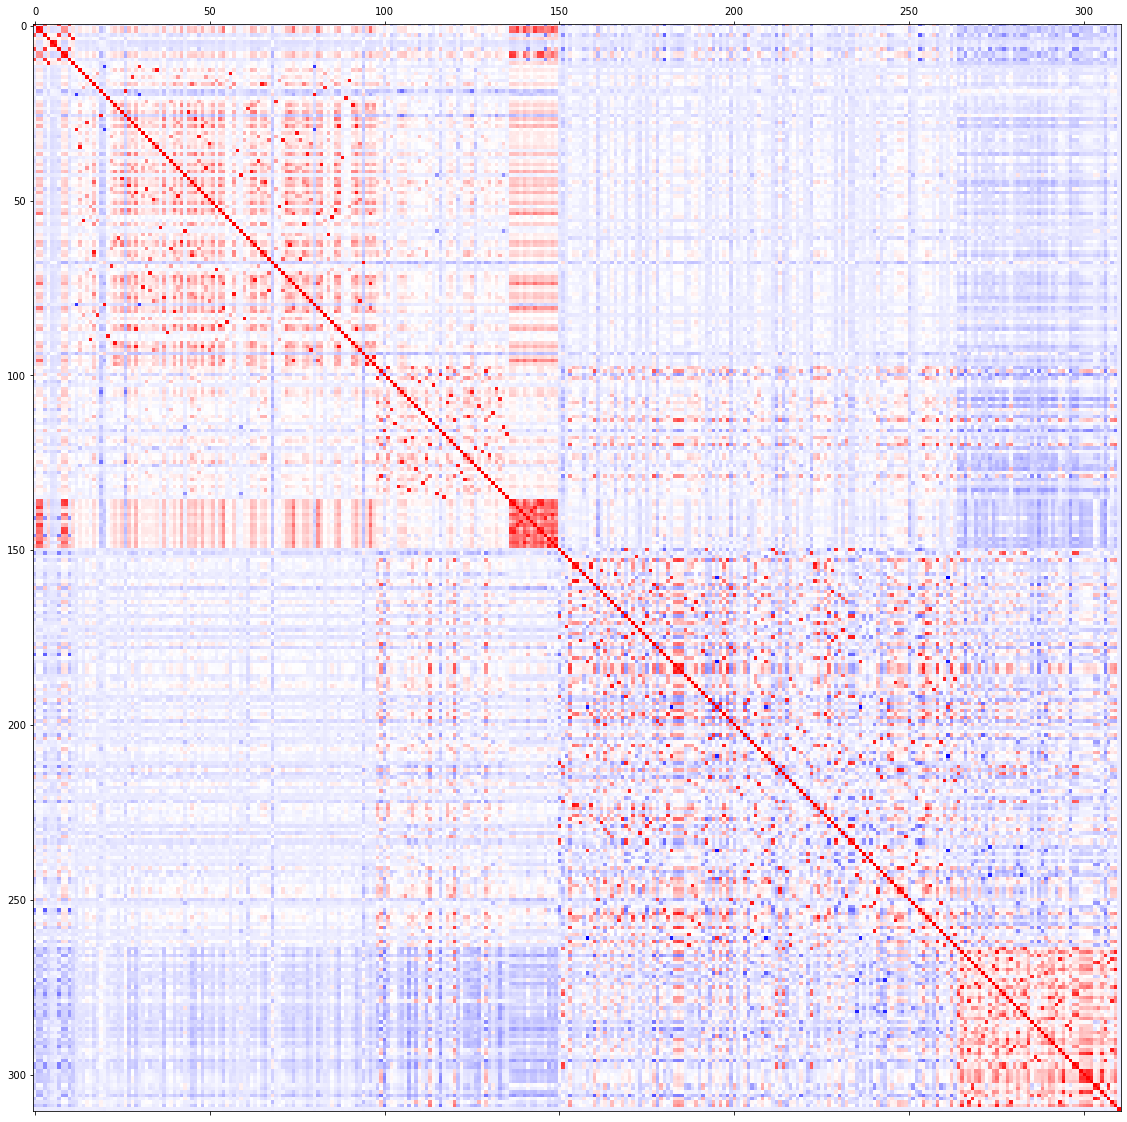

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(hr_train_num.iloc[:, 3:].corr(), cmap='bwr')
plt.savefig('../NumeraiCorr')

In [78]:
u, s, vh = np.linalg.svd(num_train_x[:31240])
s

array([1571.439816  ,  312.06898555,  281.68494621,  222.86249677,
        191.04050657,  187.6546491 ,  170.45712407,  163.36269251,
        147.38377113,  145.75640343,  141.52898319,  127.18815383,
        122.15732685,  116.25663041,  116.04085961,  113.53041945,
        111.75338119,  111.49255855,  110.70353936,  105.99715371,
        103.61057878,  102.09073275,  100.13588175,   98.99204864,
         97.91540558,   97.1603938 ,   95.31990833,   94.25145376,
         92.0505797 ,   91.01763103,   88.75576422,   88.33043832,
         87.92471566,   86.46247213,   85.76793673,   85.54188421,
         84.39193029,   83.63725798,   82.04727016,   81.67061633,
         80.73112458,   79.83089693,   78.74858108,   77.15985839,
         76.44644866,   76.09338747,   75.74162883,   75.30588308,
         73.93895107,   73.12146222,   70.36780373,   69.21416657,
         68.96690386,   68.18034635,   68.03770906,   67.34095539,
         66.32795618,   66.15977342,   65.78370685,   65.12953

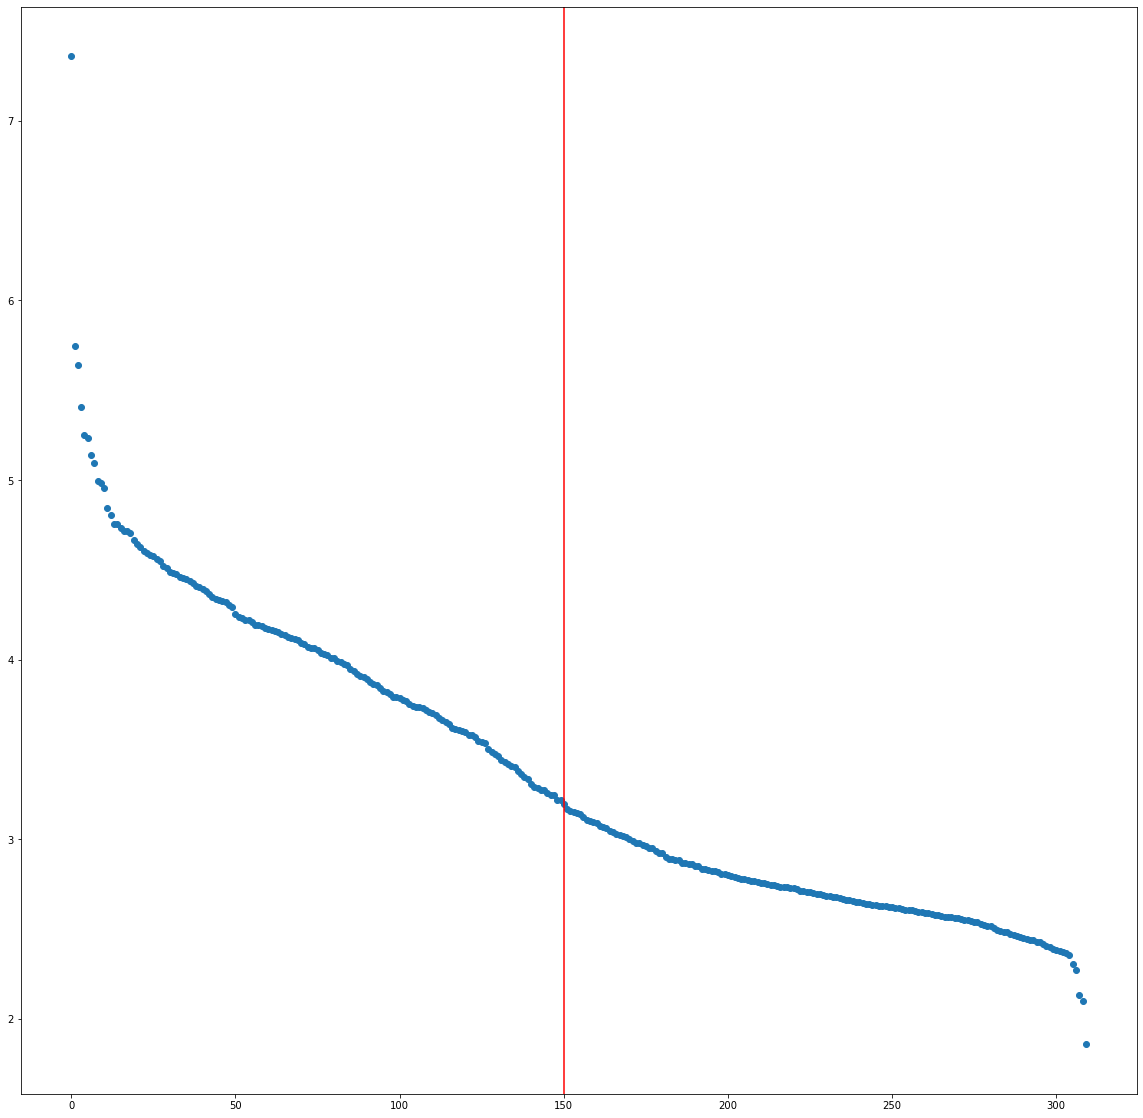

In [79]:
plt.figure(figsize=(20,20))
plt.scatter(y = np.log(s),x = range(310))
plt.axvline(150, color  = 'r')

## Random Forest Spearman Rank Benchmark for Untransformed Data


In [42]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(25,50,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,num_train_x, num_train_y,num_train_era,  client,127, params, 60)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80 81 82 83]
[84 85 86 87 88 89 90 91 92 93 94 95]
[ 96  97  98  99 100 101 102 103 104 105 106 107]
[108 109 110 111 112 113 114 115 116 117 118 119]
Done Scattering
{'criterion': 'mse', 'max_depth': 43, 'max_features': 33, 'max_leaf_nodes': 440, 'max_samples': 0.9, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 750, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
{'criterion': 'mse', 'max_depth': 53, 'max_features': 39, 'max_leaf_nodes': 400, 'max_samples': 0.5, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 750, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
{'criterion': 'mse', 'max_depth': 13, 'max_features': 31, 'max_leaf_nodes': 740, 'max_samples': 0.5, 'min_samples_leaf': 21, 'min_samples_split': 6, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
{'cr

In [43]:
hyp_param.sort_values(by= ['Quartic Mean Error'])

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
16       mse         53            41             720          0.6   
6        mse         13            33             480          0.8   
59       mse         53            49             620          0.8   
34       mse         23            41             540          0.6   
30       mse         33            43             720          0.7   
10       mse         33            41             660          0.6   
54       mse         23            41             560          0.7   
8        mse         23            43             680          0.5   
3        mse         33            41             480          0.7   
32       mse         43            39             580          0.8   
48       mse         33            29             620          0.8   
57       mse         33            43             680          0.9   
15       mse         13            29             720          0.7   
26       mse         23            45             660          0.7   
21       mse         33            47             600          0.9   
31       mse         33            29             460          0.8   
50       mse         43            29             740          0.8   
53       mse         23            33             560          0.8   
33       mse         23            31             600          0.9   
43       mse         53            31             660          0.5   
29       mse         53            45             520          0.6   
20       mse         13            41             600          0.9   
47       mse         33            37             680          0.8   
22       mse         43            27             480          0.8   
23       mse         23            41             520          0.8   
9        mse         53            33             460          0.8   
13       mse         13            41             420          0.6   
45       mse         23            25             700          0.9   
40       mse         53            35             540          0.7   
24       mse         53            35             660          0.5   
36       mse         53            29             440          0.6   
27       mse         33            27             400          0.5   
35       mse         23            29             460          0.8   
7        mse         43            39             640          0.9   
14       mse         53            33             400          0.8   
19       mse         43            43             580          0.7   
18       mse         23            47             520          0.8   
25       mse         13            29             500          0.9   
0        mse         43            33             440          0.9   
17       mse         13            25             720          0.9   
1        mse         53            39             400          0.5   
41       mse         53            29             640          0.6   
11       mse         33            29             540          0.7   
52       mse         13            47             480          0.6   
42       mse         13            25             560          0.7   
2        mse         13            31             740          0.5   
5        mse         53            45             700          0.9   
12       mse         23            27             580          0.5   
28       mse         43            45             540          0.5   
49       mse         23            25             700          0.5   
51       mse         23            35             620          0.5   
56       mse          3            45             620          0.8   
46       mse          3            43             420          0.9   
55       mse          3            39             560          0.8   
58       mse          3            33             400          0.8   
4        mse          3            35             400          0.6   
38       mse 

In [44]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
16       mse         53            41             720          0.6   
30       mse         33            43             720          0.7   
6        mse         13            33             480          0.8   
34       mse         23            41             540          0.6   
10       mse         33            41             660          0.6   
8        mse         23            43             680          0.5   
59       mse         53            49             620          0.8   
57       mse         33            43             680          0.9   
48       mse         33            29             620          0.8   
21       mse         33            47             600          0.9   
15       mse         13            29             720          0.7   
26       mse         23            45             660          0.7   
3        mse         33            41             480          0.7   
54       mse         23            41             560          0.7   
32       mse         43            39             580          0.8   
31       mse         33            29             460          0.8   
22       mse         43            27             480          0.8   
50       mse         43            29             740          0.8   
20       mse         13            41             600          0.9   
33       mse         23            31             600          0.9   
45       mse         23            25             700          0.9   
53       mse         23            33             560          0.8   
47       mse         33            37             680          0.8   
29       mse         53            45             520          0.6   
24       mse         53            35             660          0.5   
23       mse         23            41             520          0.8   
43       mse         53            31             660          0.5   
40       mse         53            35             540          0.7   
17       mse         13            25             720          0.9   
9        mse         53            33             460          0.8   
13       mse         13            41             420          0.6   
27       mse         33            27             400          0.5   
35       mse         23            29             460          0.8   
14       mse         53            33             400          0.8   
36       mse         53            29             440          0.6   
18       mse         23            47             520          0.8   
2        mse         13            31             740          0.5   
7        mse         43            39             640          0.9   
25       mse         13            29             500          0.9   
0        mse         43            33             440          0.9   
19       mse         43            43             580          0.7   
41       mse         53            29             640          0.6   
11       mse         33            29             540          0.7   
1        mse         53            39             400          0.5   
42       mse         13            25             560          0.7   
12       mse         23            27             580          0.5   
5        mse         53            45             700          0.9   
28       mse         43            45             540          0.5   
52       mse         13            47             480          0.6   
51       mse         23            35             620          0.5   
49       mse         23            25             700          0.5   
44       mse          3            25             460          0.8   
4        mse          3            35             400          0.6   
58       mse          3            33             400          0.8   
38       mse          3            33             580          0.7   
39       mse          3            29             640          0.8   
37       mse 

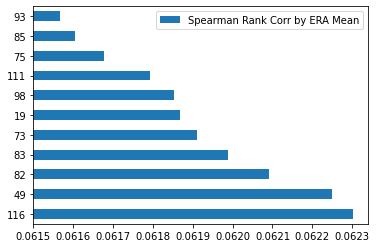

In [23]:
hyp_param[hyp_param['Spearman Rank Corr by ERA Mean']>.06156].sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False).plot(xlim = [.0615,.06234],y=['Spearman Rank Corr by ERA Mean'],kind= 'barh')

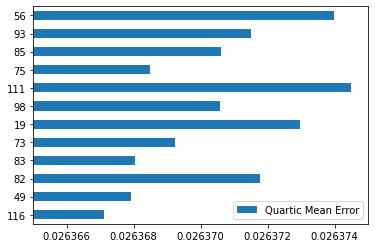

In [24]:
hyp_param[hyp_param['Spearman Rank Corr by ERA Mean']>.0615].sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False).plot(xlim = [.026365,.026375],y=['Quartic Mean Error'],kind= 'barh')

In [106]:
hyp_param.to_csv('RANDOMFOREST_HYPERPARAMETER_TUNING')

In [45]:
# gb_hp = XGBClassifier( max_depth= 5, learning_rate=.01, n_estimators=200, colsample_bytree=.1, verbosity = 1, max_features= 1, n_jobs = -1)
# gb_mean, gb_ci = kfold_dask(100, num_train_x, np.vectorize(np.int)(num_train_y*4),client, gb_hp)

rf_hp =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =1000,
                               max_depth=53,
                               verbose = 0,
                               max_features= 41, 
                               n_jobs=-1,
                               max_leaf_nodes=720, 
                               min_samples_leaf = 37, 
                               min_samples_split = 4,
                               max_samples = .6)
spearman, qme = kfold_dask(30, num_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "None", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 30
0
0 0 30
5
0 0 30
10
0 0 30
15
0 0 30
20
0 0 30
25
0 0 30
30
0 0 30
35
0 0 30
40
0 0 30
45
0 0 30
50
0 0 30
55
0 0 30
60
0 0 30
65
0 0 30
70
0 0 30
75
0 0 30
80
0 0 30
85
0 0 30
90
0 0 30
95
0 0 30
100
0 0 30
105
0 0 30
110
0 0 30
115
0 0 30
120
0 0 30
125
0 0 30
130
0 0 30
135
0 0 30
140
0 0 30
145
0 0 30
150
0 0 30
155
0 0 30
160
0 0 30
165
0 0 30
170
0 0 30
175
0 0 30
180
0 0 30
185
0 0 30
190
0 0 30
195
0 0 30
200
0 0 30
205
0 0 30
210
0 0 30
215
0 0 30
220
0 0 30
225
0 0 30
230
0 0 30
235
0 0 30
240
0 0 30
245
0 0 30
250
0 0 30
255
0 0 30
260
0 0 30
265
0 0 30
270
0 0 30
275
0 0 30
280
2 0 28
285
3 0 27
290
5 0 25
295
7 0 23
300
9 0 21
305
9 0 21
310
11 0 19
315
14 0 16
320
15 0 15
325
15 0 15
330
15 0 15
335
17 0 13
340
19 0 11
345
23 0 7
350
26 0 4
355
29 0 1
360
30 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0                None                        0.048529   0.038476    0.058582   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0             0.02641   0.026375    0.026445

In [17]:
import sklearn
sklearn.__version__

'0.21.3'

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


# SHAP Test


In [20]:
shap.initjs()









In [21]:
model = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =250,
                               max_depth=23,
                               verbose = 2,
                               max_features= 39, 
                               n_jobs=-1,
                               max_leaf_nodes=740,
                               max_samples = .8, 
                               min_samples_leaf = 37, 
                               min_samples_split = 4)
explainer = shap.TreeExplainer(model.fit(num_train_x, num_train_y), data = num_train_x[:1000])
shap_values = explainer.shap_values(num_train_x[:1000])
#force_plot = shap.force_plot(explainer.expected_value, shap_values, num_train_x[:1000])
#shap.save_html(out_file = 'Benchmark SHAP Values', plot_html=force_plot, full_html=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 250building tree 2 of 250

building tree 3 of 250
building tree 4 of 250building tree 5 of 250
building tree 6 of 250
building tree 7 of 250

building tree 8 of 250
building tree 9 of 250building tree 10 of 250
building tree 11 of 250building tree 12 of 250

building tree 13 of 250

building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250building tree 19 of 250

building tree 20 of 250building tree 21 of 250
building tree 22 of 250

building tree 23 of 250building tree 24 of 250
building tree 25 of 250building tree 26 of 250


building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s


building tree 100 of 250
building tree 101 of 250
building tree 102 of 250
building tree 103 of 250
building tree 104 of 250
building tree 105 of 250building tree 106 of 250

building tree 107 of 250
building tree 108 of 250
building tree 109 of 250
building tree 110 of 250
building tree 111 of 250
building tree 112 of 250
building tree 113 of 250
building tree 114 of 250
building tree 115 of 250
building tree 116 of 250
building tree 117 of 250
building tree 118 of 250
building tree 119 of 250
building tree 120 of 250
building tree 121 of 250
building tree 122 of 250
building tree 123 of 250
building tree 124 of 250
building tree 125 of 250
building tree 126 of 250
building tree 127 of 250
building tree 128 of 250
building tree 129 of 250
building tree 130 of 250
building tree 131 of 250
building tree 132 of 250
building tree 133 of 250
building tree 134 of 250
building tree 135 of 250
building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.7s finished
100%|===================| 999/1000 [11:28<00:00]        

In [48]:
shap_val = pd.DataFrame({'Feature':range(310),'Score':np.abs(shap_values).mean(axis = 0)})
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('../Precomputed SHAP Values/SHAP_Benchmark')
shap_val

Feature     Score
142      142  0.002577
139      139  0.001566
141      141  0.001052
74        74  0.000844
131      131  0.000752
..       ...       ...
76        76  0.000025
36        36  0.000018
58        58  0.000016
117      117  0.000014
135      135  0.000011

[310 rows x 2 columns]

In [49]:
shap_val = pd.read_csv('../Precomputed SHAP Values/SHAP_Benchmark')
shap_val.drop('Unnamed: 0', axis=1, inplace=True)
shap_val

Feature     Score
0        142  0.002577
1        139  0.001566
2        141  0.001052
3         74  0.000844
4        131  0.000752
..       ...       ...
305       76  0.000025
306       36  0.000018
307       58  0.000016
308      117  0.000014
309      135  0.000011

[310 rows x 2 columns]

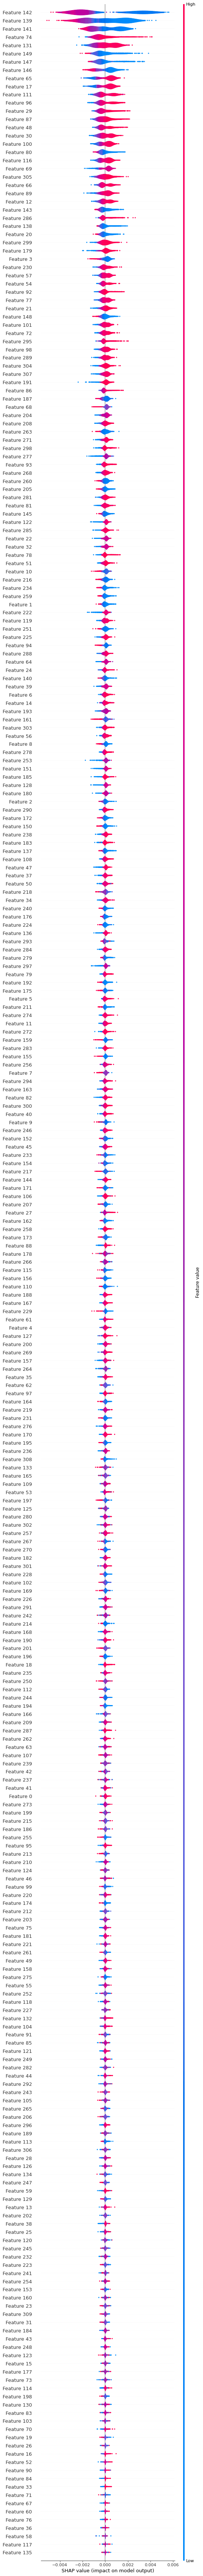

NameError: name 'violin_plot' is not defined

In [49]:
fig = plt.figure()

violnum_col_names= shap.summary_plot(shap_values, num_train_x[:1000], max_display = inplace=plot_type ='violin')
fig.savefig("violin_benchmark.png", bbox_inches='tight', dpi=200)
violin_plot

In [ ]:
fig = plt.figure()

shap.summary_plot(shap_values,num_train_x[:1000], plot_type="bar", max_display = 310)
fig.savefig("mean_SHAP_benchmark.png", bbox_inches='tight', dpi=200)


In [69]:
s = SHAP_tune(num_train_x,num_train_y,num_train_era,200, shap_val, client, 127)

SHAP_tune_results = pd.DataFrame({'Spearman Rank':s[0],'QME': s[1]})
SHAP_tune_results.sort_values('Spearman Rank', ascending = False)

0    142
Name: Feature, dtype: int64
0    142
1    139
Name: Feature, dtype: int64
0    142
1    139
2    141
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
5    149
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
5    149
6    147
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
5    149
6    147
7    146
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
5    149
6    147
7    146
8     65
Name: Feature, dtype: int64
0    142
1    139
2    141
3     74
4    131
5    149
6    147
7    146
8     65
9     17
Name: Feature, dtype: int64
0     142
1     139
2     141
3      74
4     131
5     149
6     147
7     146
8      65
9      17
10    111
Name: Feature, dtype: int64
0     142
1     139
2     141
3      74
4     131
5     149
6     147
7     146
8      

Spearman Rank       QME
110       0.049621  0.026407
107       0.049537  0.026407
101       0.049528  0.026406
99        0.049509  0.026407
70        0.049462  0.026406
..             ...       ...
4         0.028063  0.026507
3         0.022557  0.026542
0         0.017183  0.026481
1         0.014739  0.026487
2         0.014448  0.026512

[199 rows x 2 columns]

In [89]:
rel_col = (shap_val.sort_values('Score', ascending = False).iloc[:111,:]).Feature
SHAP_Dataset =  num_x.iloc[:,rel_col]

SHAP_train_x   =SHAP_Dataset.iloc[:400000,:].to_numpy()
SHAP_test_x =SHAP_Dataset.iloc[400000:,:].to_numpy()
SHAP_train_x.shape

(400000, 111)

In [94]:
params = [{
    
    "n_estimators": range(500,1001,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,100,5),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,SHAP_train_x, num_train_y,num_train_era, client,127, params, 100)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74]
[75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99]
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124]
Done Scattering
{'criterion': 'mse', 'max_depth': 38, 'max_features': 6, 'max_leaf_nodes': 416, 'max_samples': 0.9, 'min_samples_leaf': 27, 'min_samples_split': 4, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
{'criterion': 'mse', 'max_depth': 30, 'max_features': 81, 'max_leaf_nodes': 344, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 25, 'min_samples_split': 8, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
{'criterion': 'mse', 'max_depth': 42, 'max_features': 61, 'max_leaf_nodes': 344, 'max_samples': 0.6000000000000001, 'mi

In [92]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
57       mse         50            46             496          0.5   
56       mse         34            41             416          0.5   
21       mse         30            36             504          0.7   
99       mse         34            31             528          0.8   
54       mse         30            26             392          0.6   
..       ...        ...           ...             ...          ...   
73       mse         46             1             256          0.5   
89       mse         34             1             296          0.5   
95       mse         38             1             200          0.5   
26       mse         38             1             328          0.8   
20       mse         30             1             472          0.5   

    min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
57                33                  6           750      -1            42   
56                29                  8          1000      -1            42   
21                37                  6           750      -1            42   
99                37                  2          1000      -1            42   
54                29                  4          1000      -1            42   
..               ...                ...           ...     ...           ...   
73                 5                  6          1000      -1            42   
89                11                  2          1000      -1            42   
95                13                  2          1000      -1            42   
26                 5                  2           750      -1            42   
20                29                  4           500      -1            42   

    verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
57        0                        0.051756            0.026409  
56        0                        0.051483            0.026407  
21        0                        0.051248            0.026411  
99        0                        0.051194            0.026408  
54        0                        0.051099            0.026405  
..      ...                             ...                 ...  
73        0                        0.046325            0.026440  
89        0                        0.046123            0.026437  
95        0                        0.046003            0.026439  
26        0                        0.045653            0.026439  
20        0                        0.045240            0.026431  

[100 rows x 13 columns]

In [30]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 1000,
                               max_depth= 38,
                               verbose = 0,
                               max_features= 8, 
                               n_jobs=-1, 
                               max_leaf_nodes= 3,
                               max_samples = .6, 
                               min_samples_leaf =27, 
                               min_samples_split = 6)

In [47]:
spearman, qme = kfold_dask(10, SHAP_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "SHAP - 54", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 20
0
0 0 20
5
5 0 15
10
14 0 6
15
20 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0  MDA - 76 Components                        0.051424   0.040728    0.062119   
1  MDA - 76 Components                        0.051424   0.040728    0.062119   
2            SHAP - 54                        0.051424   0.040728    0.062119   
3            SHAP - 54                        0.050259   0.039493    0.061026   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026402   0.026364    0.026440  
1            0.026402   0.026364    0.026440  
2            0.026402   0.026364    0.026440  
3            0.026407   0.026369    0.026444

## MDA for Numerai Dataset

In [25]:
spearman= MDA(num_train_x, (num_train_y),num_train_era, client,60)


0 0 60
0
60 0 0
['tcp://10.128.0.119:43745', 'tcp://10.128.0.120:43681', 'tcp://10.128.0.121:34045', 'tcp://10.128.0.122:43111', 'tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163']
['tcp://10.128.0.120:43681', 'tcp://10.128.0.121:34045', 'tcp://10.128.0.122:43111', 'tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451']


/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/distributed/worker.py:3376: UserWarning: Large object of size 4.46 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 281ab94e2dc30')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


['tcp://10.128.0.121:34045', 'tcp://10.128.0.122:43111', 'tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451', 'tcp://10.128.0.15:39489']
['tcp://10.128.0.122:43111', 'tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451', 'tcp://10.128.0.15:39489', 'tcp://10.128.0.163:37949']
['tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451', 'tcp://10.128.0.15:39489', 'tcp://10.128.0.163:37949', 'tcp://10.128.0.164:42757']
['tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451', 't

In [26]:
feat_score = pd.DataFrame(spearman, columns=["Score","Feature"])
feat_score.to_csv("MDA_Untransformed")

In [50]:
feat_score = pd.read_csv("MDA_Normal_Corr").iloc[:,1:]
feat_score

Score Feature
0    0.003511   [142]
1    0.002190   [139]
2    0.001647   [141]
3    0.001643   [147]
4    0.000976   [146]
..        ...     ...
305 -0.000245   [307]
306 -0.000263   [253]
307 -0.000266   [210]
308 -0.000270    [51]
309 -0.000327   [230]

[310 rows x 2 columns]

In [36]:
s = MDA_tune(num_train_x,num_train_y,num_train_era,120, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
10 0 0
0
0 0 10
0
10 0 0
1
0 0 10
0
10 0 0
2
0 0 10
0
10 0 0
3
0 0 10
0
10 0 0
4
0 0 10
0
10 0 0
5
0 0 10
0
10 0 0
6
0 0 10
0
10 0 0
7
0 0 10
0
10 0 0
8
0 0 10
0
10 0 0
9
0 0 10
0
10 0 0
10
0 0 10
0
10 0 0
11
0 0 10
0
10 0 0
12
0 0 10
0
10 0 0
13
0 0 10
0
10 0 0
14
0 0 10
0
10 0 0
15
0 0 10
0
10 0 0
16
0 0 10
0
10 0 0
17
0 0 10
0
10 0 0
18
0 0 10
0
10 0 0
19
0 0 10
0
10 0 0
20
0 0 10
0
10 0 0
21
0 0 10
0
10 0 0
22
0 0 10
0
10 0 0
23
0 0 10
0
10 0 0
24
0 0 10
0
10 0 0
25
0 0 10
0
10 0 0
26
0 0 10
0
10 0 0
27
0 0 10
0
10 0 0
28
0 0 10
0
10 0 0
29
0 0 10
0
10 0 0
30
0 0 10
0
10 0 0
31
0 0 10
0
10 0 0
32
0 0 10
0
10 0 0
33
0 0 10
0
10 0 0
34
0 0 10
0
10 0 0
35
0 0 10
0
10 0 0
36
0 0 10
0
10 0 0
37
0 0 10
0
10 0 0
38
0 0 10
0
10 0 0
39
1 0 9
0
10 0 0
40
1 0 9
0
10 0 0
41
1 0 9
0
10 0 0
42
1 0 9
0
10 0 0
43
1 0 9
0
10 0 0
44
2 0 8
0
10 0 0
45
2 0 8
0
10 0 0
46
2 0 8
0
10 0 0
47
2 0 8
0
10 0 0
48
2 0 8
0
10 0 0
49
2 0 8
0
10 0 0
50
2 0 8
0
10 0 0
51
3 0 7
0
10 0 0
52
3 0 7
0
10 0 0
5

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
69       0.050314   0.040044    0.060583  0.026418     0.026395      0.026441
63       0.050292   0.040604    0.059980  0.026416     0.026393      0.026438
96       0.050188   0.040442    0.059934  0.026424     0.026402      0.026446
60       0.050168   0.039777    0.060558  0.026416     0.026393      0.026439
51       0.050139   0.040256    0.060023  0.026414     0.026390      0.026437
..            ...        ...         ...       ...          ...           ...
4        0.024358   0.017921    0.030795  0.026496     0.026474      0.026518
3        0.023126   0.016002    0.030250  0.026512     0.026486      0.026538
0        0.016603   0.009204    0.024002  0.026484     0.026469      0.026498
1        0.016033   0.009427    0.022638  0.026506     0.026487      0.026525
2        0.014347   0.008884    0.019810  0.026535     0.026518      0.026552

[118 rows x 6 columns]

## MDA Results

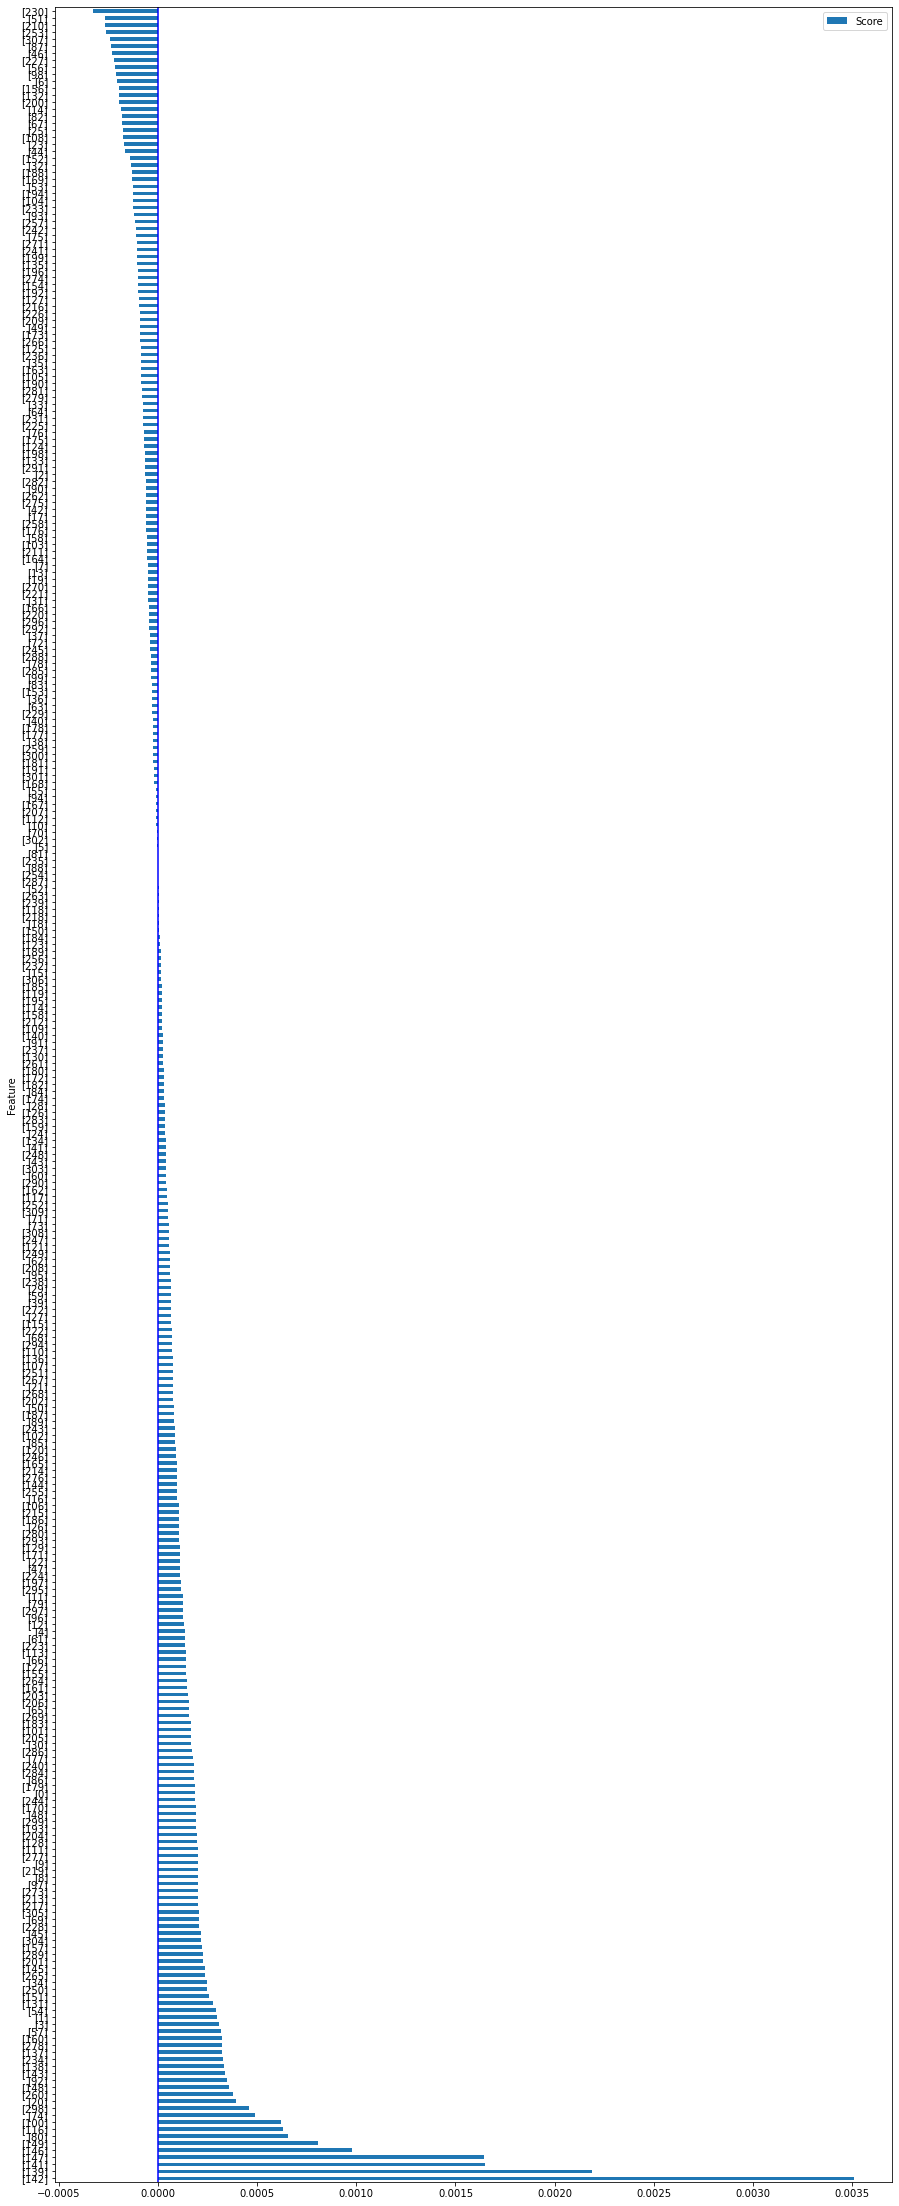

In [29]:

feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,40))

plt.axvline(x= 0, color = 'b')
plt.savefig('MDA_Normal_Barh')

## Random Forest Spearman Rank Corr | MDA Tuning


In [36]:
s = MDA_tune(num_train_x,num_train_y,num_train_era,120, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
10 0 0
0
0 0 10
0
10 0 0
1
0 0 10
0
10 0 0
2
0 0 10
0
10 0 0
3
0 0 10
0
10 0 0
4
0 0 10
0
10 0 0
5
0 0 10
0
10 0 0
6
0 0 10
0
10 0 0
7
0 0 10
0
10 0 0
8
0 0 10
0
10 0 0
9
0 0 10
0
10 0 0
10
0 0 10
0
10 0 0
11
0 0 10
0
10 0 0
12
0 0 10
0
10 0 0
13
0 0 10
0
10 0 0
14
0 0 10
0
10 0 0
15
0 0 10
0
10 0 0
16
0 0 10
0
10 0 0
17
0 0 10
0
10 0 0
18
0 0 10
0
10 0 0
19
0 0 10
0
10 0 0
20
0 0 10
0
10 0 0
21
0 0 10
0
10 0 0
22
0 0 10
0
10 0 0
23
0 0 10
0
10 0 0
24
0 0 10
0
10 0 0
25
0 0 10
0
10 0 0
26
0 0 10
0
10 0 0
27
0 0 10
0
10 0 0
28
0 0 10
0
10 0 0
29
0 0 10
0
10 0 0
30
0 0 10
0
10 0 0
31
0 0 10
0
10 0 0
32
0 0 10
0
10 0 0
33
0 0 10
0
10 0 0
34
0 0 10
0
10 0 0
35
0 0 10
0
10 0 0
36
0 0 10
0
10 0 0
37
0 0 10
0
10 0 0
38
0 0 10
0
10 0 0
39
1 0 9
0
10 0 0
40
1 0 9
0
10 0 0
41
1 0 9
0
10 0 0
42
1 0 9
0
10 0 0
43
1 0 9
0
10 0 0
44
2 0 8
0
10 0 0
45
2 0 8
0
10 0 0
46
2 0 8
0
10 0 0
47
2 0 8
0
10 0 0
48
2 0 8
0
10 0 0
49
2 0 8
0
10 0 0
50
2 0 8
0
10 0 0
51
3 0 7
0
10 0 0
52
3 0 7
0
10 0 0
5

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
69       0.050314   0.040044    0.060583  0.026418     0.026395      0.026441
63       0.050292   0.040604    0.059980  0.026416     0.026393      0.026438
96       0.050188   0.040442    0.059934  0.026424     0.026402      0.026446
60       0.050168   0.039777    0.060558  0.026416     0.026393      0.026439
51       0.050139   0.040256    0.060023  0.026414     0.026390      0.026437
..            ...        ...         ...       ...          ...           ...
4        0.024358   0.017921    0.030795  0.026496     0.026474      0.026518
3        0.023126   0.016002    0.030250  0.026512     0.026486      0.026538
0        0.016603   0.009204    0.024002  0.026484     0.026469      0.026498
1        0.016033   0.009427    0.022638  0.026506     0.026487      0.026525
2        0.014347   0.008884    0.019810  0.026535     0.026518      0.026552

[118 rows x 6 columns]

In [51]:
rel_col = (feat_score.sort_values('Score', ascending = False).iloc[:71,:]).Feature
rel_col = rel_col.apply(lambda x: int(x.strip('[]').split("' '")[0]))
MDA_Dataset =  num_x.iloc[:,rel_col]

MDA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_train_x.shape
rel_col

0     142
1     139
2     141
3     147
4     146
     ... 
66    269
67     65
68    206
69    203
70    161
Name: Feature, Length: 71, dtype: int64

In [110]:
params = [{
    
    "n_estimators": range(500,1001,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,10,1),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_train_x, num_train_y,num_train_era, client,30, params, 100)

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_depth': 46, 'max_features': 7, 'max_leaf_nodes': 320, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 21, 'min_samples_split': 4, 'n_estimators': 675, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_depth': 30, 'max_features': 2, 'max_leaf_nodes': 336, 'max_samples': 0.8, 'min_samples_leaf': 27, 'min_samples_split': 6, 'n_estimators': 525, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_depth': 38, 'max_features': 4, 'max_leaf_nodes': 408, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 21, 'min_samples_split': 2, 'n_estimators': 825, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_depth': 34, 'max_features': 4, 'max_leaf_nodes': 2

In [112]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
79       mse         50             6             520          0.5   
89       mse         42             8             448          0.7   
34       mse         50             7             328          0.5   
61       mse         42             5             360          0.8   
44       mse         46             9             464          0.9   
..       ...        ...           ...             ...          ...   
7        mse         38             1             312          0.6   
58       mse         38             1             360          0.5   
21       mse         34             1             352          0.5   
78       mse         34             1             528          0.8   
93       mse         50             1             440          0.7   

    min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
79                27                  6           975      -1            42   
89                31                  8           800      -1            42   
34                35                  2           825      -1            42   
61                35                  8           950      -1            42   
44                39                  2           950      -1            42   
..               ...                ...           ...     ...           ...   
7                  7                  8           500      -1            42   
58                21                  6           500      -1            42   
21                25                  8           525      -1            42   
78                 7                  6           500      -1            42   
93                 5                  8           525      -1            42   

    verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
79        0                        0.064007            0.026364  
89        0                        0.063616            0.026364  
34        0                        0.063390            0.026367  
61        0                        0.063223            0.026372  
44        0                        0.063121            0.026363  
..      ...                             ...                 ...  
7         0                        0.057981            0.026427  
58        0                        0.056996            0.026422  
21        0                        0.056879            0.026421  
78        0                        0.056481            0.026424  
93        0                        0.055054            0.026428  

[100 rows x 13 columns]

In [30]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 975,
                               max_depth= 50,
                               verbose = 0,
                               max_features= 6, 
                               n_jobs=-1, 
                               max_leaf_nodes= 520,
                               max_samples = .5, 
                               min_samples_leaf =27, 
                               min_samples_split = 6)

In [31]:
spearman, qme = kfold_dask(10, MDA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "MDA - 76 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
7 0 3
10
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0                 None                        0.051694   0.041455    0.061934   
1  MDA - 76 Components                        0.052513   0.042567    0.062460   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026399   0.026365    0.026433  
1            0.026396   0.026367    0.026426

# MDA vs SHAP Comparison

In [76]:
shap_rank = shap_val.rank(method ='first').loc[:,'Feature'].iloc[:100]
shap_rank

142    143.0
139    140.0
141    142.0
74      75.0
131    132.0
       ...  
180    181.0
2        3.0
290    291.0
172    173.0
150    151.0
Name: Feature, Length: 100, dtype: float64

In [77]:
mda_rank = feat_score.Feature.apply(lambda x: int(x.strip('[]').split("' '")[0])).rank(method ='first').iloc[:100]
mda_rank

0     143.0
1     140.0
2     142.0
3     148.0
4     147.0
      ...  
95    216.0
96    107.0
97     17.0
98    256.0
99    145.0
Name: Feature, Length: 100, dtype: float64

In [78]:
st.spearmanr(mda_rank, shap_rank)

SpearmanrResult(correlation=0.04732073207320731, pvalue=0.6401279000210428)

## Random Forest AUC-ROC | MDA 1 SD above the mean


In [34]:
rel_col = feat_score[feat_score['Score'] > float(MDA_mean + MDA_std)].Feature
rel_col = rel_col.apply(lambda x: int(x.strip('[]').split("' '")[0]))
MDA_Dataset =  num_x.iloc[:,rel_col]

MDA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_train_x.shape

(400000, 35)

In [35]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,25,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_train_x, num_train_y, num_train_era, client,30, params, 100)

Done Scattering
0 0 500
0
0 0 500
5
0 0 500
10
0 0 500
15
0 0 500
20
0 0 500
25
0 0 500
30
0 0 500
35
0 0 500
40
0 0 500
45
0 0 500
50
0 0 500
55
0 0 500
60
0 0 500
65
0 0 500
70
0 0 500
75
0 0 500
80
0 0 500
85
0 0 500
90
0 0 500
95
0 0 500
100
0 0 500
105
0 0 500
110
0 0 500
115
0 0 500
120
0 0 500
125
0 0 500
130
0 0 500
135
0 0 500
140
0 0 500
145
0 0 500
150
0 0 500
155
0 0 500
160
0 0 500
165
0 0 500
170
0 0 500
175
0 0 500
180
0 0 500
185
0 0 500
190
0 0 500
195
0 0 500
200
0 0 500
205
0 0 500
210
0 0 500
215
0 0 500
220
0 0 500
225
0 0 500
230
0 0 500
235
0 0 500
240
0 0 500
245
0 0 500
250
0 0 500
255
0 0 500
260
0 0 500
265
0 0 500
270
0 0 500
275
0 0 500
280
0 0 500
285
0 0 500
290
0 0 500
295
0 0 500
300
0 0 500
305
0 0 500
310
0 0 500
315
0 0 500
320
0 0 500
325
0 0 500
330
0 0 500
335
0 0 500
340
0 0 500
345
0 0 500
350
0 0 500
355
0 0 500
360
0 0 500
365
0 0 500
370
0 0 500
375
0 0 500
380
0 0 500
385
0 0 500
390
0 0 500
395
0 0 500
400
0 0 500
405
0 0 500
410
0 0 500
41

In [36]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
63       mse            18             624          0.5                39   
20       mse            14             720          0.6                35   
18       mse            14             512          0.6                33   
36       mse            18             648          0.5                39   
81       mse             6             704          0.7                21   
..       ...           ...             ...          ...               ...   
97       mse            20             496          0.9                25   
56       mse             2             544          0.5                 5   
23       mse             2             656          0.5                 5   
99       mse             2             464          0.8                29   
49       mse             2             504          0.8                 9   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
63                  6          1250      -1            42        0   
20                  8          1000      -1            42        0   
18                  6          1375      -1            42        0   
36                  8           825      -1            42        0   
81                  6           875      -1            42        0   
..                ...           ...     ...           ...      ...   
97                  6           500      -1            42        0   
56                  6          1100      -1            42        0   
23                  2           600      -1            42        0   
99                  4           700      -1            42        0   
49                  8           750      -1            42        0   

    Spearman Rank Corr by ERA Mean  
63                        0.052979  
20                        0.052947  
18                        0.052871  
36                        0.052867  
81                        0.052844  
..                             ...  
97                        0.050570  
56                        0.049754  
23                        0.049589  
99                        0.049441  
49                        0.049310  

[100 rows x 11 columns]

In [38]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 1250,
                               max_depth= 50,
                               verbose = 0,
                               max_features= 18, 
                               n_jobs=-1, 
                               max_leaf_nodes= 600,
                               max_samples = .5, 
                               min_samples_leaf =39, 
                               min_samples_split = 6 )

In [39]:
rf_mean, rf_ci = kfold_dask(10, MDA_train_x,num_train_y,num_train_era,client, rf_hp,30)
redux_race = redux_race.append({"Reduction Technique": "MDA 1 SD", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  \
0                None                        0.051718   
1            MDA 2 SD                        0.033754   
2            MDA 1 SD                        0.045523   

   Confidence Interval 2.5%  Confidence Interval 97.5%  
0                  0.041076                   0.062360  
1                  0.024969                   0.042538  
2                  0.035479                   0.055566

## Random Forest AUC-ROC | MDA .5 SD above the mean


In [40]:
rel_col = feat_score[feat_score['Score'] > float(MDA_mean + .5*MDA_std)].Feature
rel_col = rel_col.apply(lambda x: int(x.strip('[]').split("' '")[0]))
MDA_Dataset =  num_x.iloc[:,rel_col]

MDA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
cMDA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_train_x.shape

(400000, 77)

In [41]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": [.5],
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,37,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_train_x, num_train_y, num_train_era, client,30, params, 100)

Done Scattering
0 0 500
0
0 0 500
5
0 0 500
10
0 0 500
15
0 0 500
20
0 0 500
25
0 0 500
30
0 0 500
35
0 0 500
40
0 0 500
45
0 0 500
50
0 0 500
55
0 0 500
60
0 0 500
65
0 0 500
70
0 0 500
75
0 0 500
80
0 0 500
85
0 0 500
90
0 0 500
95
0 0 500
100
0 0 500
105
0 0 500
110
0 0 500
115
0 0 500
120
0 0 500
125
0 0 500
130
0 0 500
135
0 0 500
140
0 0 500
145
0 0 500
150
0 0 500
155
0 0 500
160
0 0 500
165
0 0 500
170
0 0 500
175
0 0 500
180
0 0 500
185
0 0 500
190
0 0 500
195
0 0 500
200
0 0 500
205
0 0 500
210
0 0 500
215
0 0 500
220
0 0 500
225
0 0 500
230
0 0 500
235
0 0 500
240
0 0 500
245
0 0 500
250
0 0 500
255
0 0 500
260
0 0 500
265
0 0 500
270
0 0 500
275
0 0 500
280
0 0 500
285
0 0 500
290
0 0 500
295
0 0 500
300
0 0 500
305
0 0 500
310
0 0 500
315
0 0 500
320
0 0 500
325
0 0 500
330
0 0 500
335
0 0 500
340
0 0 500
345
0 0 500
350
0 0 500
355
0 0 500
360
0 0 500
365
0 0 500
370
0 0 500
375
0 0 500
380
0 0 500
385
0 0 500
390
0 0 500
395
0 0 500
400
0 0 500
405
0 0 500
410
0 0 500
41

In [42]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
15       mse            28             736          0.5                25   
53       mse            20             680          0.5                33   
85       mse            26             640          0.5                35   
86       mse            28             704          0.5                17   
13       mse            30             616          0.5                33   
..       ...           ...             ...          ...               ...   
50       mse             2             688          0.5                25   
73       mse             8             552          0.5                 5   
77       mse             2             632          0.5                11   
97       mse             2             456          0.5                11   
95       mse             2             464          0.5                19   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
15                  2          1325      -1            42        0   
53                  6           850      -1            42        0   
85                  4          1200      -1            42        0   
86                  8          1125      -1            42        0   
13                  6          1100      -1            42        0   
..                ...           ...     ...           ...      ...   
50                  4          1500      -1            42        0   
73                  6          1000      -1            42        0   
77                  8          1425      -1            42        0   
97                  2          1350      -1            42        0   
95                  8          1250      -1            42        0   

    Spearman Rank Corr by ERA Mean  
15                        0.060533  
53                        0.060527  
85                        0.060519  
86                        0.060334  
13                        0.060299  
..                             ...  
50                        0.056794  
73                        0.056541  
77                        0.055475  
97                        0.055247  
95                        0.054326  

[100 rows x 11 columns]

In [43]:
rf_mean, rf_ci = kfold_dask(10, MDA_train_x, num_train_y,num_train_era,client, rf_hp, 30)
redux_race = redux_race.append({"Reduction Technique": "MDA .5 SD", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
2 0 8
40
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  \
0                None                        0.051718   
1            MDA 2 SD                        0.033754   
2            MDA 1 SD                        0.045523   
3           MDA .5 SD                        0.051686   

   Confidence Interval 2.5%  Confidence Interval 97.5%  
0                  0.041076                   0.062360  
1                  0.024969                   0.042538  
2                  0.035479                   0.055566  
3                  0.041231                   0.062141

## Random Forest AUC-ROC | MDA above the mean


In [44]:
rel_col = feat_score[feat_score['Score'] > float(MDA_mean)].Feature
rel_col = rel_col.apply(lambda x: int(x.strip('[]').split("' '")[0]))
MDA_Dataset =  num_x.iloc[:,rel_col]

MDA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_train_x.shape

(400000, 148)

In [46]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": [.5],
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,40,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_train_x, num_train_y, num_train_era, client,30, params, 100)

Done Scattering
0 0 500
0
0 0 500
5
0 0 500
10
0 0 500
15
0 0 500
20
0 0 500
25
0 0 500
30
0 0 500
35
0 0 500
40
0 0 500
45
0 0 500
50
0 0 500
55
0 0 500
60
0 0 500
65
0 0 500
70
0 0 500
75
0 0 500
80
0 0 500
85
0 0 500
90
0 0 500
95
0 0 500
100
0 0 500
105
0 0 500
110
0 0 500
115
0 0 500
120
0 0 500
125
0 0 500
130
0 0 500
135
0 0 500
140
0 0 500
145
0 0 500
150
0 0 500
155
0 0 500
160
0 0 500
165
0 0 500
170
0 0 500
175
0 0 500
180
0 0 500
185
0 0 500
190
0 0 500
195
0 0 500
200
0 0 500
205
0 0 500
210
0 0 500
215
0 0 500
220
0 0 500
225
0 0 500
230
0 0 500
235
0 0 500
240
0 0 500
245
0 0 500
250
0 0 500
255
0 0 500
260
0 0 500
265
0 0 500
270
0 0 500
275
0 0 500
280
0 0 500
285
0 0 500
290
0 0 500
295
0 0 500
300
0 0 500
305
0 0 500
310
0 0 500
315
0 0 500
320
0 0 500
325
0 0 500
330
0 0 500
335
0 0 500
340
0 0 500
345
0 0 500
350
0 0 500
355
0 0 500
360
0 0 500
365
0 0 500
370
0 0 500
375
0 0 500
380
0 0 500
385
0 0 500
390
0 0 500
395
0 0 500
400
0 0 500
405
0 0 500
410
0 0 500
41

In [47]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
40       mse            30             512          0.5                37   
84       mse            30             552          0.5                37   
38       mse            32             720          0.5                39   
83       mse            36             536          0.5                31   
60       mse            32             608          0.5                37   
..       ...           ...             ...          ...               ...   
37       mse             4             664          0.5                11   
25       mse             2             416          0.5                29   
8        mse             4             600          0.5                11   
46       mse             2             608          0.5                25   
91       mse             2             576          0.5                 9   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
40                  4          1225      -1            42        0   
84                  2          1000      -1            42        0   
38                  4          1125      -1            42        0   
83                  6          1500      -1            42        0   
60                  2           775      -1            42        0   
..                ...           ...     ...           ...      ...   
37                  6          1025      -1            42        0   
25                  6          1450      -1            42        0   
8                   8           600      -1            42        0   
46                  6           675      -1            42        0   
91                  2           500      -1            42        0   

    Spearman Rank Corr by ERA Mean  
40                        0.061478  
84                        0.061306  
38                        0.061195  
83                        0.061100  
60                        0.060818  
..                             ...  
37                        0.056044  
25                        0.055701  
8                         0.055409  
46                        0.052827  
91                        0.050678  

[100 rows x 11 columns]

In [48]:
rf_hp =(RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 1225,
                               max_depth=30 ,
                               verbose = 0,
                               max_features= 30, 
                               n_jobs=-1,
                               max_leaf_nodes= 512,
                               max_samples = .5, 
                               min_samples_leaf = 37, 
                               min_samples_split = 4 ))

In [49]:
rf_mean, rf_ci = kfold_dask(10, MDA_train_x,num_train_y, num_train_era,client, rf_hp,30)
redux_race = redux_race.append({"Reduction Technique": "MDA Above Mean", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
4 0 6
65
7 0 3
70
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  \
0                None                        0.051718   
1            MDA 2 SD                        0.033754   
2            MDA 1 SD                        0.045523   
3           MDA .5 SD                        0.051686   
4      MDA Above Mean                        0.052214   

   Confidence Interval 2.5%  Confidence Interval 97.5%  
0                  0.041076                   0.062360  
1                  0.024969                   0.042538  
2                  0.035479                   0.055566  
3                  0.041231                   0.062141  
4                  0.041486                   0.062943

## Linear Discriminant Analysis on Numerai Data

In [21]:
# rf_hp =(RandomForestRegressor(criterion= 'mse',
#                                random_state = 42,
#                                n_estimators = 625,
#                                max_depth=30 ,
#                                verbose = 0,
#                                max_features= 4, 
#                                n_jobs=-1,
#                                max_leaf_nodes= 552,
#                                max_samples = .5, 
#                                min_samples_leaf = 31, 
#                                min_samples_split = 2 ))

In [ ]:
# params = [{
#           "n_components":[4],
#           "tol" : np.arange(1,200) *1e-5,
         
# }]

# lda = LinearDiscriminantAnalysis
# LDA_tune = tune_redux_corank_dask(lda, num_train_x,num_train_y,2,150,  client, params,30,30)
# LDA_tune #.sort_values(by=['Spearman Rank Corr by ERA Mean'],ascending = False)

0 0 30
0
0 0 30
5
0 0 30
10
0 0 30
15
0 0 30
20
0 0 30
25
0 0 30
30
30 0 0
gathered
[array([[ 1.8125334 , -0.54356125,  0.83804212,  0.73718813],
       [ 0.81136033,  1.17582302,  0.27817099, -1.08058141],
       [ 1.12580259, -0.81813358,  0.28872663, -1.16148646],
       ...,
       [-0.03693927,  1.19318894,  0.95683777,  0.79737419],
       [-1.77264158, -0.37597546,  0.93788355,  1.28811487],
       [-1.32043698, -0.9156271 ,  0.19522744, -0.16827686]]), array([[ 1.8125334 , -0.54356125,  0.83804212,  0.73718813],
       [ 0.81136033,  1.17582302,  0.27817099, -1.08058141],
       [ 1.12580259, -0.81813358,  0.28872663, -1.16148646],
       ...,
       [-0.03693927,  1.19318894,  0.95683777,  0.79737419],
       [-1.77264158, -0.37597546,  0.93788355,  1.28811487],
       [-1.32043698, -0.9156271 ,  0.19522744, -0.16827686]]), array([[ 1.8125334 , -0.54356125,  0.83804212,  0.73718813],
       [ 0.81136033,  1.17582302,  0.27817099, -1.08058141],
       [ 1.12580259, -0.81813358,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-35eef89d9496>", line 8, in <module>
    LDA_tune = tune_redux_corank_dask(lda, num_train_x,num_train_y,2,150,  client, params,30,30)
  File "<ipython-input-21-af665b908bed>", line 88, in tune_redux_corank_dask
    timer(results)
  File "<ipython-input-8-da2f334be19f>", line 60, in timer
    time.sleep(5)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another ex

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-35eef89d9496>", line 8, in <module>
    LDA_tune = tune_redux_corank_dask(lda, num_train_x,num_train_y,2,150,  client, params,30,30)
  File "<ipython-input-21-af665b908bed>", line 88, in tune_redux_corank_dask
    timer(results)
  File "<ipython-input-8-da2f334be19f>", line 60, in timer
    time.sleep(5)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another ex

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-35eef89d9496>", line 8, in <module>
    LDA_tune = tune_redux_corank_dask(lda, num_train_x,num_train_y,2,150,  client, params,30,30)
  File "<ipython-input-21-af665b908bed>", line 88, in tune_redux_corank_dask
    timer(results)
  File "<ipython-input-8-da2f334be19f>", line 60, in timer
    time.sleep(5)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another ex

In [61]:
# LDA_tune

n_components      tol  Spearman Rank Corr by ERA Mean
0              4  0.00181                        0.054473
1              4  0.00076                        0.054473
2              4  0.00093                        0.054473
3              4  0.00130                        0.054473
4              4  0.00017                        0.054473
..           ...      ...                             ...
95             4  0.00174                        0.054473
96             4  0.00003                        0.054473
97             4  0.00071                        0.054473
98             4  0.00113                        0.054473
99             4  0.00156                        0.054473

[100 rows x 3 columns]

In [62]:
# lda = LinearDiscriminantAnalysis(n_components = 4, tol = 65*1e-5)
# LDA_train_x = lda.fit_transform(num_train_x, num_train_y*4)

## Random Forest AUC-ROC | LDA


In [63]:


# params = [{
    
#     "n_estimators": range(500,1001,25),
#     "min_samples_split" : range(2,10, 2),
#     "max_leaf_nodes" : range(200,551,8),
#     #"oob_score" :[True],
#     "min_samples_leaf":range(5,40,2),
#     "max_samples": np.arange(5,10)*.1,
#     "verbose" : [0], 
#     "n_jobs" : [-1],
#     "random_state" : [42],
#     "max_features" : range(1,4,1),
#     "criterion" : ['mse']
# }]
# model = RandomForestRegressor
# hyp_param = tune_dask_kfold(model,LDA_train_x, num_train_y, num_train_era, client,30, params, 100)

Done Scattering
0 0 500
0
0 0 500
5
0 0 500
10
0 0 500
15
0 0 500
20
0 0 500
25
0 0 500
30
0 0 500
35
0 0 500
40
0 0 500
45
0 0 500
50
0 0 500
55
0 0 500
60
0 0 500
65
0 0 500
70
0 0 500
75
0 0 500
80
0 0 500
85
0 0 500
90
0 0 500
95
0 0 500
100
0 0 500
105
0 0 500
110
0 0 500
115
0 0 500
120
0 0 500
125
0 0 500
130
0 0 500
135
0 0 500
140
0 0 500
145
0 0 500
150
0 0 500
155
0 0 500
160
0 0 500
165
0 0 500
170
0 0 500
175
0 0 500
180
0 0 500
185
0 0 500
190
0 0 500
195
0 0 500
200
0 0 500
205
0 0 500
210
0 0 500
215
0 0 500
220
160 0 340
280
160 0 340
285
177 0 323
290
195 0 305
295
268 0 232
300
330 0 170
305
393 0 107
310
433 0 67
315
500 0 0


In [64]:
# hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)


criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
81       mse             1             216          0.8                21   
19       mse             2             224          0.8                 7   
33       mse             3             216          0.6                 9   
22       mse             2             264          0.6                13   
77       mse             2             240          0.8                17   
..       ...           ...             ...          ...               ...   
76       mse             2             504          0.5                39   
0        mse             2             544          0.9                29   
30       mse             3             480          0.5                29   
44       mse             3             536          0.7                17   
70       mse             3             512          0.7                37   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
81                  6           775      -1            42        0   
19                  8           750      -1            42        0   
33                  2           825      -1            42        0   
22                  2           975      -1            42        0   
77                  4           700      -1            42        0   
..                ...           ...     ...           ...      ...   
76                  2           800      -1            42        0   
0                   8           625      -1            42        0   
30                  2           750      -1            42        0   
44                  2           750      -1            42        0   
70                  4           925      -1            42        0   

    Spearman Rank Corr by ERA Mean  
81                        0.065837  
19                        0.065646  
33                        0.065447  
22                        0.065387  
77                        0.065287  
..                             ...  
76                        0.062484  
0                         0.062445  
30                        0.062444  
44                        0.062116  
70                        0.062102  

[100 rows x 11 columns]

In [65]:
# rf_hp =(RandomForestRegressor(criterion= 'mse',
#                                random_state = 42,
#                                n_estimators = 775,
#                                max_depth=30 ,
#                                verbose = 0,
#                                max_features= 1, 
#                                n_jobs=-1,
#                                max_leaf_nodes= 216,
#                                max_samples = .8, 
#                                min_samples_leaf = 21, 
#                                min_samples_split = 6 ))

In [67]:
# rf_mean, rf_ci = kfold_dask(10, LDA_train_x, num_train_y, num_train_era,client, rf_hp,30)
# redux_race = redux_race.append({"Reduction Technique": "LDA", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
# redux_race

0 0 10
0
0 0 10
5
0 0 10
10
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  \
0                None                        0.051718   
1            MDA 2 SD                        0.033754   
2            MDA 1 SD                        0.045523   
3           MDA .5 SD                        0.051686   
4      MDA Above Mean                        0.052214   
5                 LDA                        0.058670   

   Confidence Interval 2.5%  Confidence Interval 97.5%  
0                  0.041076                   0.062360  
1                  0.024969                   0.042538  
2                  0.035479                   0.055566  
3                  0.041231                   0.062141  
4                  0.041486                   0.062943  
5                  0.048248                   0.069091

# Kernel PCA

In [22]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 500,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 3, 
                               n_jobs=-1, 
                               max_leaf_nodes= 106,
                               max_samples = .5, 
                               min_samples_leaf = 29, 
                               min_samples_split = 12 )

In [23]:
kpca_train_x = num_train_x[:31240]
kpca_train_y = num_train_y[:31240]
params = [{
          "kernel": ["linear","poly","rbf",'sigmoid','cosine'],
          "degree": range(2,7),
          "coef0" : range(1,10),
          "alpha": range(1,10),
          "eigen_solver": ['arpack'],
          "n_jobs" :[-1],
          "n_components":np.arange(32,190,10)
        
         
}]
kpca =  KernelPCA
KPCA_tune, graphs = tune_redux_corank_dask(kpca,5, kpca_train_x,kpca_train_y,num_train_era[:31240],20,200,  client, params,120,60)
KPCA_tune.sort_values(by=['LCMC Max'],ascending = False)


0 0 120
0
0 0 120
5
0 0 120
10
0 0 120
15
0 0 120
20
0 0 120
25
0 0 120
30
0 0 120
35
0 0 120
40
0 0 120
45
0 0 120
50
0 0 120
55
0 0 120
60
0 0 120
65
0 0 120
70
0 0 120
75
0 0 120
80
0 0 120
85
0 0 120
90
3 0 117
95
4 0 116
100
4 0 116
105
4 0 116
110
6 0 114
115
7 0 113
120
7 0 113
125
10 0 110
130
12 0 108
135
13 0 107
140
18 0 102
145
21 0 99
150
21 0 99
155
27 0 93
160
29 0 91
165
32 0 88
170
33 0 87
175
33 0 87
180
35 0 85
185
37 0 83
190
37 0 83
195
38 0 82
200
39 0 81
205
42 0 78
210
46 0 74
215
47 0 73
220
49 0 71
225
52 0 68
230
53 0 67
235
57 0 63
240
62 0 58
245
62 0 58
250
65 0 55
255
65 0 55
260
66 0 54
265
68 0 52
270
69 0 51
275
72 0 48
280
73 0 47
285
78 0 42
290
80 0 40
295
80 0 40
300
81 0 39
305
84 0 36
310
85 0 35
315
85 0 35
320
85 0 35
325
87 0 33
330
88 0 32
335
90 0 30
340
94 0 26
345
95 0 25
350
95 0 25
355
98 0 22
360
98 0 22
365
98 0 22
370
100 0 20
375
101 0 19
380
102 0 18
385
103 0 17
390
104 0 16
395
104 0 16
400
104 0 16
405
105 0 15
410
105 0 15
415
1

alpha  coef0  degree eigen_solver  kernel  n_components  n_jobs  \
56       3      8       5       arpack  linear           182      -1   
71       6      7       2       arpack    poly           172      -1   
91       1      9       2       arpack  linear           162      -1   
20       5      8       6       arpack  linear           162      -1   
17       5      4       6       arpack  linear           162      -1   
..     ...    ...     ...          ...     ...           ...     ...   
10       7      1       5       arpack     rbf            32      -1   
115      2      4       6       arpack  cosine            52      -1   
15       5      2       4       arpack  cosine            42      -1   
73       4      4       4       arpack  cosine            42      -1   
101      7      2       2       arpack  cosine            32      -1   

     LCMC Max  KNN Score    K  
56   0.957910  -0.051841   42  
71   0.951027  -0.051440   42  
91   0.948458  -0.052655   51  
20   0.948458  -0.052151   51  
17   0.948458  -0.052675   51  
..        ...        ...  ...  
10   0.614350  -0.045620  199  
115  0.603029  -0.051174  199  
15   0.584384  -0.045044  199  
73   0.584384  -0.045364  199  
101  0.551022  -0.044755  199  

[120 rows x 10 columns]

0
1
2
3
4
5


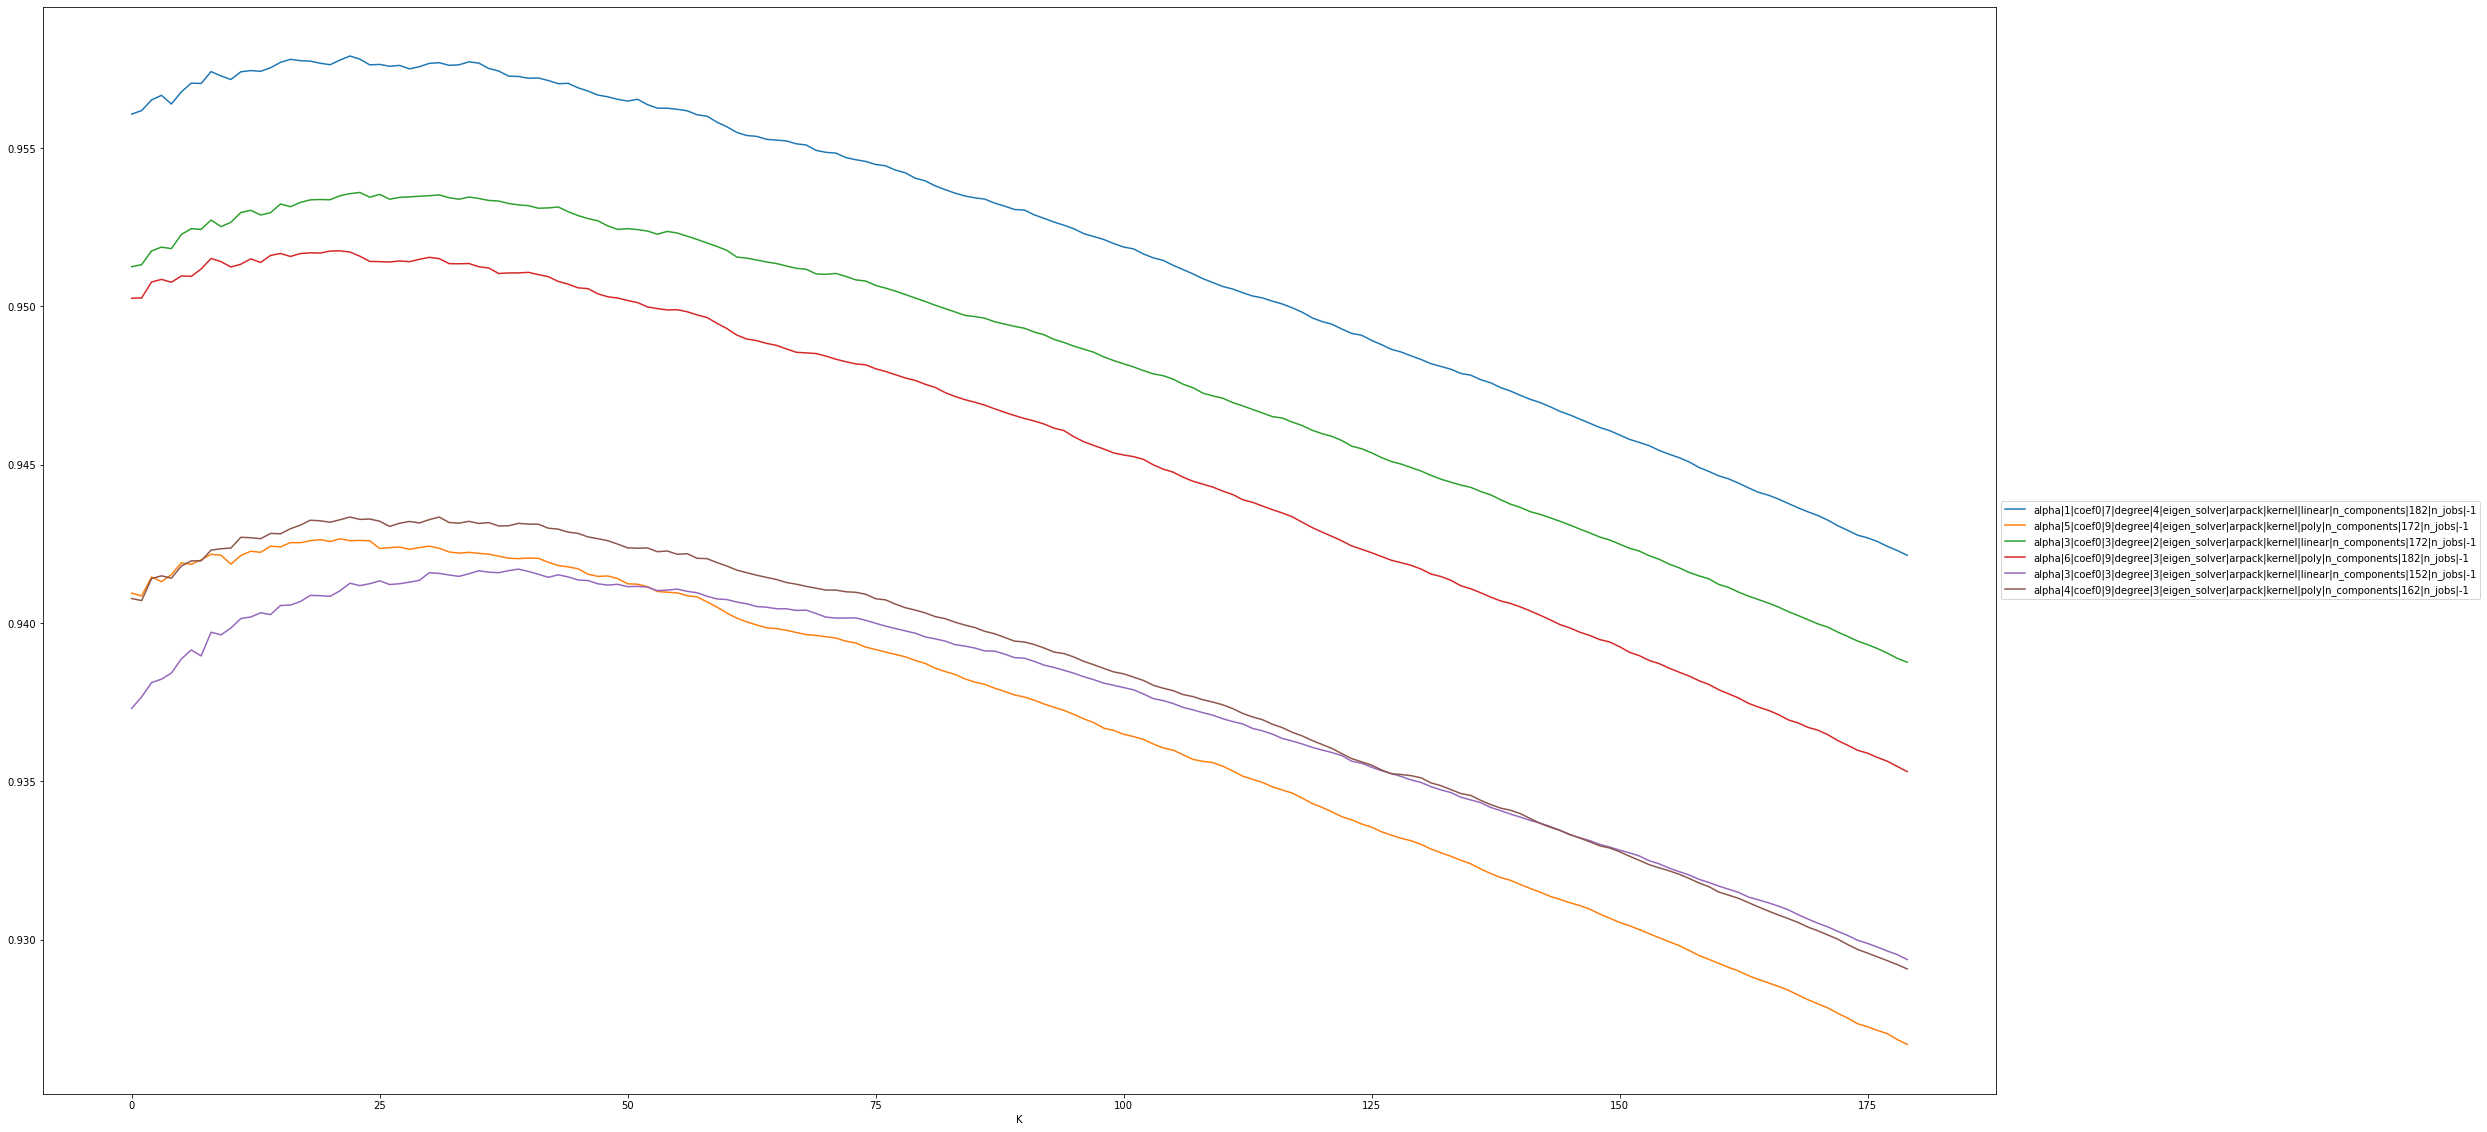

In [31]:
i =0

for  label,g in graphs.items():
    if g['LCMC'].max() > .94:
        if i == 0:
            print(i)
            ax = g.plot(y = 'LCMC',x ='K', label = re.sub("\s\s+", "|", label),figsize=(35,20))
        else:
            print(i)
            g.plot(y = 'LCMC',x ='K',  label = re.sub("\s\s+", "|", label), ax = ax)
        i += 1
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('LCMC_Kernel_PCA')
plt.show()

In [30]:
kpca = KernelPCA(n_components = 182,alpha =1, coef0=7, degree = 4, eigen_solver = 'arpack', kernel = 'linear')
KPCA = kpca.fit(num_train_x[:31240])
KPCA_train_x = np.array([[]])
KPCA_test_x = np.array([[]])
train_splits = len(num_train_x)//20
test_splits = len(num_test_x)//10
KPCA_train_x = []
for i in range(20):
    print(i)
    if i == 19:
         t_x = client.scatter(num_train_x[i*train_splits:], direct = True, workers = workers[i%30])
    else:
        t_x = client.scatter(num_train_x[i*train_splits:(i+1)*train_splits], direct = True, workers = workers[i%30])
    if i == 0:
        KPCA_train_x.append(client.submit(KPCA.transform, t_x, workers = workers[i%30]))
       # KPCA_test_x =  KPCA.transform(num_test_x[i*test_splits:(i+1)*test_splits])
    else:
        KPCA_train_x.append(client.submit(KPCA.transform,t_x, workers = workers[i%30]))
       # KPCA_test_x = np.append(KPCA_test_x, KPCA.transform(num_test_x[i*test_splits:(i+1)*test_splits]),axis = 0)
KPCA_train_x = client.gather(KPCA_train_x, direct = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [31]:
k = np.array([[]])
j = 0
for i in KPCA_train_x:
    if j == 0:
        k = np.array(i)
    else:
        k = np.append(k, i, axis = 0)
    j+= 1
KPCA_train_x = k
KPCA_train_x.shape

(360490, 182)

In [32]:
params = [{
    
    "n_estimators": range(200,1001,100),
    "min_samples_split" : range(2,20, 2),
    "max_leaf_nodes" : range(90,151,8),
    "max_depth": range(10,41, 4),
    "min_samples_leaf":range(5,30,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,30,2),
    "criterion" : ['mse']
}]

model = RandomForestRegressor

h = tune_dask_kfold(model,KPCA_train_x, num_train_y,num_train_era, client,30, params,60)


h

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_depth': 18, 'max_features': 15, 'max_leaf_nodes': 106, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 14, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_depth': 38, 'max_features': 15, 'max_leaf_nodes': 98, 'max_samples': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 700, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_depth': 30, 'max_features': 15, 'max_leaf_nodes': 130, 'max_samples': 0.5, 'min_samples_leaf': 11, 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_depth': 34, 'max_features': 5, 'max_leaf_nodes': 122, 'max_samples': 0.600000

KeyboardInterrupt: 

In [44]:
h.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
41        mse         38             9             106          0.7   
115       mse         34             7             122          0.7   
109       mse         18             9              98          0.7   
56        mse         30             9             106          0.7   
33        mse         26            11             106          0.9   
..        ...        ...           ...             ...          ...   
98        mse         18             1             106          0.7   
79        mse         18             3             146          0.5   
29        mse         38             1             122          0.8   
59        mse         30             1             146          0.9   
108       mse         26             1              90          0.5   

     min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
41                 27                  8          1000      -1            42   
115                23                 16           800      -1            42   
109                25                  4           900      -1            42   
56                  9                 10           800      -1            42   
33                 23                 10           900      -1            42   
..                ...                ...           ...     ...           ...   
98                 27                  4           500      -1            42   
79                 19                 14           200      -1            42   
29                 17                  6           400      -1            42   
59                  5                  4           200      -1            42   
108                17                 12           200      -1            42   

     verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
41         0                        0.053319            0.026434  
115        0                        0.053066            0.026437  
109        0                        0.052569            0.026435  
56         0                        0.052333            0.026434  
33         0                        0.052170            0.026432  
..       ...                             ...                 ...  
98         0                        0.038868            0.026466  
79         0                        0.038473            0.026452  
29         0                        0.036203            0.026466  
59         0                        0.033687            0.026465  
108        0                        0.028783            0.026469  

[120 rows x 13 columns]

In [38]:
h.sort_values(by= ['Quartic Mean Error'])

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
14        mse         22            27             122          0.9   
16        mse         18            27             122          0.7   
2         mse         14            27             122          0.6   
89        mse         18            29             130          0.6   
90        mse         14            23             114          0.7   
..        ...        ...           ...             ...          ...   
29        mse         38             1             122          0.8   
98        mse         18             1             106          0.7   
68        mse         10             1             122          0.9   
32        mse         10             1             122          0.9   
108       mse         26             1              90          0.5   

     min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
14                 23                  6           600      -1            42   
16                 27                 14           400      -1            42   
2                   9                 12          1000      -1            42   
89                  7                  2           600      -1            42   
90                 11                  2           600      -1            42   
..                ...                ...           ...     ...           ...   
29                 17                  6           400      -1            42   
98                 27                  4           500      -1            42   
68                 13                 12           400      -1            42   
32                 23                  2           600      -1            42   
108                17                 12           200      -1            42   

     verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
14         0                        0.049224            0.026421  
16         0                        0.048209            0.026422  
2          0                        0.049439            0.026422  
89         0                        0.047900            0.026422  
90         0                        0.049204            0.026423  
..       ...                             ...                 ...  
29         0                        0.036203            0.026466  
98         0                        0.038868            0.026466  
68         0                        0.040155            0.026467  
32         0                        0.040841            0.026468  
108        0                        0.028783            0.026469  

[120 rows x 13 columns]

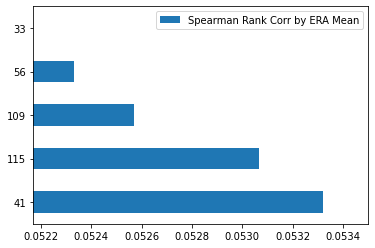

In [48]:
h[h['Spearman Rank Corr by ERA Mean']>.0521].sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False).plot(xlim = [.05217,.0535],y=['Spearman Rank Corr by ERA Mean'],kind= 'barh')

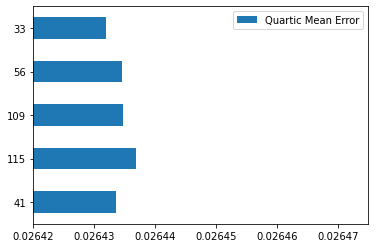

In [46]:
h[h['Spearman Rank Corr by ERA Mean']>.0521].sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False).plot(xlim = [.02642,.026475],y=['Quartic Mean Error'],kind= 'barh')

In [25]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 900,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 1, 
                               n_jobs=-1, 
                               max_leaf_nodes= 106,
                               max_samples = .9, 
                               min_samples_leaf = 17, 
                               min_samples_split = 16 )

In [26]:
spearman, qme = kfold_dask(10, KPCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "KPCA - 152", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
3 0 7
10
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  \
0           PCA(n=52)                        0.039713   

   Confidence Interval 2.5%  Confidence Interval 97.5%  
0                   0.02881                   0.050617

# SHAP on KPCA


In [27]:
shap.initjs()









In [25]:
model = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =450,
                               max_depth=23,
                               verbose = 2,
                               max_features= 39, 
                               n_jobs=-1,
                               max_leaf_nodes=740,
                               #max_samples = .8, 
                               min_samples_leaf = 37, 
                               min_samples_split = 4)
explainer = shap.TreeExplainer(model.fit(KPCA_train_x, num_train_y), data = KPCA_train_x[:1000])
shap_values = explainer.shap_values(KPCA_train_x[:1000])
#force_plot = shap.force_plot(explainer.expected_value, shap_values, num_train_x[:1000])
#shap.save_html(out_file = 'Benchmark SHAP Values', plot_html=force_plot, full_html=False)


NameError: name 'KPCA_train_x' is not defined

In [29]:
shap_values.shape

(1000, 182)

In [30]:
shap_val = pd.DataFrame({'Feature':range(182),'Score':np.abs(shap_values).mean(axis = 0)})
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('SHAP_KPCA')
shap_val

Feature     Score
44        44  0.003966
8          8  0.002984
7          7  0.002554
13        13  0.001501
27        27  0.001304
..       ...       ...
70        70  0.000089
155      155  0.000088
113      113  0.000085
77        77  0.000085
145      145  0.000084

[182 rows x 2 columns]

In [33]:
shap_val = pd.read_csv('SHAP_KPCA').iloc[:,1:]
shap_val.set_index(shap_val.Feature, inplace = True)
shap_val

Feature     Score
Feature                   
44            44  0.003966
8              8  0.002984
7              7  0.002554
13            13  0.001501
27            27  0.001304
...          ...       ...
70            70  0.000089
155          155  0.000088
113          113  0.000085
77            77  0.000085
145          145  0.000084

[182 rows x 2 columns]

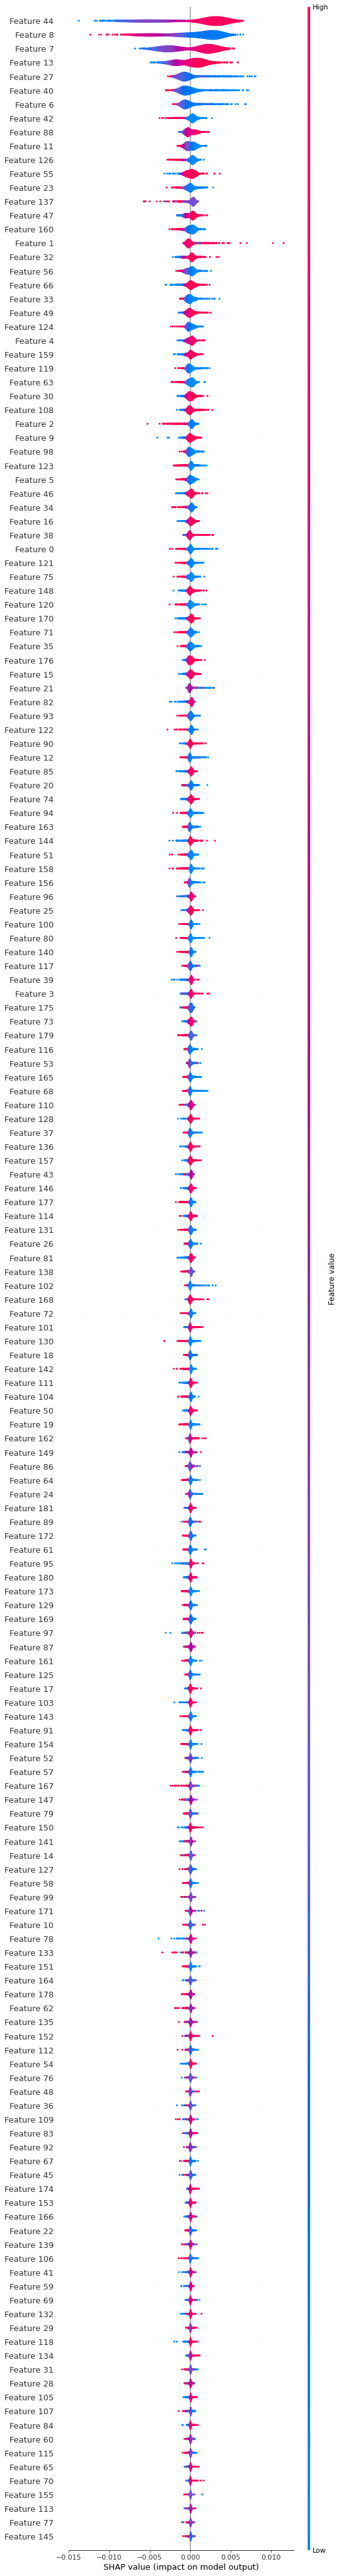

NameError: name 'violin_plot' is not defined

In [32]:
fig = plt.figure()

violnum_col_names= shap.summary_plot(shap_values, KPCA_train_x[:1000], max_display = 182,plot_type ='violin')
fig.savefig("violin_KPCA.png", bbox_inches='tight', dpi=200)
violin_plot

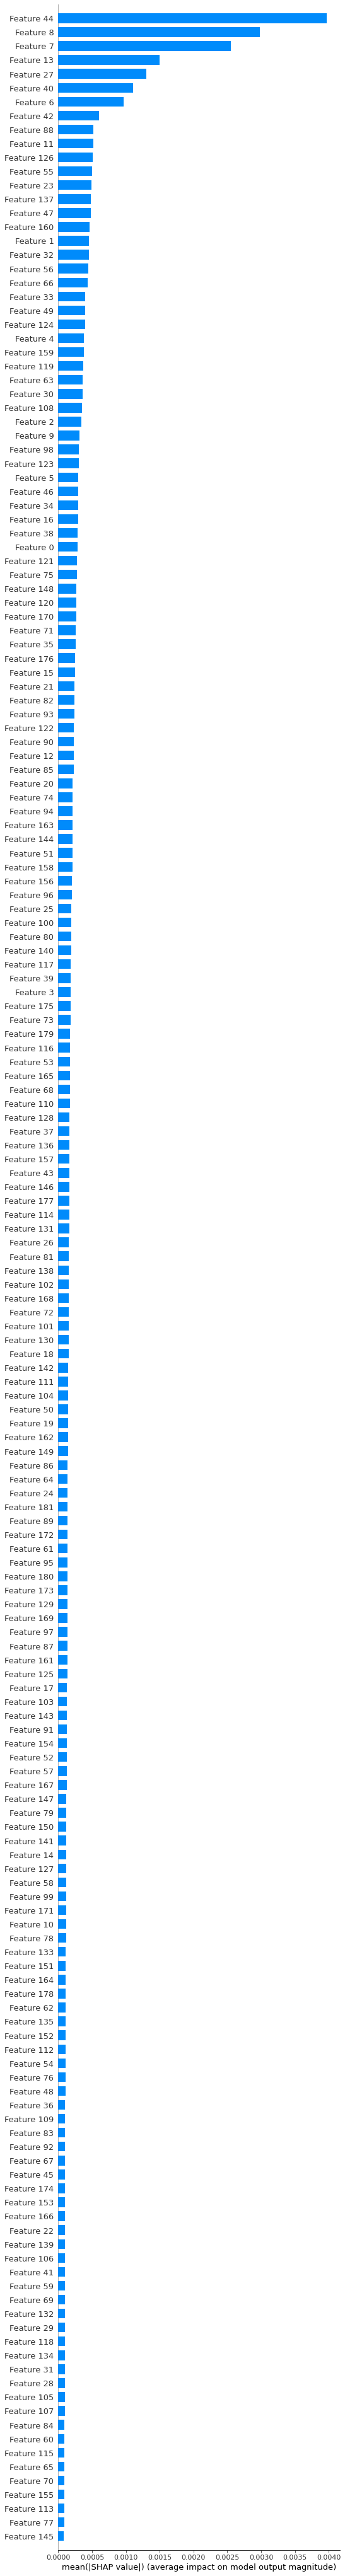

In [33]:
fig = plt.figure()

shap.summary_plot(shap_values,KPCA_train_x[:1000], plot_type="bar", max_display = 182)
fig.savefig("mean_SHAP_KPCA.png", bbox_inches='tight', dpi=200)


In [34]:
s = SHAP_tune(KPCA_train_x,num_train_y,num_train_era,120, shap_val, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]

s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
SHAP_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
SHAP_tune_results.sort_values('Spearman Rank', ascending = False)

Int64Index([0, 1], dtype='int64')
Int64Index([0, 1, 2], dtype='int64')
Int64Index([0, 1, 2, 3], dtype='int64')
Int64Index([0, 1, 2, 3, 4], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
56       0.040601   0.030155    0.051047  0.026437     0.026418      0.026457
46       0.040304   0.029774    0.050835  0.026437     0.026415      0.026459
64       0.040216   0.029210    0.051222  0.026441     0.026421      0.026460
75       0.040090   0.029353    0.050828  0.026442     0.026424      0.026460
62       0.039973   0.028711    0.051234  0.026439     0.026420      0.026459
..            ...        ...         ...       ...          ...           ...
3        0.013354   0.009696    0.017013  0.026508     0.026480      0.026536
4        0.013076   0.008716    0.017435  0.026504     0.026476      0.026533
2        0.012561   0.008552    0.016570  0.026516     0.026489      0.026544
1        0.009617   0.006332    0.012903  0.026528     0.026502      0.026553
0        0.001770  -0.003022    0.006561  0.026536     0.026509      0.026563

[118 rows x 6 columns]

In [37]:
rel_col = (shap_val.sort_values('Score', ascending = False).iloc[:58,:]).index
SHAP_Dataset =  KPCA_train_x[:,rel_col]

SHAP_train_x   =SHAP_Dataset[:400000,:]
SHAP_test_x =SHAP_Dataset[400000:,:]
SHAP_train_x.shape

(360490, 58)

In [40]:
params = [{
    
    "n_estimators": range(500,1001,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,10,1),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,SHAP_train_x, num_train_y,num_train_era, client,15, params, 50)

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
Done Scattering
{'criterion': 'mse', 'max_depth': 42, 'max_features': 9, 'max_leaf_nodes': 432, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 27, 'min_samples_split': 2, 'n_estimators': 975, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
3
6
9
12
{'criterion': 'mse', 'max_depth': 42, 'max_features': 6, 'max_leaf_nodes': 392, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 11, 'min_samples_split': 2, 'n_estimators': 525, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
4
7
10
13
{'criterion': 'mse', 'max_depth': 34, 'max_features': 5, 'max_leaf_nodes': 512, 'max_samples': 0.5, 'min_samples_leaf': 13, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
5
8
11
14
{'criterion': 'mse', 'max_depth': 38, 'max_features': 6, 'max_leaf_nodes': 432, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 27, 'min_samples_split': 4, 'n_estimator

AttributeError: 'DummyProcess' object has no attribute 'terminate'

In [ ]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [38]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 1000,
                               max_depth= 38,
                               verbose = 0,
                               max_features= 8, 
                               n_jobs=-1, 
                               max_leaf_nodes= 3,
                               max_samples = .6, 
                               min_samples_leaf =27, 
                               min_samples_split = 6)

In [41]:
spearman, qme = kfold_dask(10, SHAP_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 29)
redux_race = redux_race.append({"Reduction Technique": "SHAP - 54", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
1 0 9
95
2 0 8
100
2 0 8
105
2 0 8
110
2 0 8
115
2 0 8
120
2 0 8
125
3 0 7
130
3 0 7
135
4 0 6
140
4 0 6
145
4 0 6
150
4 0 6
155
5 0 5
160
8 0 2
165
8 0 2
170
9 0 1
175
9 0 1
180
9 0 1
185
9 0 1
190
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0           SHAP - 54                        0.035031   0.027215    0.042848   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026462   0.026442    0.026482

## MDA done on Kernel PCA

In [49]:
scores = MDA(KPCA_train_x, num_train_y,num_train_era, client,60)
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])


0 0 60
0
0 0 60
5
0 0 60
10
59 0 1
15
60 0 0
['tcp://10.128.0.119:43745', 'tcp://10.128.0.120:43681']
['tcp://10.128.0.120:43681', 'tcp://10.128.0.121:34045']
['tcp://10.128.0.121:34045', 'tcp://10.128.0.122:43111']
['tcp://10.128.0.122:43111', 'tcp://10.128.0.12:45489']
['tcp://10.128.0.12:45489', 'tcp://10.128.0.13:44723']
['tcp://10.128.0.13:44723', 'tcp://10.128.0.14:33037']
['tcp://10.128.0.14:33037', 'tcp://10.128.0.156:35979']
['tcp://10.128.0.156:35979', 'tcp://10.128.0.157:44883']
['tcp://10.128.0.157:44883', 'tcp://10.128.0.158:33163']
['tcp://10.128.0.158:33163', 'tcp://10.128.0.159:40451']
['tcp://10.128.0.159:40451', 'tcp://10.128.0.15:39489']
['tcp://10.128.0.15:39489', 'tcp://10.128.0.163:37949']
['tcp://10.128.0.163:37949', 'tcp://10.128.0.164:42757']
['tcp://10.128.0.164:42757', 'tcp://10.128.0.165:40495']
['tcp://10.128.0.165:40495', 'tcp://10.128.0.166:46505']
['tcp://10.128.0.166:46505', 'tcp://10.128.0.16:34937']
['tcp://10.128.0.16:34937', 'tcp://10.128.0.173:4023

In [50]:
feat_score.to_csv('MDA_On_KPCA')

In [51]:
scores = pd.read_csv('MDA_On_KPCA')

In [52]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score['Feature'] = feat_score['Feature'].apply(lambda x: str(x.strip("]['")))
MDA_mean = np.mean(feat_score.Score)
MDA_std = np.std(feat_score.Score)
feat_score

Score Feature
0    0.006223      44
1    0.005619       8
2    0.003149       7
3    0.002316      13
4    0.001766      40
..        ...     ...
177 -0.000350     152
178 -0.000373     155
179 -0.000383     172
180 -0.000468     153
181 -0.000521     115

[182 rows x 2 columns]

In [39]:
s = MDA_tune(KPCA_train_x,num_train_y,num_train_era,100, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

6 0 4
0
7 0 3
5
8 0 2
10
9 0 1
15
10 0 0
0
0 0 10
0
0 0 10
5
10 0 0
1
0 0 10
0
0 0 10
5
10 0 0
2
0 0 10
0
0 0 10
5
10 0 0
3
0 0 10
0
0 0 10
5
10 0 0
4
0 0 10
0
0 0 10
5
10 0 0
5
0 0 10
0
0 0 10
5
10 0 0
6
0 0 10
0
0 0 10
5
10 0 0
7
0 0 10
0
0 0 10
5
10 0 0
8
0 0 10
0
0 0 10
5
10 0 0
9
0 0 10
0
0 0 10
5
10 0 0
10
0 0 10
0
0 0 10
5
10 0 0
11
0 0 10
0
0 0 10
5
10 0 0
12
0 0 10
0
0 0 10
5
10 0 0
13
0 0 10
0
0 0 10
5
9 0 1
10
10 0 0
14
0 0 10
0
0 0 10
5
10 0 0
15
0 0 10
0
0 0 10
5
10 0 0
16
0 0 10
0
0 0 10
5
10 0 0
17
0 0 10
0
0 0 10
5
10 0 0
18
0 0 10
0
0 0 10
5
10 0 0
19
0 0 10
0
0 0 10
5
10 0 0
20
0 0 10
0
0 0 10
5
10 0 0
21
0 0 10
0
0 0 10
5
10 0 0
22
0 0 10
0
0 0 10
5
10 0 0
23
0 0 10
0
0 0 10
5
10 0 0
24
0 0 10
0
0 0 10
5
10 0 0
25
0 0 10
0
0 0 10
5
10 0 0
26
0 0 10
0
0 0 10
5
10 0 0
27
0 0 10
0
0 0 10
5
10 0 0
28
0 0 10
0
0 0 10
5
10 0 0
29
0 0 10
0
0 0 10
5
10 0 0
30
0 0 10
0
0 0 10
5
10 0 0
31
0 0 10
0
0 0 10
5
10 0 0
32
0 0 10
0
0 0 10
5
10 0 0
33
0 0 10
0
0 0 10
5
10 0 0
34
0 0 1

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
81       0.042745   0.031101    0.054389  0.026439     0.026420      0.026458
79       0.042702   0.030614    0.054789  0.026439     0.026420      0.026458
92       0.042629   0.031695    0.053563  0.026440     0.026421      0.026459
85       0.042584   0.031095    0.054073  0.026438     0.026420      0.026457
77       0.042549   0.031416    0.053681  0.026438     0.026418      0.026458
..            ...        ...         ...       ...          ...           ...
4        0.032097   0.025608    0.038585  0.026477     0.026454      0.026500
3        0.030241   0.023002    0.037481  0.026483     0.026457      0.026509
2        0.028726   0.023370    0.034083  0.026490     0.026469      0.026512
1        0.025152   0.019929    0.030374  0.026502     0.026483      0.026521
0        0.023858   0.018756    0.028960  0.026509     0.026488      0.026529

[98 rows x 6 columns]

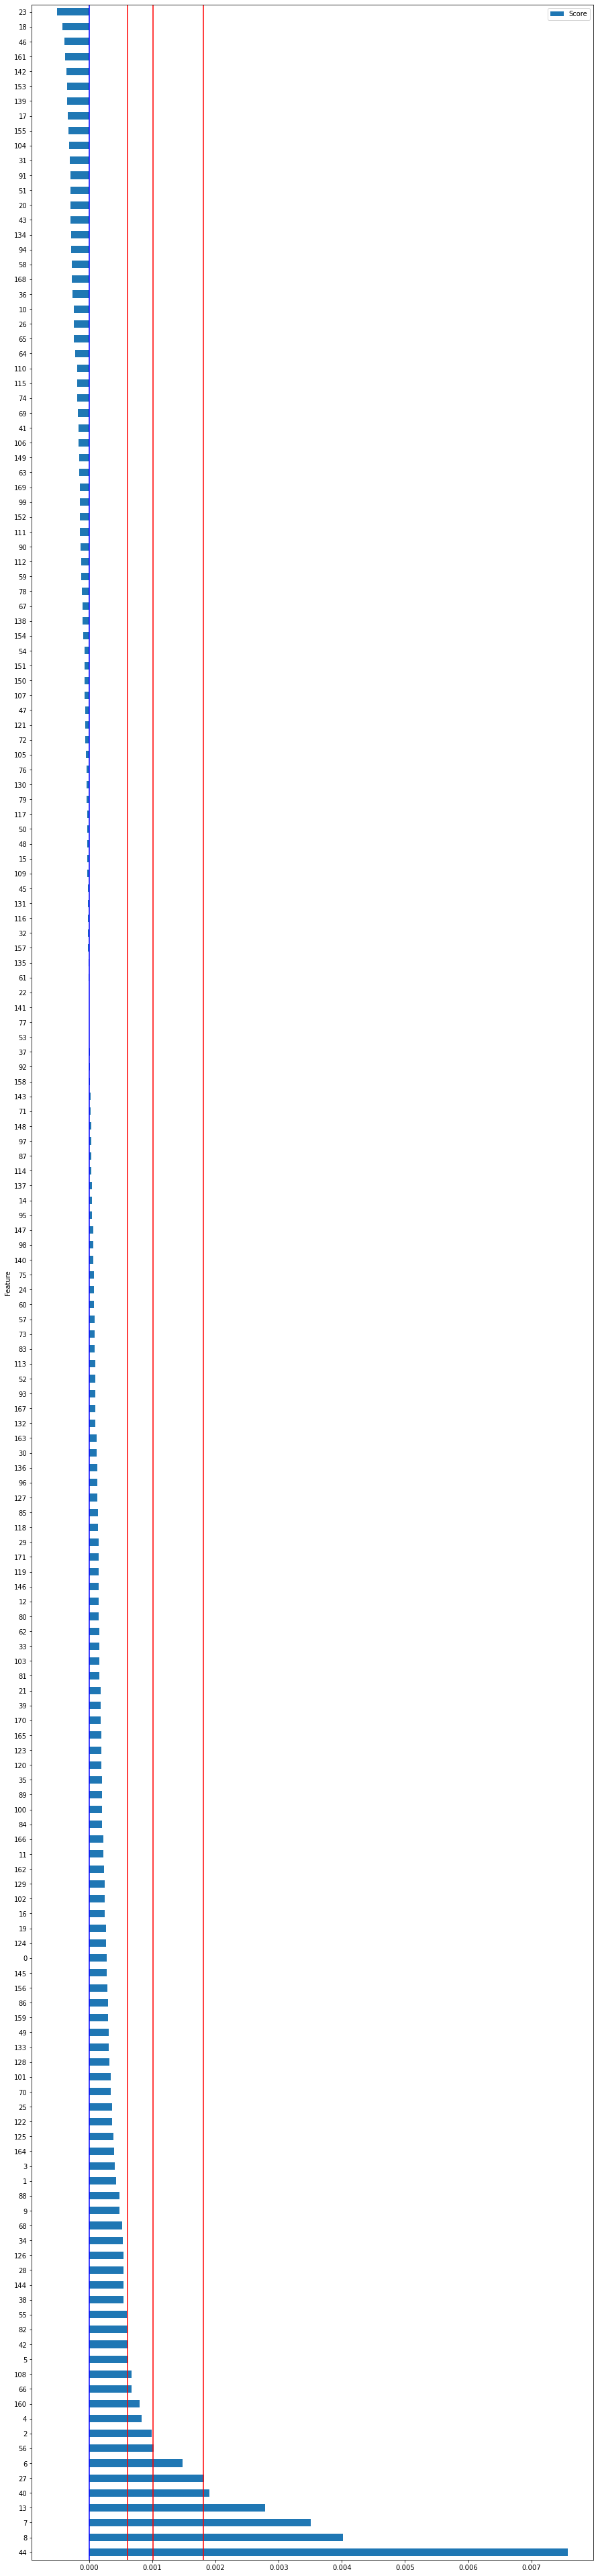

In [32]:
#use above mean for the features 
rel_col = (feat_score.sort_values('Score', ascending = False).iloc[:81,:]).Feature
MDA_Dataset = pd.DataFrame(KPCA_train_x)[rel_col.astype(int)]

MDA_KPCA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_KPCA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,70))
plt.axvline(x = float(MDA_mean + 2* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + 1* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + .5* MDA_std), color = 'r')


plt.axvline(x= 0, color = 'b')
plt.savefig('MDA_on_PCA_Barh')

## Random Forest AUC-ROC | MDA on KPCA


In [33]:
rel_col = (feat_score.sort_values('Score', ascending = False).iloc[:81,:]).Feature
rel_col = rel_col.apply(lambda x: int(x.strip('[]').split("' '")[0]))
MDA_Dataset = pd.DataFrame(KPCA_train_x).iloc[:,rel_col]

MDA_KPCA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_KPCA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_KPCA_train_x.shape

(360490, 81)

In [39]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,16,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_KPCA_train_x, num_train_y, num_train_era, client,30, params, 100)

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_features': 2, 'max_leaf_nodes': 164, 'max_samples': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 950, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_features': 4, 'max_leaf_nodes': 116, 'max_samples': 0.8, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 800, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_features': 12, 'max_leaf_nodes': 100, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 11, 'min_samples_split': 6, 'n_estimators': 1425, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_features': 12, 'max_leaf_nodes': 132, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 11, 'min_samples_split'

In [40]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
7        mse             4             228          0.8                33   
68       mse             4             140          0.7                39   
93       mse             4             188          0.6                33   
84       mse             8             204          0.5                21   
82       mse             4             108          0.8                37   
..       ...           ...             ...          ...               ...   
42       mse            14             148          0.8                15   
25       mse             2             212          0.8                11   
77       mse            14             140          0.7                21   
5        mse             2             116          0.9                19   
56       mse            14             100          0.9                11   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
7                   8          1300      -1            42        0   
68                  8           925      -1            42        0   
93                  4          1100      -1            42        0   
84                  6          1425      -1            42        0   
82                  2          1050      -1            42        0   
..                ...           ...     ...           ...      ...   
42                  4           925      -1            42        0   
25                  2           525      -1            42        0   
77                  8           650      -1            42        0   
5                   8           500      -1            42        0   
56                  8           550      -1            42        0   

    Spearman Rank Corr by ERA Mean  Quartic Mean Error  
7                         0.051798            0.026423  
68                        0.051470            0.026427  
93                        0.051404            0.026424  
84                        0.051248            0.026414  
82                        0.051241            0.026429  
..                             ...                 ...  
42                        0.047692            0.026420  
25                        0.047537            0.026440  
77                        0.047455            0.026420  
5                         0.047386            0.026445  
56                        0.046693            0.026422  

[100 rows x 12 columns]

In [42]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 1300,
                               max_depth= 38,
                               verbose = 0,
                               max_features=4, 
                               n_jobs=-1, 
                               max_leaf_nodes= 228,
                               max_samples = .8 , 
                               min_samples_leaf =33, 
                               min_samples_split =8)

In [43]:
spearman, qme = kfold_dask(10, MDA_KPCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "MDA KPCA - 81", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
1 0 9
50
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0       MDA KPCA - 81                        0.044368   0.036099    0.052637   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026429   0.026412    0.026446

## SVD on Numerai

In [76]:
num_train_era[num_train_era<12]

0         1
1         1
2         1
3         1
4         1
         ..
31235    11
31236    11
31237    11
31238    11
31239    11
Name: era, Length: 31240, dtype: int64

In [78]:
u, s, vh = np.linalg.svd(num_train_x[:31240])
s

array([1571.439816  ,  312.06898555,  281.68494621,  222.86249677,
        191.04050657,  187.6546491 ,  170.45712407,  163.36269251,
        147.38377113,  145.75640343,  141.52898319,  127.18815383,
        122.15732685,  116.25663041,  116.04085961,  113.53041945,
        111.75338119,  111.49255855,  110.70353936,  105.99715371,
        103.61057878,  102.09073275,  100.13588175,   98.99204864,
         97.91540558,   97.1603938 ,   95.31990833,   94.25145376,
         92.0505797 ,   91.01763103,   88.75576422,   88.33043832,
         87.92471566,   86.46247213,   85.76793673,   85.54188421,
         84.39193029,   83.63725798,   82.04727016,   81.67061633,
         80.73112458,   79.83089693,   78.74858108,   77.15985839,
         76.44644866,   76.09338747,   75.74162883,   75.30588308,
         73.93895107,   73.12146222,   70.36780373,   69.21416657,
         68.96690386,   68.18034635,   68.03770906,   67.34095539,
         66.32795618,   66.15977342,   65.78370685,   65.12953

# Scatterplot of eigenvalues from PCA

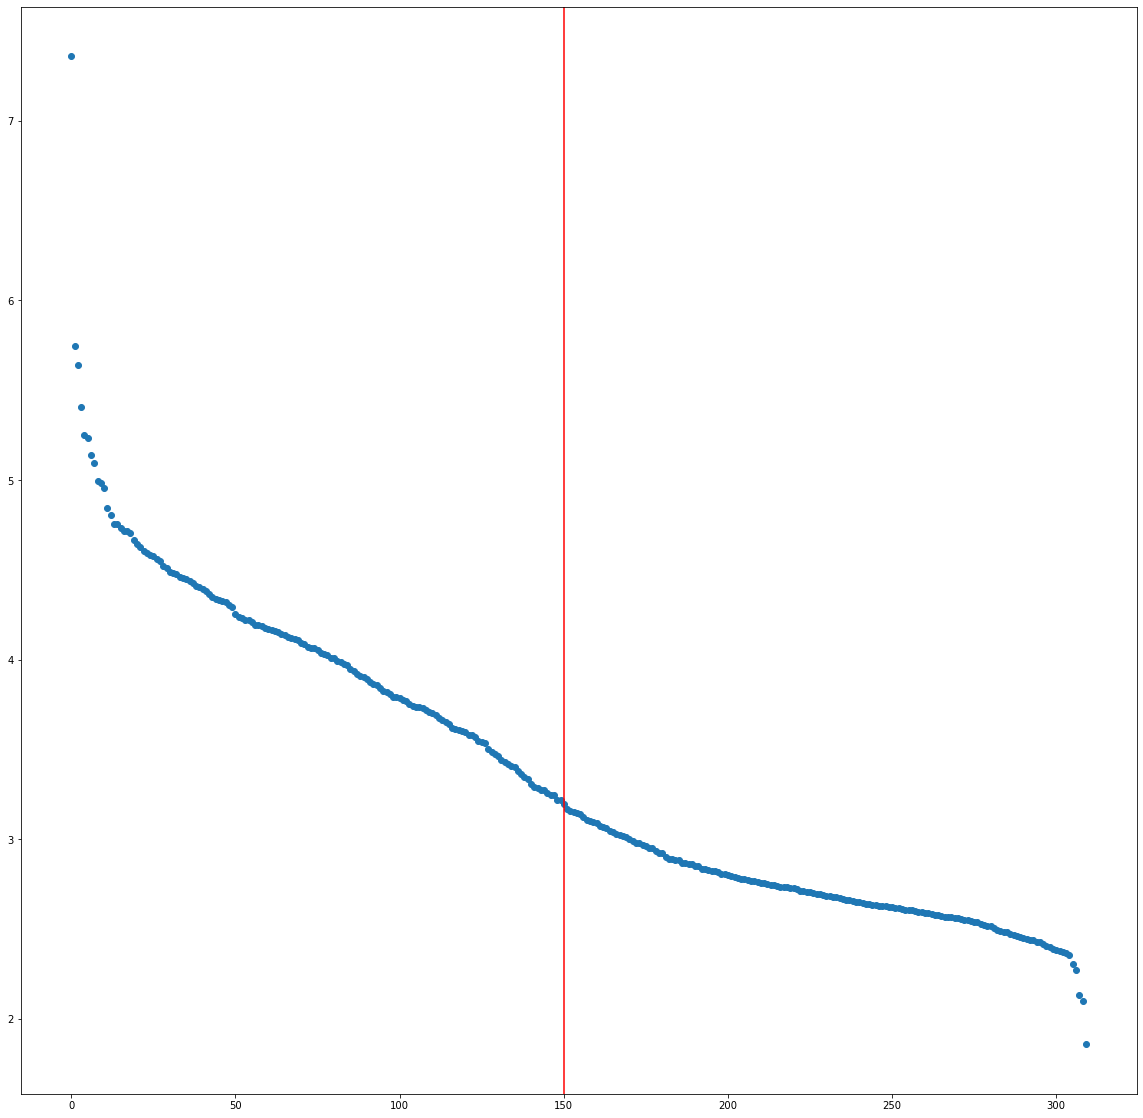

In [79]:
plt.figure(figsize=(20,20))
plt.scatter(y = np.log(s),x = range(310))
plt.axvline(150, color  = 'r')

## Random Forest AUC-ROC | IncrementalPCA


In [19]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 300,
                               max_depth= 14,
                               verbose = 0,
                               max_features= 25, 
                               n_jobs=-1, 
                               max_leaf_nodes= 130,
                               max_samples = .5, 
                               min_samples_leaf = 25, 
                               min_samples_split = 8 )

In [20]:
params = [{
          "batch_size":range(500,10000,100),
          "n_components":np.arange(50,250),
          "whiten": [False,True]

         
}]
pca =  IncrementalPCA
scores = pd.DataFrame()
graphs = dict()


PCA_tune, graph = tune_redux_corank_dask(pca,10,num_train_x,num_train_y,20,200,client, params,60,60)
 
scores = scores.append(PCA_tune, ignore_index = True)
scores.sort_values(by=['LCMC Max'],ascending = False)



0 0 60
0
0 0 60
5
0 0 60
10
0 0 60
15
42 0 18
20
56 0 4
25
58 0 2
30
59 0 1
35
60 0 0
gathered
[<Future: finished, type: numpy.ndarray, key: ndarray-def9b8a3196736d3c5f1f270e863dc9b>, <Future: finished, type: numpy.ndarray, key: ndarray-18aade324b2c04bf66f370caeb63964f>, <Future: finished, type: numpy.ndarray, key: ndarray-8ffa378301fde4e6df61cd4567ac0cc6>, <Future: finished, type: numpy.ndarray, key: ndarray-6585bc12302eb7badfe310c36b251d09>, <Future: finished, type: numpy.ndarray, key: ndarray-1dfed575a8a519bf7f73575b2782f021>, <Future: finished, type: numpy.ndarray, key: ndarray-9fcf94c1cbfe9b8dcbdc2138d33772f2>, <Future: finished, type: numpy.ndarray, key: ndarray-8406284cd3d3e848266828ad0949f07f>, <Future: finished, type: numpy.ndarray, key: ndarray-d2aaa89fcd1c75c96427ed7aab946d41>, <Future: finished, type: numpy.ndarray, key: ndarray-aedb1eb6c9735792b22842866915aa7d>, <Future: finished, type: numpy.ndarray, key: ndarray-22e24cbfc72dcf7726e60e091f9d9e8b>, <Future: finished, type:

batch_size  n_components  whiten  LCMC Max   K
55        2000           246   False  0.100396  20
48        3100           241   False  0.100290  20
31        1000           232   False  0.100064  20
26        2500           213   False  0.099540  20
27        6200           194   False  0.098906  20
52        6100           190   False  0.098772  20
4         7800           176   False  0.098199  20
53         500           172   False  0.097981  20
11        4300           169   False  0.097848  20
5         2800           163   False  0.097484  20
35        9800           162   False  0.097437  20
39        7600           158   False  0.097165  20
7         7400           153   False  0.096789  20
12        1600           140   False  0.095415  20
41        9700           129   False  0.093841  20
58        8700           123   False  0.092817  20
28        8300           116   False  0.091409  20
2          900           107   False  0.089091  20
25        2500            94   False  0.085214  20
49        7100            85   False  0.082466  20
14        9200            80   False  0.080584  20
6         5200            77   False  0.079344  20
17        5300            74   False  0.078048  20
44        4100            70   False  0.076261  20
56        5400            69   False  0.075741  20
29        9000            66   False  0.074226  20
18        4900            60   False  0.071181  20
34        1700            59   False  0.070708  20
16        6800            54   False  0.067830  20
0         2300            50   False  0.065502  20
40        4600            87    True  0.042489  20
50        3900            91    True  0.041752  20
59        1500            97    True  0.041308  20
57        1200           101    True  0.041256  20
51        7900           106    True  0.041196  20
22        2700           120    True  0.041084  20
47        5700           119    True  0.041059  20
9         4400           110    True  0.041046  20
45        8700           131    True  0.040765  20
8         6600           134    True  0.040644  20
13        3400           137    True  0.040552  20
36        9100           145    True  0.039925  20
43        6700           148    True  0.039837  20
21        5600           151    True  0.039708  20
24        3300           179    True  0.037921  20
33         600           183    True  0.037636  20
20        7200           186    True  0.037369  20
37        9400           188    True  0.037276  20
54        8400           196    True  0.036673  20
38        9500           203    True  0.036187  20
19        3500           205    True  0.036084  20
30        3700           207    True  0.035949  20
10        5000           216    True  0.035304  20
42        8200           217    True  0.035272  20
3         7300           220    True  0.035126  20
23        6400           224    True  0.034801  20
32        4000           229    True  0.034506  20
46        2100           235    True  0.034126  20
15        5800           237    True  0.033993  20
1         1300           243    True  0.033584  20

In [21]:
scores.sort_values(by = ['LCMC Max'], ascending = False)

batch_size  n_components  whiten  LCMC Max   K
55        2000           246   False  0.100396  20
48        3100           241   False  0.100290  20
31        1000           232   False  0.100064  20
26        2500           213   False  0.099540  20
27        6200           194   False  0.098906  20
52        6100           190   False  0.098772  20
4         7800           176   False  0.098199  20
53         500           172   False  0.097981  20
11        4300           169   False  0.097848  20
5         2800           163   False  0.097484  20
35        9800           162   False  0.097437  20
39        7600           158   False  0.097165  20
7         7400           153   False  0.096789  20
12        1600           140   False  0.095415  20
41        9700           129   False  0.093841  20
58        8700           123   False  0.092817  20
28        8300           116   False  0.091409  20
2          900           107   False  0.089091  20
25        2500            94   False  0.085214  20
49        7100            85   False  0.082466  20
14        9200            80   False  0.080584  20
6         5200            77   False  0.079344  20
17        5300            74   False  0.078048  20
44        4100            70   False  0.076261  20
56        5400            69   False  0.075741  20
29        9000            66   False  0.074226  20
18        4900            60   False  0.071181  20
34        1700            59   False  0.070708  20
16        6800            54   False  0.067830  20
0         2300            50   False  0.065502  20
40        4600            87    True  0.042489  20
50        3900            91    True  0.041752  20
59        1500            97    True  0.041308  20
57        1200           101    True  0.041256  20
51        7900           106    True  0.041196  20
22        2700           120    True  0.041084  20
47        5700           119    True  0.041059  20
9         4400           110    True  0.041046  20
45        8700           131    True  0.040765  20
8         6600           134    True  0.040644  20
13        3400           137    True  0.040552  20
36        9100           145    True  0.039925  20
43        6700           148    True  0.039837  20
21        5600           151    True  0.039708  20
24        3300           179    True  0.037921  20
33         600           183    True  0.037636  20
20        7200           186    True  0.037369  20
37        9400           188    True  0.037276  20
54        8400           196    True  0.036673  20
38        9500           203    True  0.036187  20
19        3500           205    True  0.036084  20
30        3700           207    True  0.035949  20
10        5000           216    True  0.035304  20
42        8200           217    True  0.035272  20
3         7300           220    True  0.035126  20
23        6400           224    True  0.034801  20
32        4000           229    True  0.034506  20
46        2100           235    True  0.034126  20
15        5800           237    True  0.033993  20
1         1300           243    True  0.033584  20

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


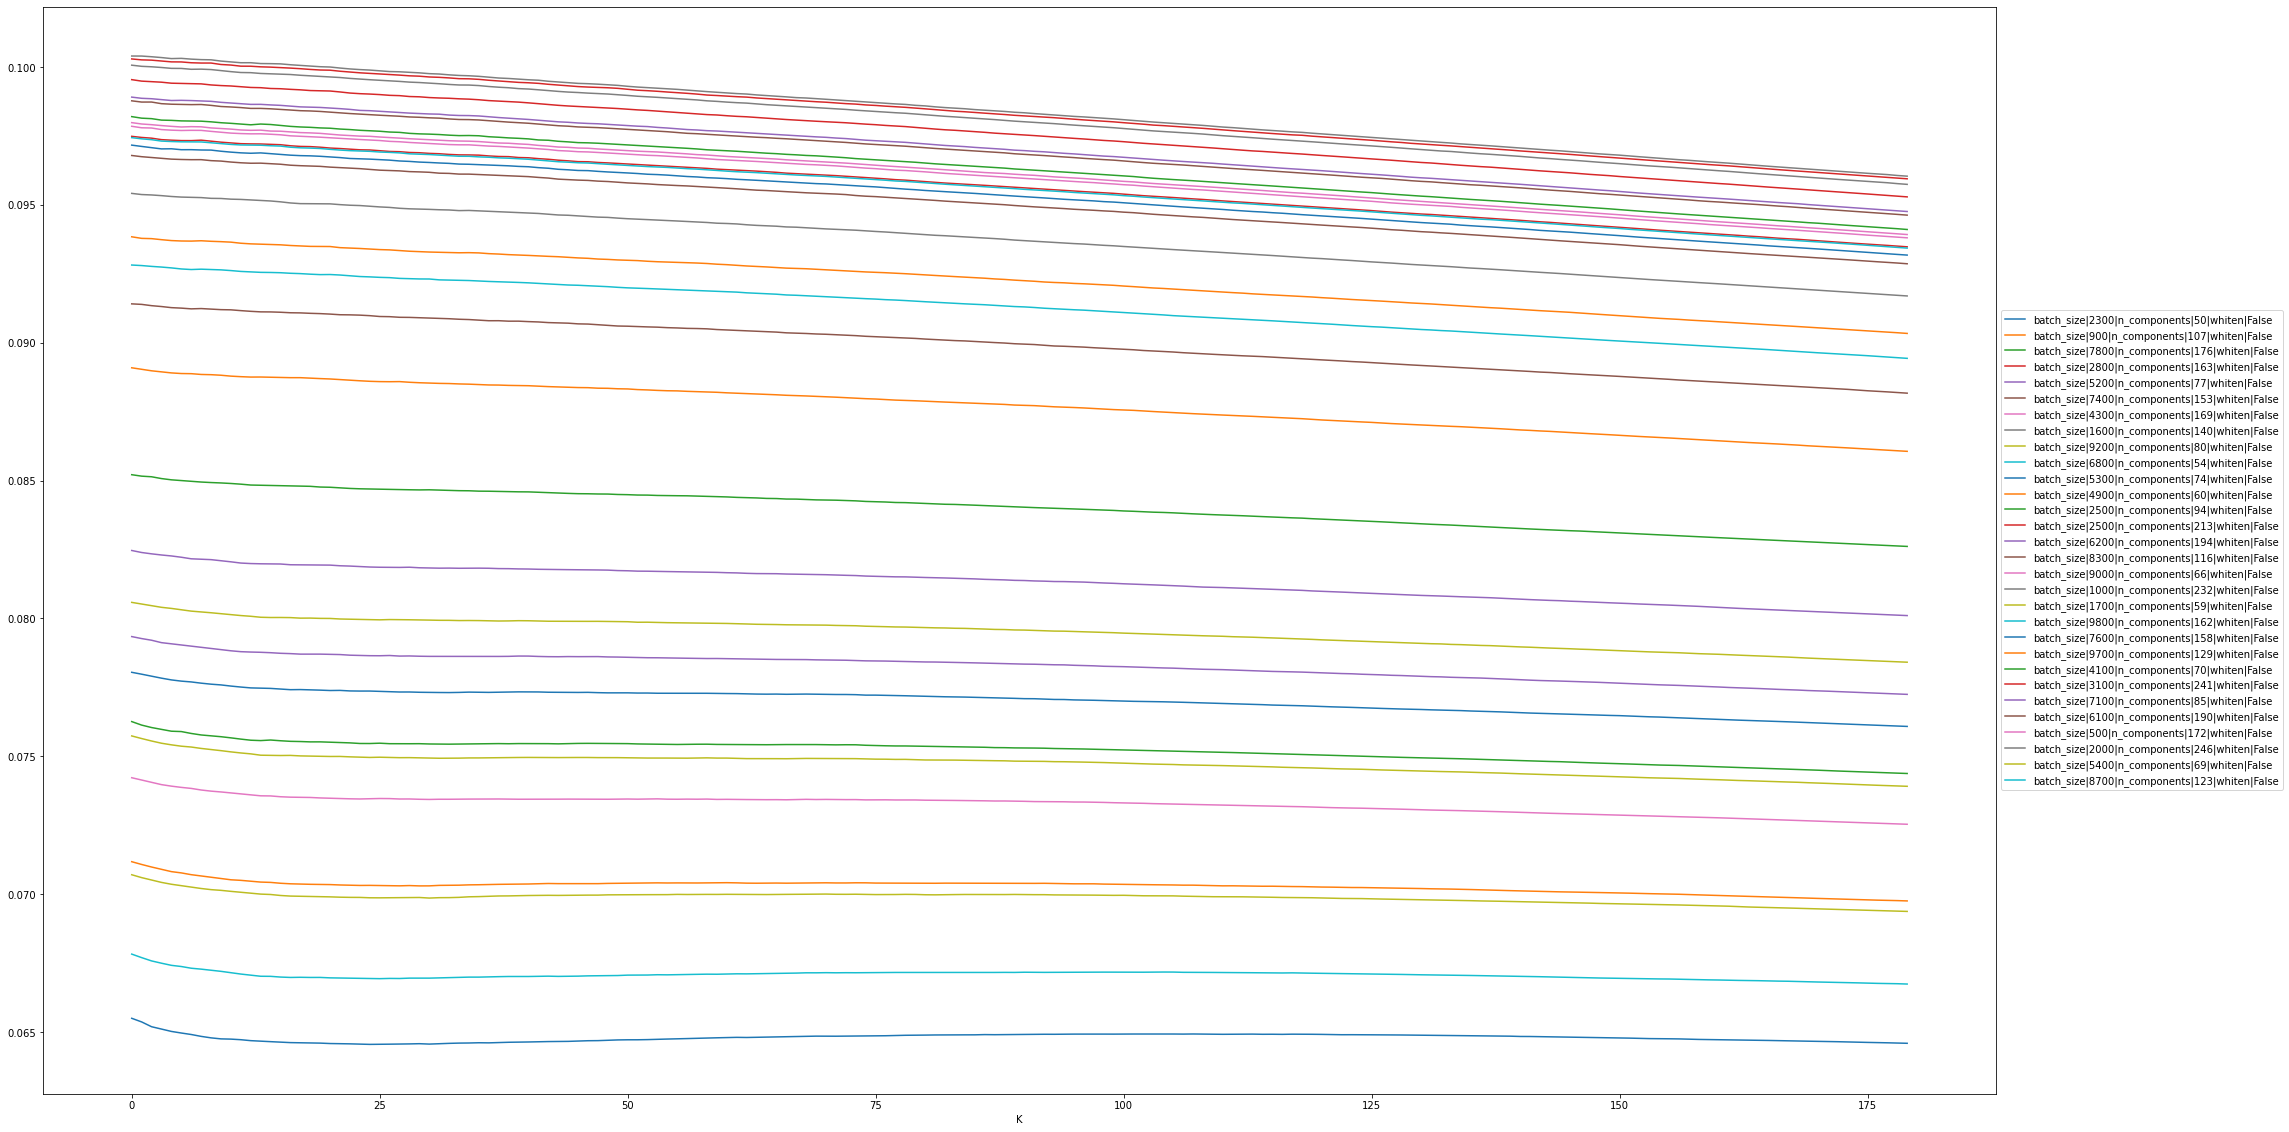

In [22]:
i =0

for  label,g in graph.items():
    if g['LCMC'].max() > .060:
        if i == 0:
            print(i)
            ax = g.plot(y = 'LCMC',x ='K', label = re.sub("\s\s+", "|", label),figsize=(35,20))
        else:
            print(i)
            g.plot(y = 'LCMC',x ='K',  label = re.sub("\s\s+", "|", label), ax = ax)
        i += 1
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('LCMC_PCA')
plt.show()

In [42]:
pca = PCA(n_components = 246, whiten = False)
PCA_train_x = pca.fit_transform(num_train_x)


In [ ]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,30,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,PCA_train_x, num_train_y, num_train_era, client,60, params, 100)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
Done Scattering
{'criterion': 'mse', 'max_features': 22, 'max_leaf_nodes': 244, 'max_samples': 0.5, 'min_samples_leaf': 29, 'min_samples_split': 4, 'n_estimators': 875, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
12
24
36
48
{'criterion': 'mse', 'max_features': 10, 'max_leaf_nodes': 156, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 19, 'min_samples_split': 8, 'n_estimators': 800, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
13
25
37
49
{'criterion': 'mse', 'max_features': 18, 'max_leaf_nodes': 132, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators

In [ ]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

In [105]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 1400,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 6, 
                               n_jobs=-1, 
                               max_leaf_nodes= 180,
                               max_samples = .7, 
                               min_samples_leaf = 25, 
                               min_samples_split = 4 )

In [40]:
spearman, qme = kfold_dask(10, PCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "PCA - 141 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

NameError: name '_train_x' is not defined

## Shapley Values on PCA

In [21]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 250,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 6, 
                               n_jobs=-1, 
                               max_leaf_nodes= 180,
                               max_samples = .7, 
                               min_samples_leaf = 25, 
                               min_samples_split = 4 )
explainer = shap.TreeExplainer(rf_hp.fit(PCA_train_x, num_train_y), data = PCA_train_x[:1000])
shap_values = explainer.shap_values(PCA_train_x[:1000])


100%|===================| 998/1000 [04:37<00:00]        

In [22]:
shap_val = pd.DataFrame({'Feature':range(246),'Score':np.abs(shap_values).mean(axis = 0)})
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('SHAP_PCA')
shap_val

Feature     Score
7          7  0.001302
49        49  0.000800
46        46  0.000571
24        24  0.000484
15        15  0.000453
..       ...       ...
234      234  0.000038
233      233  0.000038
191      191  0.000038
244      244  0.000037
190      190  0.000034

[246 rows x 2 columns]

In [43]:
shap_val = pd.read_csv('SHAP_PCA').iloc[:,1:]
shap_val.set_index(shap_val.Feature, inplace = True)
shap_val

Feature     Score
Feature                   
113          113  0.003642
71            71  0.003202
52            52  0.003111
70            70  0.002763
112          112  0.002543
...          ...       ...
45            45  0.000160
54            54  0.000158
127          127  0.000145
123          123  0.000137
1              1  0.000135

[130 rows x 2 columns]

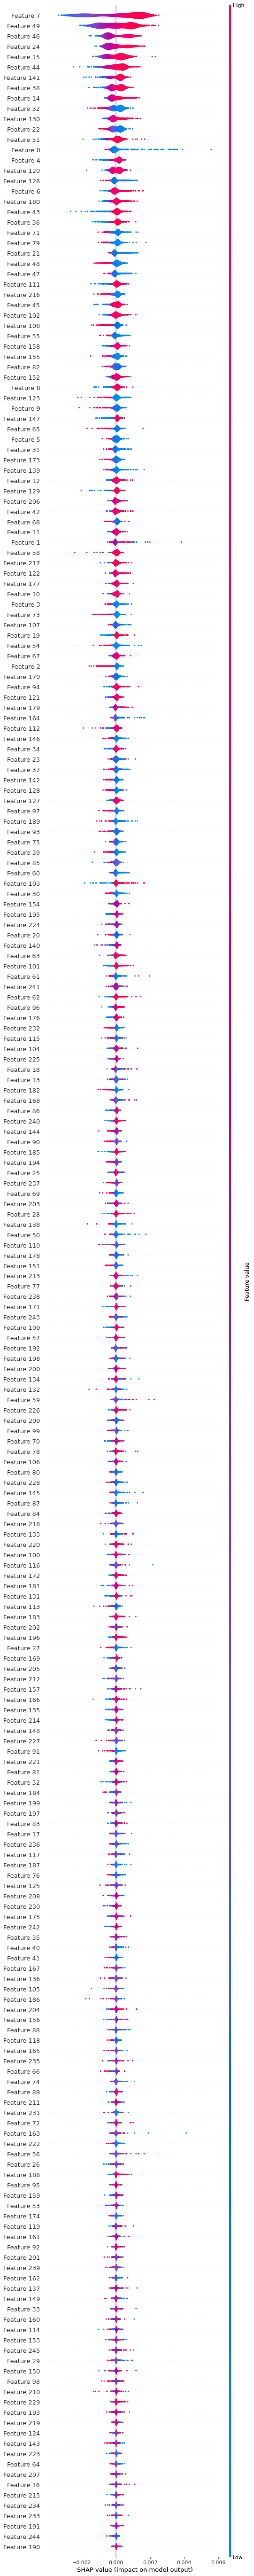

NameError: name 'violin_plot' is not defined

In [25]:
fig = plt.figure()

violnum_col_names= shap.summary_plot(shap_values, PCA_train_x[:1000], max_display = 246,plot_type ='violin')
fig.savefig("violin_PCA.png", bbox_inches='tight', dpi=200)
violin_plot

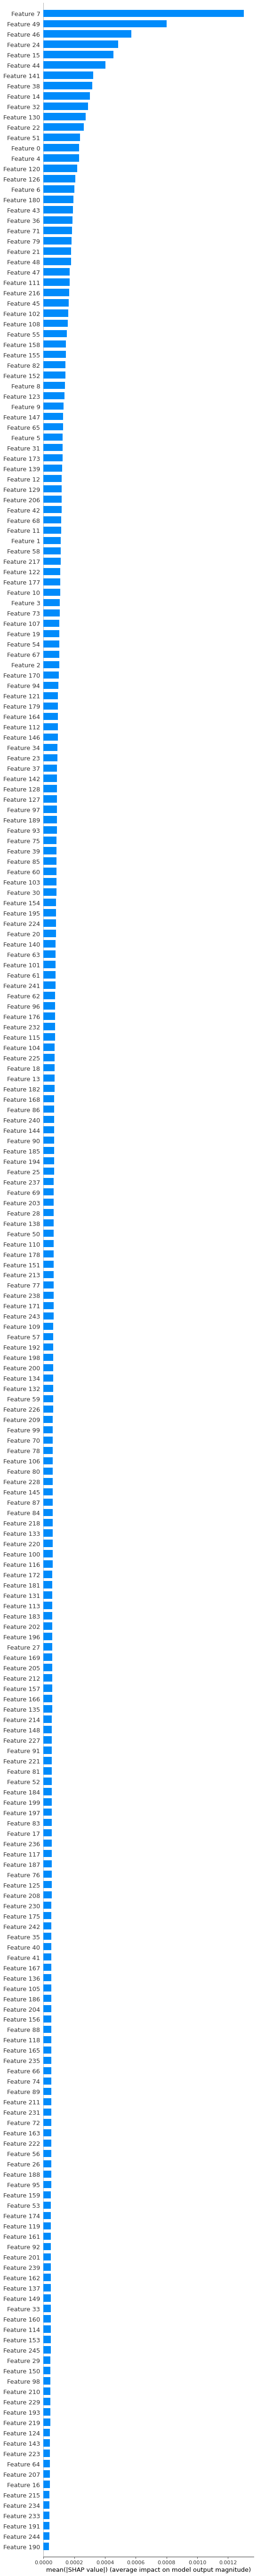

In [26]:
fig = plt.figure()

shap.summary_plot(shap_values,PCA_train_x[:1000], plot_type="bar", max_display = 246)
fig.savefig("mean_SHAP_PCA.png", bbox_inches='tight', dpi=200)


In [34]:
s = SHAP_tune(PCA_train_x,num_train_y,num_train_era,120, shap_val, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]

s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
SHAP_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
SHAP_tune_results.sort_values('Spearman Rank', ascending = False)

Int64Index([7, 49], dtype='int64', name='Feature')
Int64Index([7, 49, 46], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14, 32], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14, 32, 130], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14, 32, 130, 22], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14, 32, 130, 22, 51], dtype='int64', name='Feature')
Int64Index([7, 49, 46, 24, 15, 44, 141, 38, 14, 32, 130, 22, 51, 0], dtype='int64', name='Feature')
Int64Index([7,

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
70       0.045033   0.034923    0.055142  0.026434     0.026412      0.026456
72       0.044982   0.035813    0.054152  0.026434     0.026413      0.026455
56       0.044770   0.035563    0.053976  0.026430     0.026409      0.026450
65       0.044722   0.035654    0.053789  0.026432     0.026410      0.026455
62       0.044625   0.035560    0.053690  0.026432     0.026410      0.026453
..            ...        ...         ...       ...          ...           ...
4        0.030104   0.020667    0.039541  0.026476     0.026450      0.026502
3        0.027472   0.019319    0.035625  0.026486     0.026460      0.026512
2        0.026003   0.019165    0.032841  0.026493     0.026468      0.026517
1        0.024359   0.018748    0.029970  0.026500     0.026477      0.026523
0        0.022010   0.016480    0.027541  0.026509     0.026486      0.026532

[118 rows x 6 columns]

In [44]:
rel_col = (shap_val.sort_values('Score', ascending = False).iloc[:72,:]).index
SHAP_Dataset =  PCA_train_x[:,rel_col]

SHAP_train_x   =SHAP_Dataset[:400000,:]
SHAP_test_x =SHAP_Dataset[400000:,:]
SHAP_train_x.shape

(360490, 72)

In [36]:
params = [{
    
    "n_estimators": range(500,1001,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,10,1),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,SHAP_train_x, num_train_y,num_train_era, client,30, params, 100)

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_depth': 46, 'max_features': 2, 'max_leaf_nodes': 296, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 39, 'min_samples_split': 2, 'n_estimators': 650, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_depth': 46, 'max_features': 4, 'max_leaf_nodes': 368, 'max_samples': 0.8, 'min_samples_leaf': 35, 'min_samples_split': 4, 'n_estimators': 650, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_depth': 42, 'max_features': 8, 'max_leaf_nodes': 520, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_depth': 38, 'max_features': 1, 'max_leaf_nodes': 2

In [37]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
93       mse         30             7             488          0.7   
20       mse         42             7             520          0.7   
63       mse         50             7             376          0.7   
37       mse         34             9             344          0.7   
44       mse         30             5             472          0.9   
..       ...        ...           ...             ...          ...   
57       mse         34             1             344          0.6   
81       mse         46             1             288          0.7   
90       mse         46             1             200          0.8   
16       mse         38             1             472          0.7   
87       mse         46             1             536          0.8   

    min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
93                27                  2           900      -1            42   
20                27                  4           550      -1            42   
63                29                  4          1000      -1            42   
37                39                  2           525      -1            42   
44                21                  8           975      -1            42   
..               ...                ...           ...     ...           ...   
57                39                  6           575      -1            42   
81                35                  2           575      -1            42   
90                23                  2           525      -1            42   
16                15                  4           800      -1            42   
87                21                  4           575      -1            42   

    verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
93        0                        0.052941            0.026403  
20        0                        0.052297            0.026404  
63        0                        0.052102            0.026405  
37        0                        0.052044            0.026402  
44        0                        0.052041            0.026410  
..      ...                             ...                 ...  
57        0                        0.045189            0.026447  
81        0                        0.045154            0.026450  
90        0                        0.044364            0.026454  
16        0                        0.043400            0.026451  
87        0                        0.042719            0.026449  

[100 rows x 13 columns]

In [45]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 900,
                               max_depth= 30,
                               verbose = 0,
                               max_features= 7, 
                               n_jobs=-1, 
                               max_leaf_nodes= 488,
                               max_samples = .7, 
                               min_samples_leaf =27, 
                               min_samples_split = 2)

In [46]:
spearman, qme = kfold_dask(10, SHAP_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "SHAP - 72", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
1 0 9
60
1 0 9
65
1 0 9
70
1 0 9
75
2 0 8
80
2 0 8
85
2 0 8
90
2 0 8
95
2 0 8
100
2 0 8
105
2 0 8
110
2 0 8
115
2 0 8
120
2 0 8
125
2 0 8
130
2 0 8
135
2 0 8
140
2 0 8
145
2 0 8
150
2 0 8
155
2 0 8
160
2 0 8
165
2 0 8
170
2 0 8
175
3 0 7
180
3 0 7
185
3 0 7
190
3 0 7
195
3 0 7
200
3 0 7
205
3 0 7
210
4 0 6
215
4 0 6
220
4 0 6
225
6 0 4
230
6 0 4
235
6 0 4
240
6 0 4
245
6 0 4
250
6 0 4
255
6 0 4
260
6 0 4
265
6 0 4
270
7 0 3
275
7 0 3
280
7 0 3
285
7 0 3
290
7 0 3
295
7 0 3
300
8 0 2
305
8 0 2
310
9 0 1
315
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0           SHAP - 54                        0.035031   0.027215    0.042848   
1           SHAP - 72                        0.020570   0.013951    0.027189   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026462   0.026442    0.026482  
1            0.026470   0.026449    0.026491

## MDA done on Incremental PCA

In [50]:
scores = MDA(PCA_train_x, num_train_y,num_train_era, client,60)
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])


0 0 60
0
0 0 60
5
0 0 60
10
0 0 60
15
60 0 0
['tcp://10.128.0.100:44605', 'tcp://10.128.0.101:38513', 'tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763']
['tcp://10.128.0.101:38513', 'tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447']
['tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007']
['tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883']
['tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883', 'tcp://10.128.0.160:36915']
['tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883

In [51]:
feat_score.to_csv('MDA_On_PCA')

In [52]:
scores = pd.read_csv('MDA_On_PCA')

In [53]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score['Feature'] = feat_score['Feature'].apply(lambda x: str(x.strip("]['")))
MDA_mean = np.mean(feat_score.Score)
MDA_std = np.std(feat_score.Score)
feat_score

Score Feature
0    0.007158       7
1    0.003971      49
2    0.001511      46
3    0.001003      24
4    0.000937      32
..        ...     ...
241 -0.000427      10
242 -0.000453     204
243 -0.000494      23
244 -0.000515     217
245 -0.000587      34

[246 rows x 2 columns]

In [29]:
s = MDA_tune(PCA_train_x,num_train_y,num_train_era,100, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
0 0 10
5
10 0 0
0
0 0 10
0
0 0 10
5
10 0 0
1
0 0 10
0
0 0 10
5
10 0 0
2
0 0 10
0
0 0 10
5
10 0 0
3
0 0 10
0
0 0 10
5
10 0 0
4
0 0 10
0
0 0 10
5
10 0 0
5
0 0 10
0
0 0 10
5
10 0 0
6
0 0 10
0
0 0 10
5
10 0 0
7
0 0 10
0
0 0 10
5
10 0 0
8
0 0 10
0
0 0 10
5
10 0 0
9
0 0 10
0
0 0 10
5
10 0 0
10
0 0 10
0
0 0 10
5
10 0 0
11
0 0 10
0
0 0 10
5
10 0 0
12
0 0 10
0
0 0 10
5
10 0 0
13
0 0 10
0
0 0 10
5
10 0 0
14
0 0 10
0
0 0 10
5
10 0 0
15
0 0 10
0
0 0 10
5
10 0 0
16
0 0 10
0
0 0 10
5
10 0 0
17
0 0 10
0
0 0 10
5
10 0 0
18
0 0 10
0
0 0 10
5
10 0 0
19
0 0 10
0
0 0 10
5
10 0 0
20
0 0 10
0
0 0 10
5
10 0 0
21
0 0 10
0
0 0 10
5
10 0 0
22
0 0 10
0
0 0 10
5
10 0 0
23
0 0 10
0
0 0 10
5
10 0 0
24
0 0 10
0
0 0 10
5
10 0 0
25
0 0 10
0
0 0 10
5
10 0 0
26
0 0 10
0
0 0 10
5
10 0 0
27
0 0 10
0
0 0 10
5
10 0 0
28
0 0 10
0
0 0 10
5
10 0 0
29
0 0 10
0
0 0 10
5
10 0 0
30
0 0 10
0
0 0 10
5
10 0 0
31
0 0 10
0
0 0 10
5
10 0 0
32
0 0 10
0
0 0 10
5
10 0 0
33
0 0 10
0
0 0 10
5
10 0 0
34
0 0 10
0
0 0 10
5
10 0 0
35
0 

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
44       0.043720   0.033458    0.053981  0.026429     0.026407      0.026450
49       0.043050   0.032395    0.053704  0.026431     0.026411      0.026451
35       0.042628   0.032614    0.052642  0.026427     0.026406      0.026447
37       0.042522   0.032666    0.052378  0.026427     0.026404      0.026449
46       0.042164   0.032782    0.051546  0.026432     0.026410      0.026453
..            ...        ...         ...       ...          ...           ...
4        0.030068   0.020692    0.039444  0.026476     0.026450      0.026502
3        0.028732   0.020654    0.036810  0.026483     0.026462      0.026503
2        0.025567   0.018784    0.032350  0.026494     0.026472      0.026516
1        0.024237   0.018374    0.030099  0.026501     0.026479      0.026523
0        0.022168   0.016573    0.027762  0.026509     0.026485      0.026532

[98 rows x 6 columns]

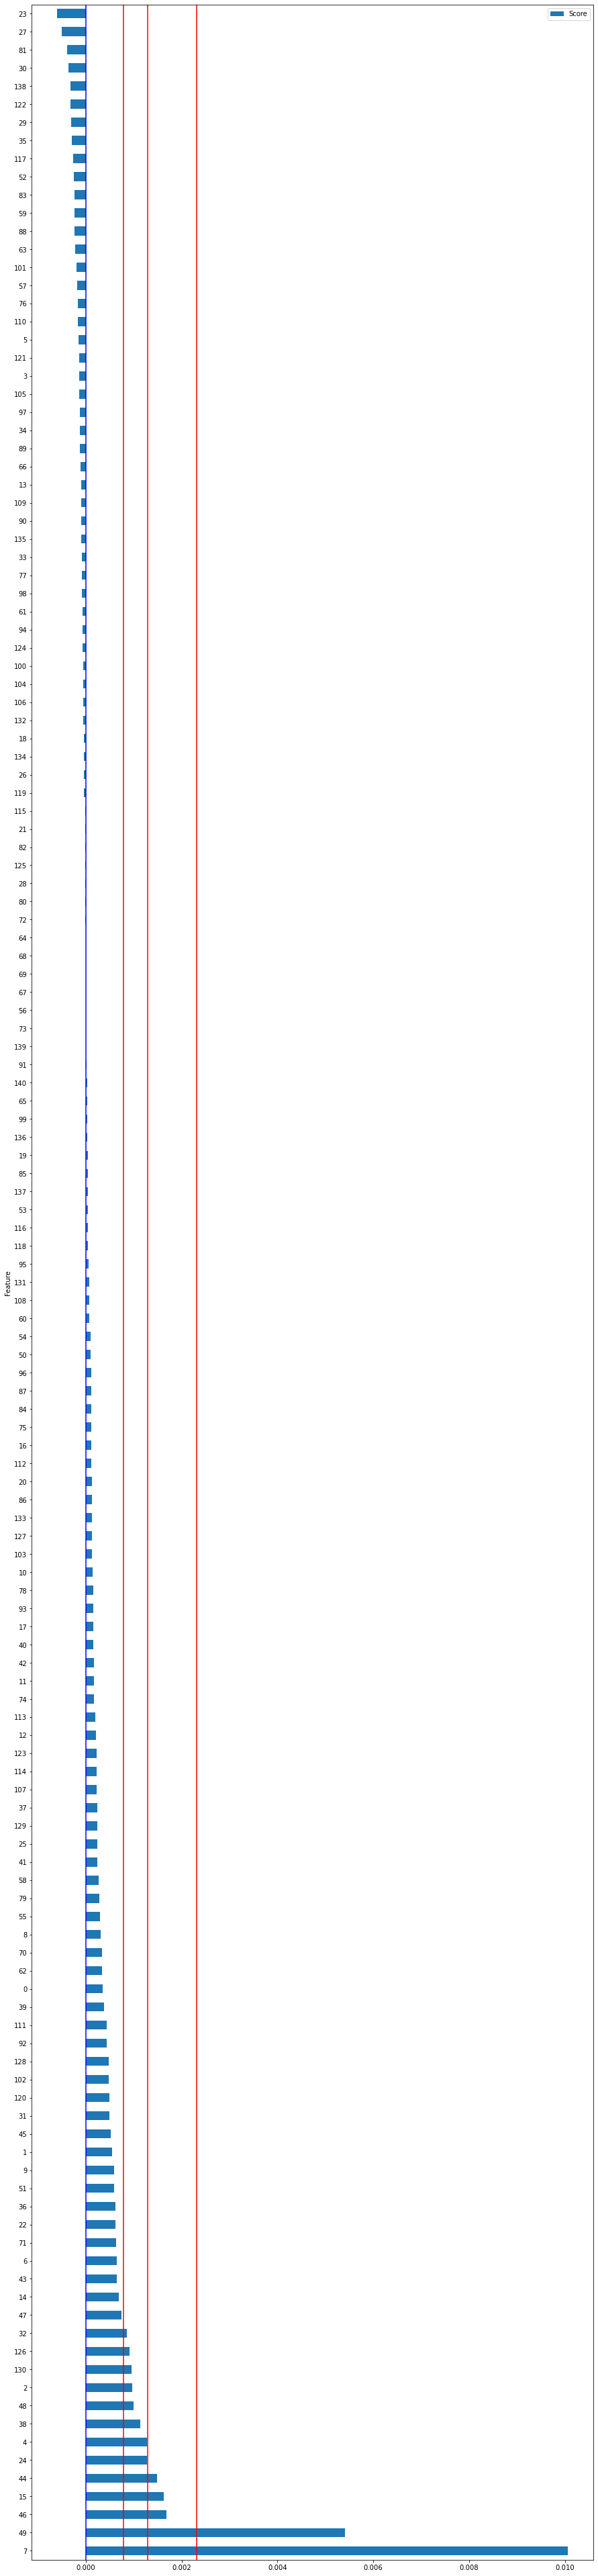

In [45]:
#use above mean for the features 
rel_col = feat_score.sort_values('Score', ascending = False).iloc[:46,:].Feature
MDA_Dataset = pd.DataFrame(PCA_train_x)[rel_col.astype(int)]

MDA_PCA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_PCA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,70))
plt.axvline(x = float(MDA_mean + 2* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + 1* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + .5* MDA_std), color = 'r')


plt.axvline(x= 0, color = 'b')
plt.savefig('MDA_on_PCA_Barh')

## Random Forest AUC-ROC | MDA on PCA


In [46]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,16,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_PCA_train_x, num_train_y, num_train_era, client,30, params, 100)

Done Scattering
0 0 500
0
0 0 500
5
0 0 500
10
0 0 500
15
0 0 500
20
0 0 500
25
0 0 500
30
0 0 500
35
0 0 500
40
0 0 500
45
0 0 500
50
0 0 500
55
0 0 500
60
0 0 500
65
0 0 500
70
0 0 500
75
0 0 500
80
0 0 500
85
0 0 500
90
0 0 500
95
0 0 500
100
0 0 500
105
0 0 500
110
0 0 500
115
0 0 500
120
0 0 500
125
0 0 500
130
0 0 500
135
0 0 500
140
0 0 500
145
0 0 500
150
0 0 500
155
0 0 500
160
0 0 500
165
0 0 500
170
0 0 500
175
0 0 500
180
0 0 500
185
0 0 500
190
0 0 500
195
0 0 500
200
0 0 500
205
0 0 500
210
0 0 500
215
0 0 500
220
0 0 500
225
0 0 500
230
0 0 500
235
0 0 500
240
0 0 500
245
0 0 500
250
0 0 500
255
0 0 500
260
0 0 500
265
0 0 500
270
0 0 500
275
0 0 500
280
0 0 500
285
0 0 500
290
0 0 500
295
0 0 500
300
0 0 500
305
0 0 500
310
0 0 500
315
0 0 500
320
0 0 500
325
0 0 500
330
0 0 500
335
0 0 500
340
0 0 500
345
0 0 500
350
0 0 500
355
0 0 500
360
0 0 500
365
0 0 500
370
0 0 500
375
0 0 500
380
0 0 500
385
0 0 500
390
0 0 500
395
0 0 500
400
0 0 500
405
0 0 500
410
0 0 500
41

In [47]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
98       mse             4             196          0.5                17   
44       mse             2             156          0.9                35   
74       mse             2             140          0.7                17   
39       mse             4             156          0.6                19   
66       mse             2             236          0.6                37   
..       ...           ...             ...          ...               ...   
61       mse            14             100          0.5                 7   
15       mse            14             132          0.7                23   
78       mse            14             132          0.8                11   
50       mse            14             100          0.9                13   
77       mse            14             116          0.7                23   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
98                  8          1325      -1            42        0   
44                  8          1100      -1            42        0   
74                  6          1075      -1            42        0   
39                  4          1200      -1            42        0   
66                  4           950      -1            42        0   
..                ...           ...     ...           ...      ...   
61                  4          1175      -1            42        0   
15                  6          1450      -1            42        0   
78                  8           950      -1            42        0   
50                  2          1500      -1            42        0   
77                  2           575      -1            42        0   

    Spearman Rank Corr by ERA Mean  Quartic Mean Error  
98                        0.051512            0.026411  
44                        0.051496            0.026425  
74                        0.051175            0.026426  
39                        0.051099            0.026415  
66                        0.051045            0.026419  
..                             ...                 ...  
61                        0.047139            0.026416  
15                        0.046966            0.026415  
78                        0.046477            0.026416  
50                        0.046470            0.026416  
77                        0.046177            0.026417  

[100 rows x 12 columns]

In [48]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 11525,
                               max_depth= 37,
                               verbose = 0,
                               max_features=2, 
                               n_jobs=-1, 
                               max_leaf_nodes= 116,
                               max_samples = .5 , 
                               min_samples_leaf =11, 
                               min_samples_split =6)

In [39]:
spearman, qme = kfold_dask(10, MDA_PCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "MDA On PCA - 46 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
6 0 4
75
8 0 2
80
8 0 2
85
10 0 0


Reduction Technique                     Spearman Rank Corr by ERA Mean  \
0          MDA on PCA  (0.04171672293356138, (0.03077085860934014, 0....   

  S CI 2.5% S CI 97.5% Quartic Mean Error Q CI 2.5% Q CI 97.5%  \
0       NaN        NaN                NaN       NaN        NaN   

   Confidence Interval 2.5%                     Confidence Interval 97.5%  
0                  0.026435  (0.026413944869624513, 0.026456017531632764)

## UMAP Clustering On PCA for Numerai Data

In [22]:
umap_train_x =PCA_train_x[:45000]
umap_train_y = num_train_y[:45000]
params = [{
        "n_components" : np.arange(20,150,10), 
        "n_neighbors":np.arange(50,150,5),
        "n_epochs": [200],
        "b" : np.arange(1,45,5)*.1, 
        "low_memory":[True],
        "metric" : ['correlation', 'canberra','braycurtis'],
        "init" : ['spectral'],
        "a" : np.arange(300,10000,200)*.001,
        "local_connectivity":[1],
        #"repulsion_strength": np.arange(1,5),
        #"target_weight": [.25],
        "verbose":[True]
}]
UMAP =  umap.UMAP
scores = pd.DataFrame()
graphs = dict()

UMAP_tune, graph = tune_redux_corank_dask(UMAP,3,umap_train_x,umap_train_y,20,200,client, params,60,60)

scores = scores.append(UMAP_tune, ignore_index = True)
scores.sort_values(by=['LCMC Max'],ascending = False)


NameError: name 'PCA_train_x' is not defined

0
1
2
3
4
5


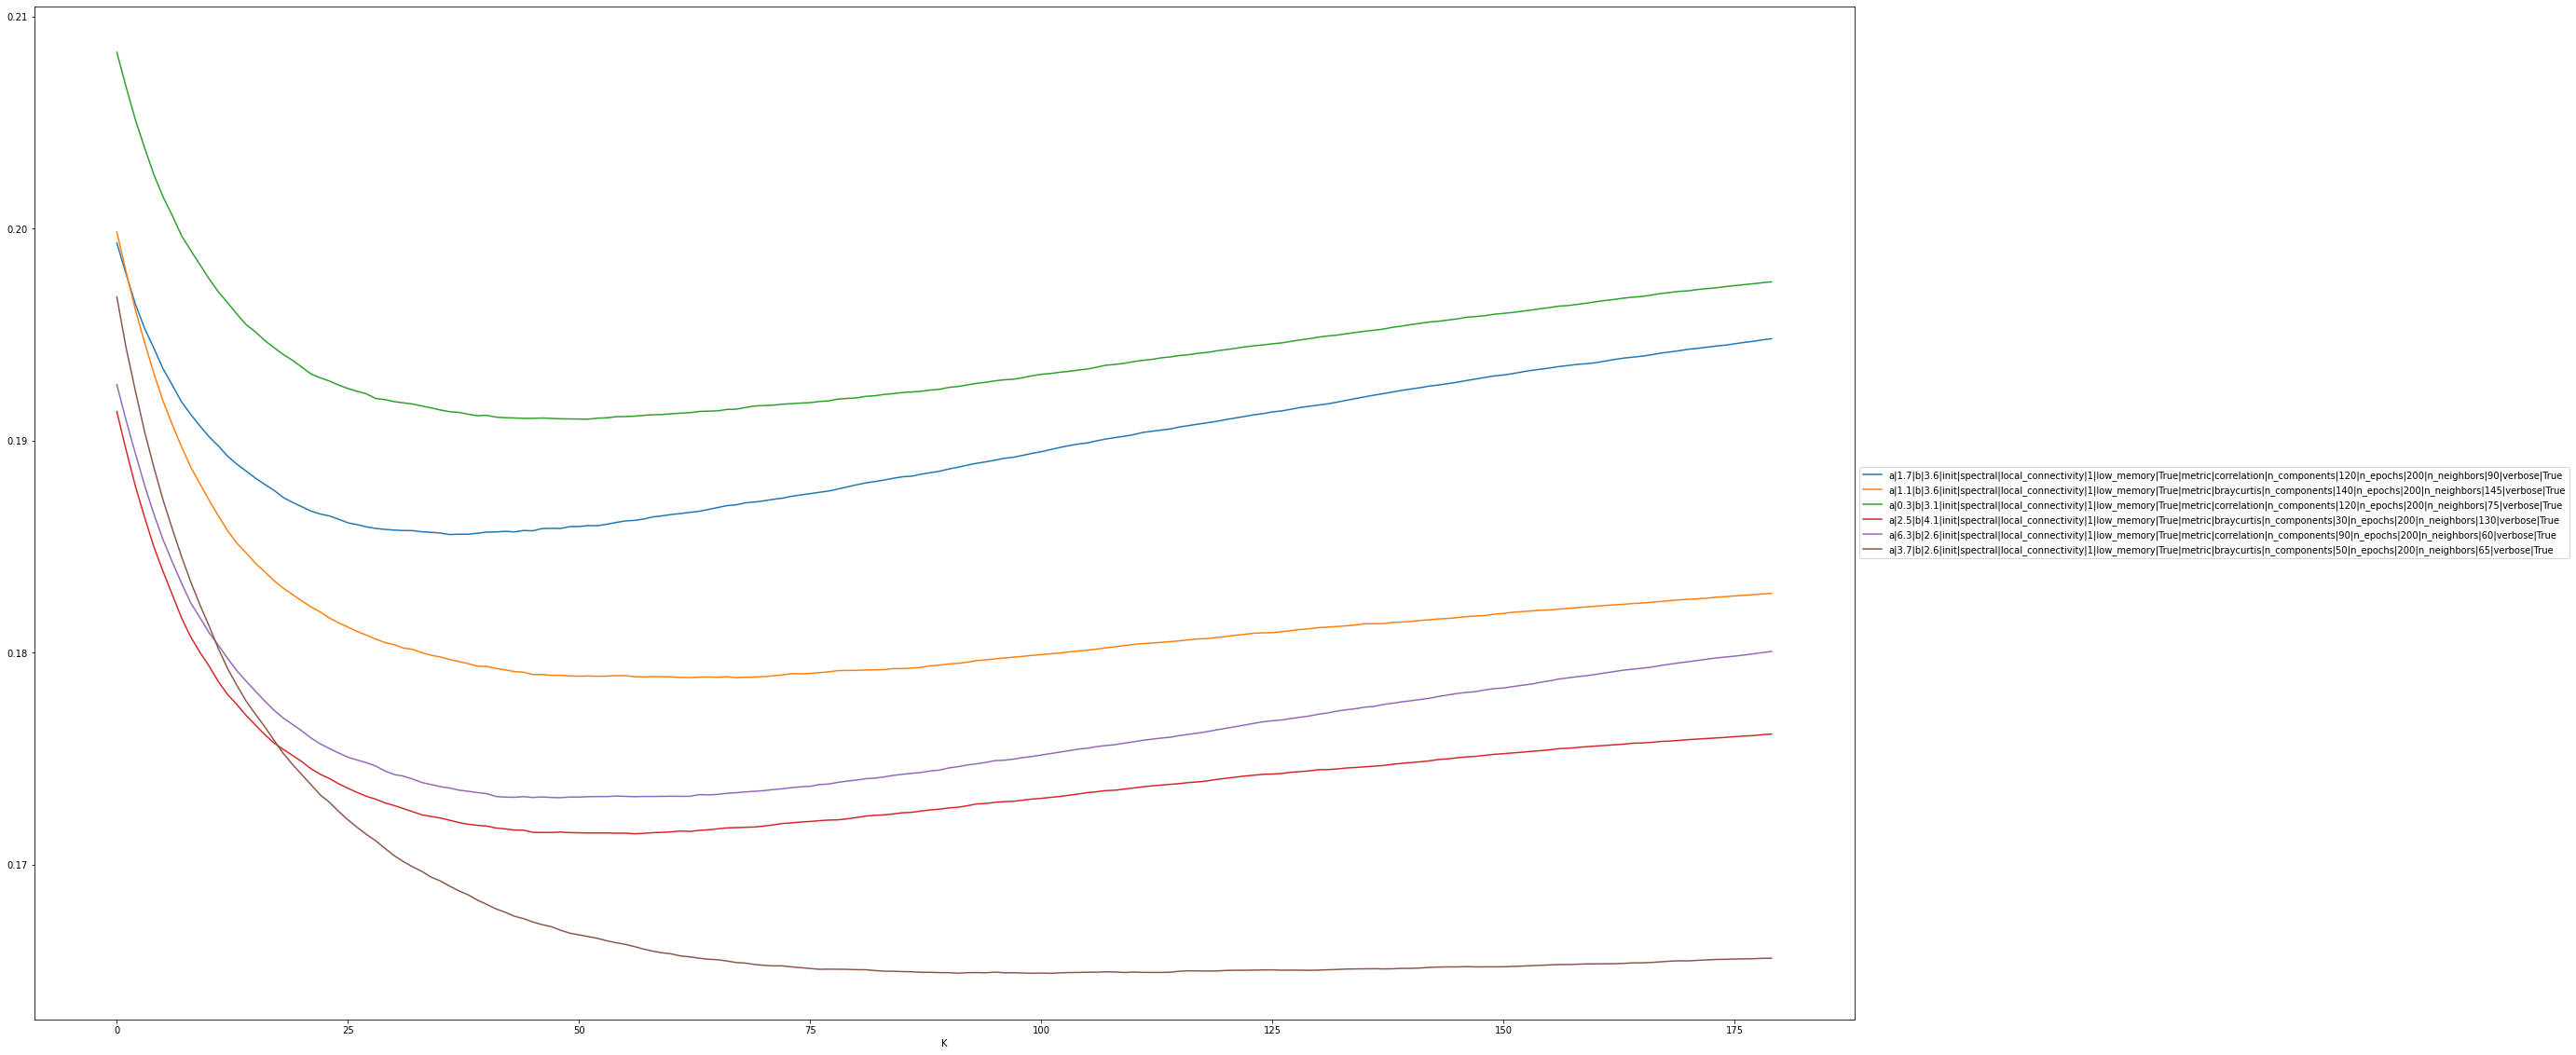

In [32]:
i =0

for  label,g in graphs.items():
    if g['LCMC'].max() > .190:
        if i == 0:
            print(i)
            ax = g.plot(y = 'LCMC',x ='K', label = re.sub("\s\s+", "|", label),figsize=(35,20))
        else:
            print(i)
            g.plot(y = 'LCMC',x ='K',  label = re.sub("\s\s+", "|", label), ax = ax)
        i += 1
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('LCMC_UMAP_PCA')
plt.show()

In [21]:
UMAP = umap.UMAP(init= 'spectral',
                 n_components= 130, 
                 low_memory= True, 
                 n_epochs = 200,
                 metric= 'braycurtis',
                 a = 2.6,
                 b= 3.1,
                 n_neighbors= 50,
                 verbose = True
                )
UMAP_PCA_train_x= UMAP.fit_transform(PCA_train_x)


NameError: name 'PCA_train_x' is not defined

In [30]:

params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,18,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param =  tune_dask_kfold(model,UMAP_PCA_train_x,num_train_y,num_train_era, client,30, params, 120)
hyp_param

Done Scattering
0 0 600
0
0 0 600
5
0 0 600
10
0 0 600
15
0 0 600
20
0 0 600
25
0 0 600
30
0 0 600
35
0 0 600
40
0 0 600
45
0 0 600
50
0 0 600
55
0 0 600
60
0 0 600
65
0 0 600
70
0 0 600
75
0 0 600
80
0 0 600
85
0 0 600
90
0 0 600
95
0 0 600
100
0 0 600
105
0 0 600
110
0 0 600
115
0 0 600
120
0 0 600
125
0 0 600
130
0 0 600
135
0 0 600
140
0 0 600
145
0 0 600
150
0 0 600
155
0 0 600
160
0 0 600
165
0 0 600
170
0 0 600
175
0 0 600
180
0 0 600
185
0 0 600
190
0 0 600
195
0 0 600
200
0 0 600
205
0 0 600
210
0 0 600
215
0 0 600
220
0 0 600
225
0 0 600
230
0 0 600
235
0 0 600
240
0 0 600
245
0 0 600
250
0 0 600
255
0 0 600
260
0 0 600
265
0 0 600
270
0 0 600
275
0 0 600
280
0 0 600
285
0 0 600
290
0 0 600
295
0 0 600
300
0 0 600
305
0 0 600
310
0 0 600
315
0 0 600
320
0 0 600
325
0 0 600
330
0 0 600
335
0 0 600
340
0 0 600
345
0 0 600
350
0 0 600
355
0 0 600
360
0 0 600
365
0 0 600
370
0 0 600
375
0 0 600
380
0 0 600
385
0 0 600
390
0 0 600
395
0 0 600
400
0 0 600
405
0 0 600
410
0 0 600
41

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
0         mse             4             148          0.9                27   
1         mse             4             108          0.9                39   
2         mse            16             124          0.9                11   
3         mse             2             220          0.8                21   
4         mse             2             196          0.5                17   
..        ...           ...             ...          ...               ...   
115       mse             2             220          0.8                35   
116       mse             6             204          0.9                39   
117       mse            10             164          0.9                29   
118       mse             2             108          0.5                19   
119       mse            12             188          0.5                31   

     min_samples_split  n_estimators  n_jobs  random_state  verbose  \
0                    8          1250      -1            42        0   
1                    4           550      -1            42        0   
2                    4           600      -1            42        0   
3                    4           725      -1            42        0   
4                    2           900      -1            42        0   
..                 ...           ...     ...           ...      ...   
115                  8           725      -1            42        0   
116                  8           975      -1            42        0   
117                  2          1075      -1            42        0   
118                  8          1250      -1            42        0   
119                  4          1250      -1            42        0   

     Spearman Rank Corr by ERA Mean  
0                          0.040026  
1                          0.040465  
2                          0.040527  
3                          0.039526  
4                          0.039272  
..                              ...  
115                        0.038332  
116                        0.039870  
117                        0.040494  
118                        0.039499  
119                        0.039713  

[120 rows x 11 columns]

In [31]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
39        mse            14             100          0.5                25   
99        mse            10             100          0.9                 7   
68        mse             8             108          0.7                39   
17        mse            10             108          0.7                29   
30        mse            16             116          0.6                23   
..        ...           ...             ...          ...               ...   
59        mse            10             228          0.5                17   
57        mse             2             236          0.5                31   
103       mse            16             244          0.8                25   
115       mse             2             220          0.8                35   
94        mse             6             228          0.5                25   

     min_samples_split  n_estimators  n_jobs  random_state  verbose  \
39                   6          1425      -1            42        0   
99                   6           725      -1            42        0   
68                   6          1500      -1            42        0   
17                   4           925      -1            42        0   
30                   6           625      -1            42        0   
..                 ...           ...     ...           ...      ...   
59                   2          1375      -1            42        0   
57                   6           525      -1            42        0   
103                  6           550      -1            42        0   
115                  8           725      -1            42        0   
94                   2           625      -1            42        0   

     Spearman Rank Corr by ERA Mean  
39                         0.040918  
99                         0.040895  
68                         0.040846  
17                         0.040819  
30                         0.040801  
..                              ...  
59                         0.038922  
57                         0.038694  
103                        0.038390  
115                        0.038332  
94                         0.038191  

[120 rows x 11 columns]

In [32]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 1425,
                               max_depth= 14,
                               verbose = 0,
                               max_features=14, 
                               n_jobs=-1, 
                               max_leaf_nodes= 100,
                               max_samples = .5, 
                               min_samples_leaf =25, 
                               min_samples_split = 6 )

In [ ]:
spearman, qme = kfold_dask(10, UMAP_PCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "UMAP- 130 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35


## Shapley Values on UMAP PCA

In [21]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 250,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 6, 
                               n_jobs=-1, 
                               max_leaf_nodes= 180,
                               max_samples = .7, 
                               min_samples_leaf = 25, 
                               min_samples_split = 4 )
explainer = shap.TreeExplainer(rf_hp.fit(UMAP_PCA_train_x, num_train_y), data = UMAP_PCA_train_x[:1000])
shap_values = explainer.shap_values(UMAP_PCA_train_x[:1000])


100%|===================| 999/1000 [05:59<00:00]        

In [22]:
shap_val = pd.DataFrame({'Feature':range(130),'Score':np.abs(shap_values).mean(axis = 0)})
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('SHAP_UMAP_PCA')
shap_val

Feature     Score
45        45  0.001658
62        62  0.000856
58        58  0.000813
53        53  0.000811
27        27  0.000678
..       ...       ...
10        10  0.000084
4          4  0.000073
106      106  0.000071
100      100  0.000070
41        41  0.000068

[130 rows x 2 columns]

In [23]:
shap_val = pd.read_csv('SHAP_UMAP_PCA').iloc[:,1:]
shap_val.set_index(shap_val.Feature, inplace = True)
shap_val

Feature     Score
Feature                   
45            45  0.001658
62            62  0.000856
58            58  0.000813
53            53  0.000811
27            27  0.000678
...          ...       ...
10            10  0.000084
4              4  0.000073
106          106  0.000071
100          100  0.000070
41            41  0.000068

[130 rows x 2 columns]

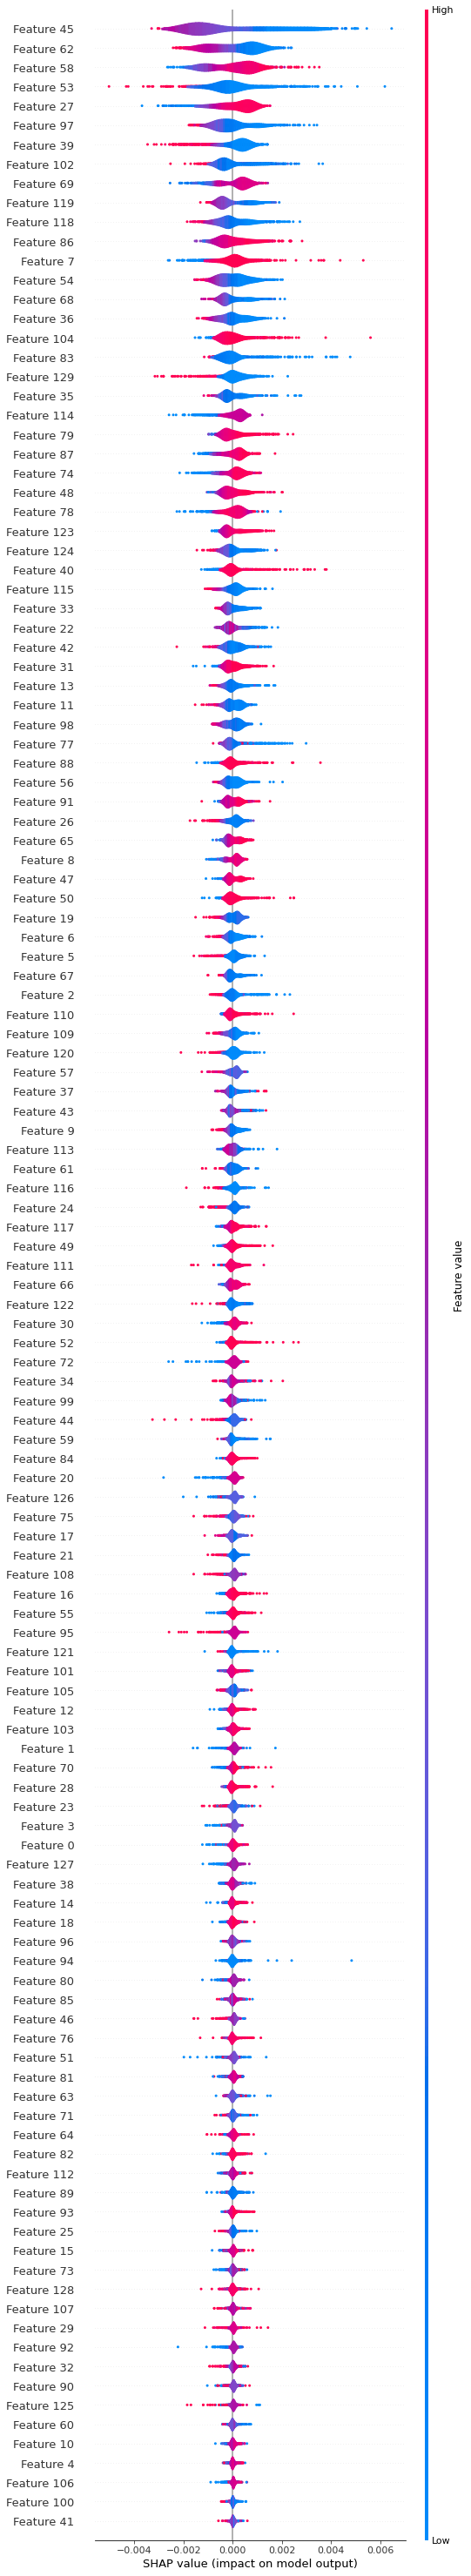

NameError: name 'violin_plot' is not defined

In [24]:
fig = plt.figure()

violin_plot= shap.summary_plot(shap_values, UMAP_PCA_train_x[:1000], max_display = 130,plot_type ='violin')
fig.savefig("violin_UMAP_PCA.png", bbox_inches='tight', dpi=200)
violin_plot

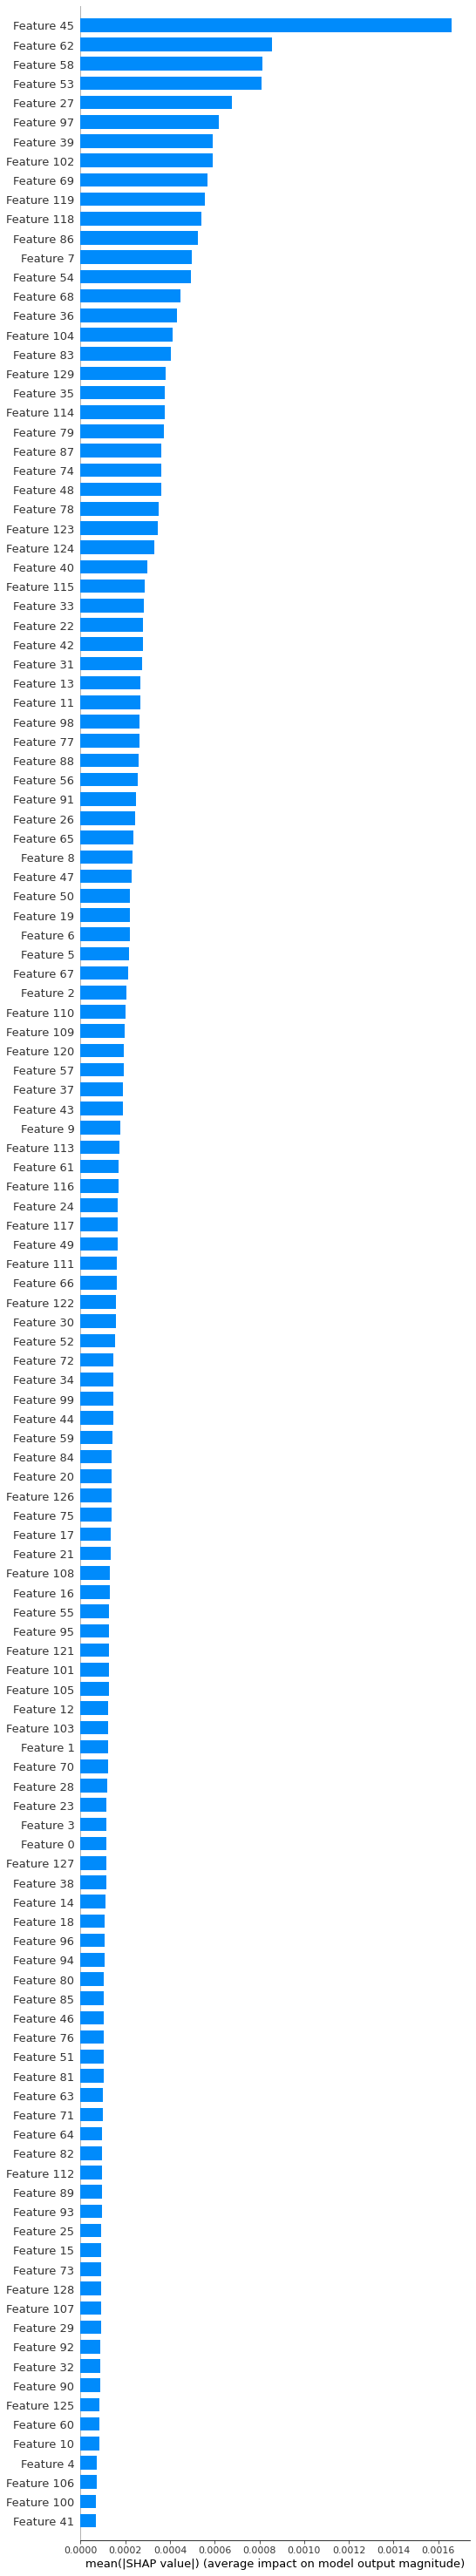

In [25]:
fig = plt.figure()

shap.summary_plot(shap_values,UMAP_PCA_train_x[:1000], plot_type="bar", max_display = 130)
fig.savefig("mean_SHAP_UMAP_PCA.png", bbox_inches='tight', dpi=200)


In [28]:
s = SHAP_tune(UMAP_PCA_train_x,num_train_y,num_train_era,120, shap_val, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]

s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
SHAP_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
SHAP_tune_results.sort_values('Spearman Rank', ascending = False)

Int64Index([45, 62], dtype='int64', name='Feature')
Int64Index([45, 62, 58], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69, 119], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69, 119, 118], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69, 119, 118, 86], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69, 119, 118, 86, 7], dtype='int64', name='Feature')
Int64Index([45, 62, 58, 53, 27, 97, 39, 102, 69, 119, 118, 86, 7, 54], dtype='int64', name='Feature'

KeyboardInterrupt: 

In [35]:
rel_col = (shap_val.sort_values('Score', ascending = False).iloc[:72,:]).index
SHAP_Dataset =  UMAP_PCA_train_x.iloc[:,rel_col]

SHAP_train_x   =SHAP_Dataset.iloc[:400000,:].to_numpy()
SHAP_test_x =SHAP_Dataset.iloc[400000:,:].to_numpy()
SHAP_train_x.shape

(400000, 72)

In [36]:
params = [{
    
    "n_estimators": range(500,1001,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,10,1),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,SHAP_train_x, num_train_y,num_train_era, client,30, params, 100)

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_depth': 46, 'max_features': 2, 'max_leaf_nodes': 296, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 39, 'min_samples_split': 2, 'n_estimators': 650, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_depth': 46, 'max_features': 4, 'max_leaf_nodes': 368, 'max_samples': 0.8, 'min_samples_leaf': 35, 'min_samples_split': 4, 'n_estimators': 650, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_depth': 42, 'max_features': 8, 'max_leaf_nodes': 520, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_depth': 38, 'max_features': 1, 'max_leaf_nodes': 2

In [37]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
93       mse         30             7             488          0.7   
20       mse         42             7             520          0.7   
63       mse         50             7             376          0.7   
37       mse         34             9             344          0.7   
44       mse         30             5             472          0.9   
..       ...        ...           ...             ...          ...   
57       mse         34             1             344          0.6   
81       mse         46             1             288          0.7   
90       mse         46             1             200          0.8   
16       mse         38             1             472          0.7   
87       mse         46             1             536          0.8   

    min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
93                27                  2           900      -1            42   
20                27                  4           550      -1            42   
63                29                  4          1000      -1            42   
37                39                  2           525      -1            42   
44                21                  8           975      -1            42   
..               ...                ...           ...     ...           ...   
57                39                  6           575      -1            42   
81                35                  2           575      -1            42   
90                23                  2           525      -1            42   
16                15                  4           800      -1            42   
87                21                  4           575      -1            42   

    verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
93        0                        0.052941            0.026403  
20        0                        0.052297            0.026404  
63        0                        0.052102            0.026405  
37        0                        0.052044            0.026402  
44        0                        0.052041            0.026410  
..      ...                             ...                 ...  
57        0                        0.045189            0.026447  
81        0                        0.045154            0.026450  
90        0                        0.044364            0.026454  
16        0                        0.043400            0.026451  
87        0                        0.042719            0.026449  

[100 rows x 13 columns]

In [38]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 900,
                               max_depth= 30,
                               verbose = 0,
                               max_features= 7, 
                               n_jobs=-1, 
                               max_leaf_nodes= 488,
                               max_samples = .7, 
                               min_samples_leaf =27, 
                               min_samples_split = 2)

In [39]:
spearman, qme = kfold_dask(10, SHAP_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "SHAP - 72", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
9 0 1
15
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0           SHAP - 54                        0.042716   0.033446    0.051985   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026422   0.026398    0.026446

## MDA done on UMAP on PCA

In [54]:
scores = MDA(UMAP_PCA_train_x, num_train_y,num_train_era, client,60)
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])


0 0 60
0
0 0 60
5
0 0 60
10
60 0 0
['tcp://10.128.0.100:44605', 'tcp://10.128.0.101:38513', 'tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883', 'tcp://10.128.0.160:36915']
['tcp://10.128.0.101:38513', 'tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883', 'tcp://10.128.0.160:36915', 'tcp://10.128.0.161:39559']
['tcp://10.128.0.102:43783', 'tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10.128.0.158:43007', 'tcp://10.128.0.159:40883', 'tcp://10.128.0.160:36915', 'tcp://10.128.0.161:39559', 'tcp://10.128.0.162:40535']
['tcp://10.128.0.103:37991', 'tcp://10.128.0.114:44307', 'tcp://10.128.0.115:42763', 'tcp://10.128.0.157:41447', 'tcp://10

In [55]:
feat_score.to_csv('MDA_On_UMAP_PCA')

In [56]:
scores = pd.read_csv('MDA_On_UMAP_PCA')

In [57]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score['Feature'] = feat_score['Feature'].apply(lambda x: str(x.strip("]['")))
MDA_mean = np.mean(feat_score.Score)
MDA_std = np.std(feat_score.Score)
feat_score

Score Feature
0    0.000901      18
1    0.000507       7
2    0.000400      12
3    0.000361      29
4    0.000336      71
..        ...     ...
125 -0.000220      33
126 -0.000234     109
127 -0.000237      98
128 -0.000275      78
129 -0.000283      49

[130 rows x 2 columns]

In [59]:
s = MDA_tune(UMAP_PCA_train_x,num_train_y,num_train_era,100, feat_score, client, 60)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
0 0 10
5
10 0 0
0
0 0 10
0
0 0 10
5
10 0 0
1
0 0 10
0
0 0 10
5
10 0 0
2
0 0 10
0
0 0 10
5
10 0 0
3
0 0 10
0
0 0 10
5
10 0 0
4
0 0 10
0
0 0 10
5
10 0 0
5
0 0 10
0
0 0 10
5
10 0 0
6
0 0 10
0
0 0 10
5
10 0 0
7
0 0 10
0
0 0 10
5
10 0 0
8
0 0 10
0
0 0 10
5
10 0 0
9
0 0 10
0
0 0 10
5
10 0 0
10
0 0 10
0
0 0 10
5
10 0 0
11
0 0 10
0
0 0 10
5
10 0 0
12
0 0 10
0
0 0 10
5
10 0 0
13
0 0 10
0
0 0 10
5
10 0 0
14
0 0 10
0
0 0 10
5
10 0 0
15
0 0 10
0
0 0 10
5
10 0 0
16
0 0 10
0
0 0 10
5
10 0 0
17
0 0 10
0
0 0 10
5
10 0 0
18
0 0 10
0
0 0 10
5
10 0 0
19
0 0 10
0
0 0 10
5
10 0 0
20
0 0 10
0
0 0 10
5
10 0 0
21
0 0 10
0
0 0 10
5
10 0 0
22
0 0 10
0
0 0 10
5
10 0 0
23
0 0 10
0
0 0 10
5
10 0 0
24
0 0 10
0
0 0 10
5
10 0 0
25
0 0 10
0
0 0 10
5
10 0 0
26
0 0 10
0
0 0 10
5
10 0 0
27
0 0 10
0
0 0 10
5
10 0 0
28
0 0 10
0
0 0 10
5
10 0 0
29
0 0 10
0
0 0 10
5
10 0 0
30
0 0 10
0
0 0 10
5
10 0 0
31
0 0 10
0
0 0 10
5
10 0 0
32
0 0 10
0
0 0 10
5
10 0 0
33
0 0 10
0
0 0 10
5
10 0 0
34
0 0 10
0
0 0 10
5
10 0 0
35
0 

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
14       0.038050   0.031889    0.044211  0.026461     0.026421      0.026502
16       0.037941   0.032025    0.043858  0.026460     0.026421      0.026500
15       0.037886   0.031997    0.043775  0.026461     0.026421      0.026501
13       0.037869   0.032000    0.043738  0.026461     0.026421      0.026502
17       0.037834   0.031871    0.043798  0.026459     0.026419      0.026498
..            ...        ...         ...       ...          ...           ...
5        0.033437   0.029255    0.037618  0.026482     0.026452      0.026512
3        0.033242   0.029048    0.037437  0.026481     0.026449      0.026512
2        0.026633   0.022868    0.030399  0.026500     0.026468      0.026532
1        0.024922   0.021417    0.028426  0.026510     0.026478      0.026541
0        0.024672   0.021130    0.028215  0.026512     0.026480      0.026543

[98 rows x 6 columns]

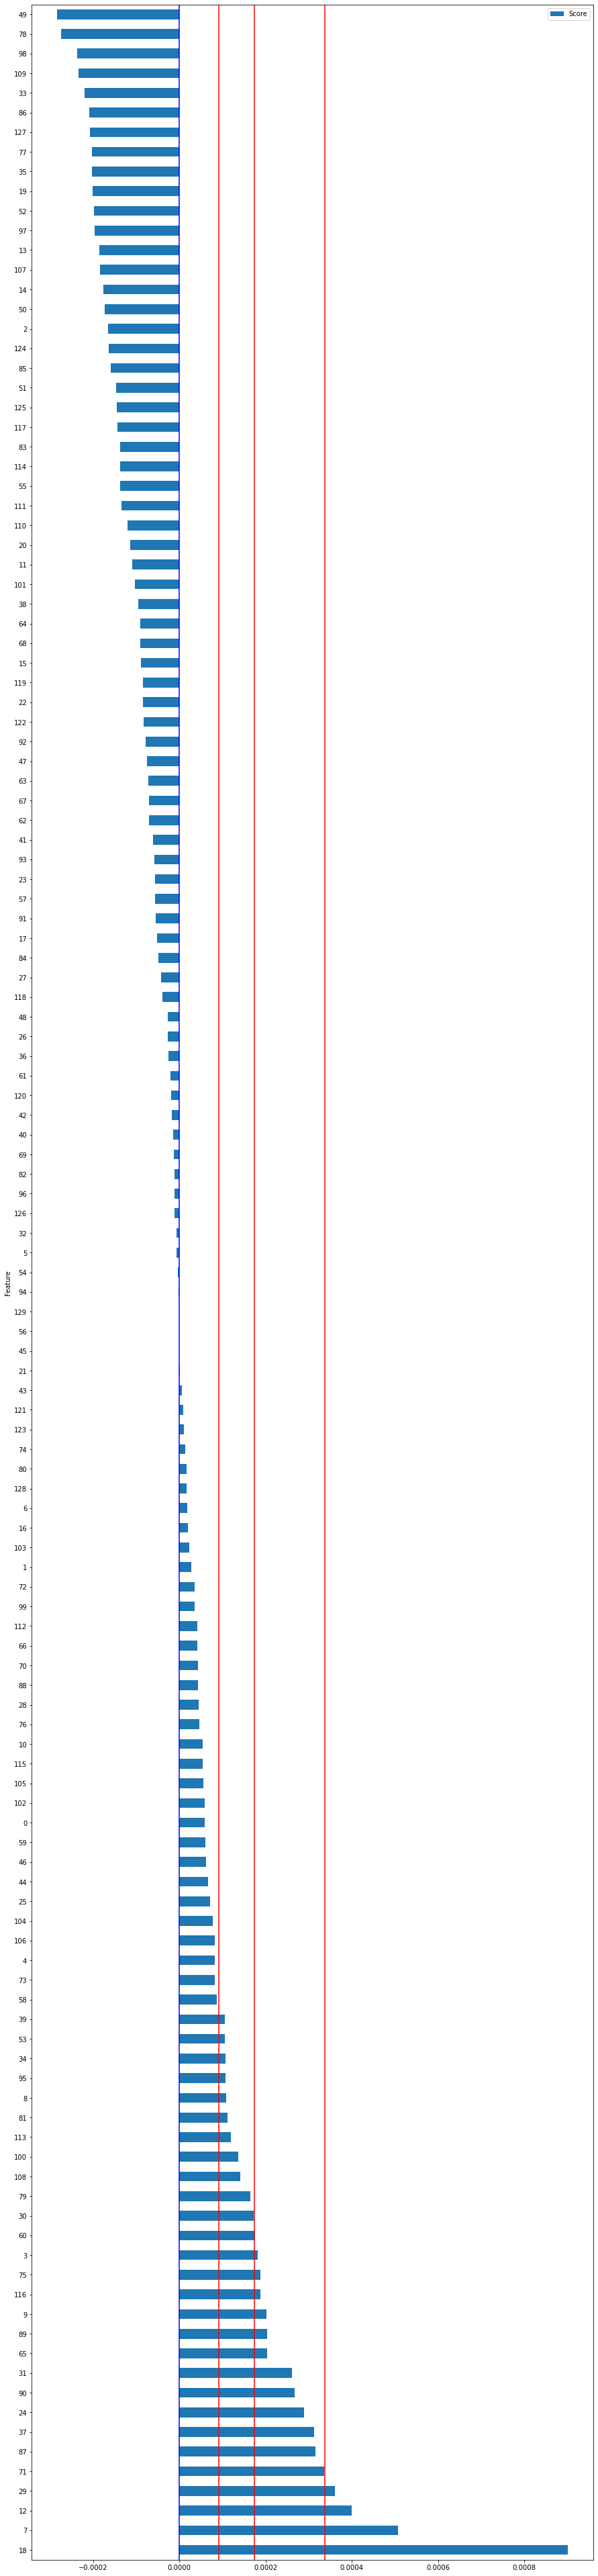

In [60]:
#use above mean for the features 
rel_col = feat_score.sort_values('Score', ascending = False).iloc[:16,:].Feature
MDA_Dataset = pd.DataFrame(UMAP_PCA_train_x)[rel_col.astype(int)]

MDA_UMAP_PCA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_UMAP_PCA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,70))
plt.axvline(x = float(MDA_mean + 2* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + 1* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + .5* MDA_std), color = 'r')


plt.axvline(x= 0, color = 'b')
plt.savefig('MDA_on_PCA_Barh')

## Random Forest AUC-ROC | MDA on PCA


In [ ]:


params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,16,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,MDA_UMAP_PCA_train_x, num_train_y, num_train_era, client,60, params, 100)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
Done Scattering
{'criterion': 'mse', 'max_features': 14, 'max_leaf_nodes': 220, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 29, 'min_samples_split': 6, 'n_estimators': 925, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
12
24
36
48
{'criterion': 'mse', 'max_features': 4, 'max_leaf_nodes': 132, 'max_samples': 0.8, 'min_samples_leaf': 23, 'min_samples_split': 8, 'n_estimators': 1150, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
13
25
37
49
{'criterion': 'mse', 'max_features': 14, 'max_leaf_nodes': 132, 'max_samples': 0.9, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 975, 'n_jobs

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


0 0 500
225
0 0 500
230
0 0 500
235
0 0 500
240
0 0 500
245
0 0 500
250
0 0 500
255
0 0 500
260
0 0 500
265
0 0 500
270
0 0 500
275
0 0 500
280
0 0 500
285
0 0 500
290
0 0 500
295
0 0 500
300
0 0 500
305
0 0 500
310
0 0 500
315
0 0 500
320
0 0 500
325
0 0 500
330
0 0 500
335
0 0 500
340
0 0 500
345
0 0 500
350
0 0 500
355
0 0 500
360
0 0 500
365
0 0 500
370
0 0 500
375
0 0 500
380
0 0 500
385
0 0 500
390
0 0 500
395
0 0 500
400
0 0 500
405
0 0 500
410
0 0 500
415
0 0 500
420
0 0 500
425
0 0 500
430
0 0 500
435
0 0 500
440
0 0 500
445
0 0 500
450
0 0 500
455
0 0 500
460
0 0 500
465
0 0 500
470
0 0 500
475
0 0 500
480
0 0 500
485
0 0 500
490
0 0 500
495
0 0 500
500
0 0 500
505
0 0 500
510
0 0 500
515
0 0 500
520
0 0 500
525
0 0 500
530
0 0 500
535
0 0 500
540
0 0 500
545
0 0 500
550
0 0 500
555
0 0 500
560
0 0 500
565
0 0 500
570
0 0 500
575
0 0 500
580
0 0 500
585
0 0 500
590
0 0 500
595
0 0 500
600
0 0 500
605
0 0 500
610
0 0 500
615
0 0 500
620
0 0 500
625
0 0 500
630
0 0 500
635
0 0 

In [47]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
98       mse             4             196          0.5                17   
44       mse             2             156          0.9                35   
74       mse             2             140          0.7                17   
39       mse             4             156          0.6                19   
66       mse             2             236          0.6                37   
..       ...           ...             ...          ...               ...   
61       mse            14             100          0.5                 7   
15       mse            14             132          0.7                23   
78       mse            14             132          0.8                11   
50       mse            14             100          0.9                13   
77       mse            14             116          0.7                23   

    min_samples_split  n_estimators  n_jobs  random_state  verbose  \
98                  8          1325      -1            42        0   
44                  8          1100      -1            42        0   
74                  6          1075      -1            42        0   
39                  4          1200      -1            42        0   
66                  4           950      -1            42        0   
..                ...           ...     ...           ...      ...   
61                  4          1175      -1            42        0   
15                  6          1450      -1            42        0   
78                  8           950      -1            42        0   
50                  2          1500      -1            42        0   
77                  2           575      -1            42        0   

    Spearman Rank Corr by ERA Mean  Quartic Mean Error  
98                        0.051512            0.026411  
44                        0.051496            0.026425  
74                        0.051175            0.026426  
39                        0.051099            0.026415  
66                        0.051045            0.026419  
..                             ...                 ...  
61                        0.047139            0.026416  
15                        0.046966            0.026415  
78                        0.046477            0.026416  
50                        0.046470            0.026416  
77                        0.046177            0.026417  

[100 rows x 12 columns]

In [48]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 11525,
                               max_depth= 37,
                               verbose = 0,
                               max_features=2, 
                               n_jobs=-1, 
                               max_leaf_nodes= 116,
                               max_samples = .5 , 
                               min_samples_leaf =11, 
                               min_samples_split =6)

In [39]:
spearman, qme = kfold_dask(10, MDA_PCA_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 60)
redux_race = redux_race.append({"Reduction Technique": "MDA On PCA - 46 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
6 0 4
75
8 0 2
80
8 0 2
85
10 0 0


Reduction Technique                     Spearman Rank Corr by ERA Mean  \
0          MDA on PCA  (0.04171672293356138, (0.03077085860934014, 0....   

  S CI 2.5% S CI 97.5% Quartic Mean Error Q CI 2.5% Q CI 97.5%  \
0       NaN        NaN                NaN       NaN        NaN   

   Confidence Interval 2.5%                     Confidence Interval 97.5%  
0                  0.026435  (0.026413944869624513, 0.026456017531632764)

## UMAP Clustering for Numerai Data

In [22]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 650,
                               max_depth= 16,
                               verbose = 0,
                               max_features=5, 
                               n_jobs=-1, 
                               max_leaf_nodes= 146,
                               max_samples = .5, 
                               min_samples_leaf = 19, 
                               min_samples_split = 8)

In [33]:
umap_train_x = num_train_x[:45000]
umap_train_y = num_train_y[:45000]
params = [{
        "n_components" : np.arange(20,150,10), 
        "n_neighbors":np.arange(50,150,5),
        "n_epochs": [200],
        "b" : np.arange(1,45,5)*.1, 
        "low_memory":[True],
        "metric" : ['correlation', 'canberra','braycurtis','euclidean'],
        "init" : ['spectral'],
        "a" : np.arange(300,10000,200)*.001,
        "local_connectivity":[1],
        #"repulsion_strength": np.arange(1,5),
        #"target_weight": [.25],
        "verbose":[True]
}]
UMAP =  umap.UMAP
scores = pd.DataFrame()
graphs = dict()

for i in range(2):
    UMAP_tune, graph = tune_redux_corank_dask(UMAP,3,umap_train_x,umap_train_y,20,200,client, params,30,30)
    print(UMAP_tune)
    graphs.update(graph)
    scores = scores.append(UMAP_tune, ignore_index = True)
scores.sort_values(by=['LCMC Max'],ascending = False)


0 0 30
0
0 0 30
5
0 0 30
10
0 0 30
15
0 0 30
20
0 0 30
25
0 0 30
30
0 0 30
35
0 0 30
40
0 0 30
45
0 0 30
50
0 0 30
55
0 0 30
60
0 0 30
65
0 0 30
70
0 0 30
75
0 0 30
80
0 0 30
85
1 0 29
90
3 0 27
95
7 0 23
100
9 0 21
105
10 0 20
110
13 0 17
115
18 0 12
120
20 0 10
125
21 0 9
130
22 0 8
135
24 0 6
140
24 0 6
145
24 0 6
150
27 0 3
155
28 0 2
160
29 0 1
165
29 0 1
170
29 0 1
175
29 0 1
180
30 0 0
gathered
[<Future: finished, type: numpy.ndarray, key: ndarray-e9afaef3f6e8439f4dc3f4aa120b244a>, <Future: finished, type: numpy.ndarray, key: ndarray-af92f926954a27e1c474f1f2e1d3ed6c>, <Future: finished, type: numpy.ndarray, key: ndarray-4ce5f25a4af393cf951feebb5cbf3a6a>, <Future: finished, type: numpy.ndarray, key: ndarray-09ca69932d9971545731e91337792755>, <Future: finished, type: numpy.ndarray, key: ndarray-f5d55fcb31ef41c90761477cbe6a6afb>, <Future: finished, type: numpy.ndarray, key: ndarray-d3491c62f0903af7411f1487ad769006>, <Future: finished, type: numpy.ndarray, key: ndarray-285ef45aee630

a    b      init  local_connectivity  low_memory       metric  \
31  1.1  3.6  spectral                   1        True    euclidean   
1   1.1  3.6  spectral                   1        True    euclidean   
49  2.5  4.1  spectral                   1        True   braycurtis   
19  2.5  4.1  spectral                   1        True   braycurtis   
5   5.7  4.1  spectral                   1        True    euclidean   
35  5.7  4.1  spectral                   1        True    euclidean   
40  3.1  3.6  spectral                   1        True   braycurtis   
10  3.1  3.6  spectral                   1        True   braycurtis   
26  3.7  2.6  spectral                   1        True    euclidean   
56  3.7  2.6  spectral                   1        True    euclidean   
21  6.3  2.6  spectral                   1        True  correlation   
46  3.5  3.6  spectral                   1        True   braycurtis   
16  3.5  3.6  spectral                   1        True   braycurtis   
51  6.3  2.6  spectral                   1        True  correlation   
28  7.7  3.1  spectral                   1        True   braycurtis   
24  5.9  3.1  spectral                   1        True   braycurtis   
58  7.7  3.1  spectral                   1        True   braycurtis   
54  5.9  3.1  spectral                   1        True   braycurtis   
53  5.3  4.1  spectral                   1        True   braycurtis   
23  5.3  4.1  spectral                   1        True   braycurtis   
4   0.3  3.1  spectral                   1        True     canberra   
34  0.3  3.1  spectral                   1        True     canberra   
17  7.7  2.6  spectral                   1        True   braycurtis   
47  7.7  2.6  spectral                   1        True   braycurtis   
30  1.7  3.6  spectral                   1        True     canberra   
0   1.7  3.6  spectral                   1        True     canberra   
48  3.7  2.1  spectral                   1        True   braycurtis   
18  3.7  2.1  spectral                   1        True   braycurtis   
3   4.7  2.1  spectral                   1        True  correlation   
33  4.7  2.1  spectral                   1        True  correlation   
41  2.1  2.6  spectral                   1        True     canberra   
11  2.1  2.6  spectral                   1        True     canberra   
13  8.3  1.6  spectral                   1        True    euclidean   
43  8.3  1.6  spectral                   1        True    euclidean   
44  8.7  1.6  spectral                   1        True    euclidean   
14  8.7  1.6  spectral                   1        True    euclidean   
39  4.3  1.6  spectral                   1        True  correlation   
9   4.3  1.6  spectral                   1        True  correlation   
57  4.9  1.6  spectral                   1        True     canberra   
27  4.9  1.6  spectral                   1        True     canberra   
36  9.3  1.6  spectral                   1        True     canberra   
6   9.3  1.6  spectral                   1        True     canberra   
38  8.9  1.1  spectral                   1        True   braycurtis   
8   8.9  1.1  spectral                   1        True   braycurtis   
20  1.3  0.1  spectral                   1        True    euclidean   
50  1.3  0.1  spectral                   1        True    euclidean   
42  7.3  0.6  spectral                   1        True   braycurtis   
12  7.3  0.6  spectral                   1        True   braycurtis   
55  0.9  0.1  spectral                   1        True     canberra   
25  0.9  0.1  spectral                   1        True     canberra   
45  9.1  0.6  spectral                   1        True     canberra   
15  9.1  0.6  spectral                   1        True     canberra   
37  1.7  0.1  spectral                   1        True    euclidean   
7   1.7  0.1  spectral                   1        True    euclidean   
22  6.7  0.1  spectral                   1        True    euclidean   
52  6.7  0.1  spectral        

0
1
2
3
4
5
6


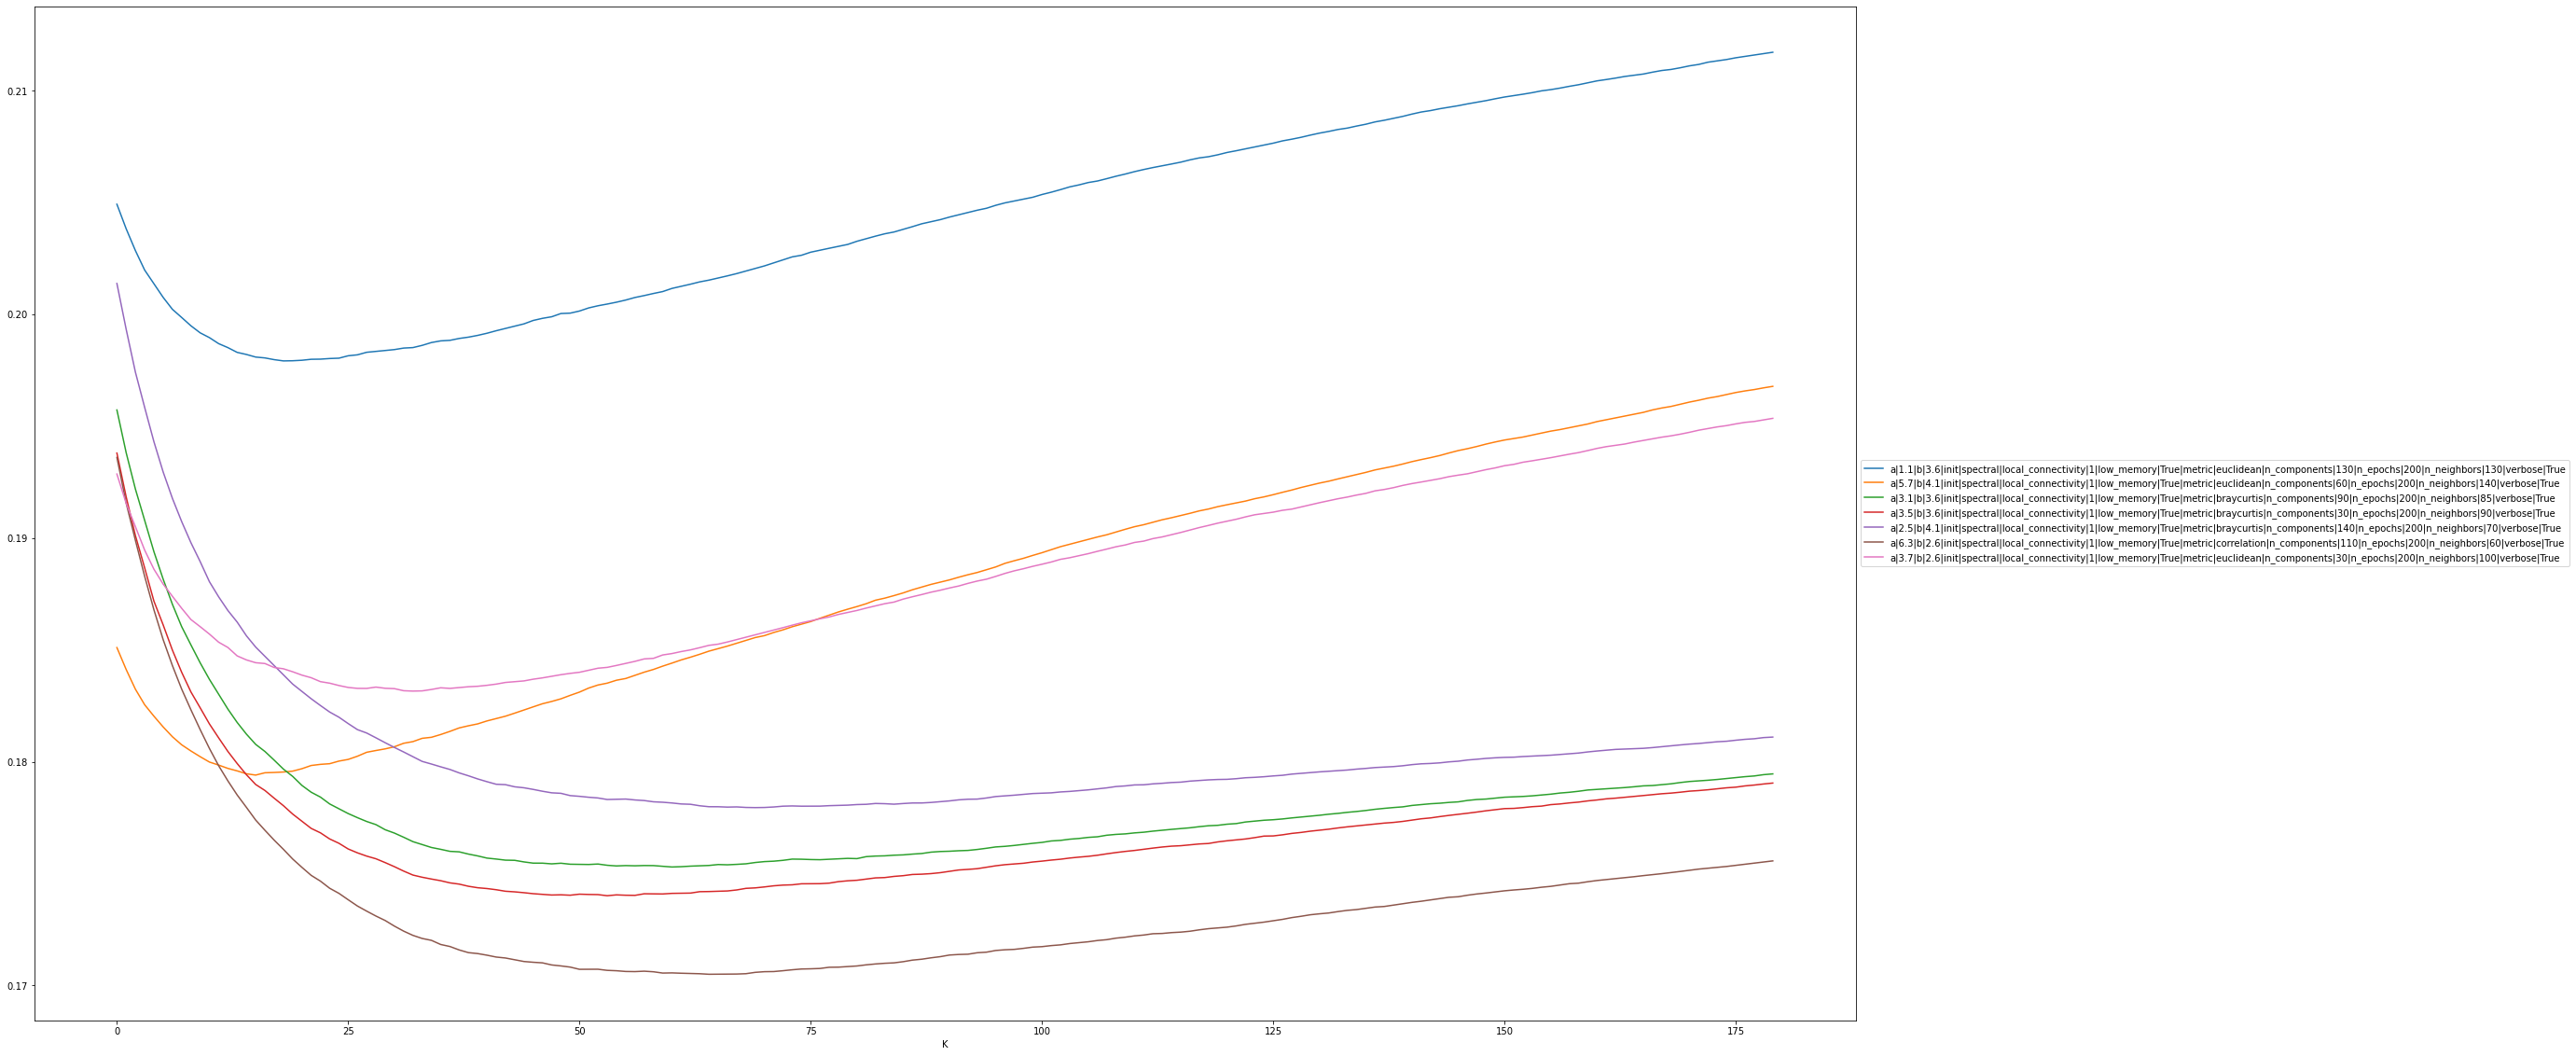

In [37]:
i =0

for  label,g in graphs.items():
    if g['LCMC'].max() > .1900:
        if i == 0:
            print(i)
            ax = g.plot(y = 'LCMC',x ='K', label = re.sub("\s\s+", "|", label),figsize=(35,20))
        else:
            print(i)
            g.plot(y = 'LCMC',x ='K',  label = re.sub("\s\s+", "|", label), ax = ax)
        i += 1
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('LCMC_UMAP')
plt.show()

In [19]:
UMAP = umap.UMAP(init= 'spectral',
                 n_components= 130, 
                 low_memory= True, 
                 n_epochs = 200,
                 metric= 'euclidean',
                 a = 1.1,
                 b= 3.6,
                 n_neighbors= 130,
                 verbose = True
                )
UMAP_train_x= UMAP.fit_transform(num_train_x)


UMAP(a=1.1, angular_rp_forest=False, b=3.6, force_approximation_algorithm=False,
     init='spectral', learning_rate=1.0, local_connectivity=1.0,
     low_memory=True, metric='euclidean', metric_kwds=None, min_dist=0.1,
     n_components=130, n_epochs=200, n_neighbors=130, negative_sample_rate=5,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sat Oct 17 04:06:22 2020 Finding Nearest Neighbors
Sat Oct 17 04:06:23 2020 Building RP forest with 35 trees
Sat Oct 17 04:06:30 2020 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Sat Oct 17 04:10:44 2020 Finished Nearest Neighbor Search
Sat Oct

In [30]:

params = [{
    
    "n_estimators": range(500,1501,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(100,251,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(2,18,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param =  tune_dask_kfold(model,UMAP_train_x,num_train_y,num_train_era, client,30, params, 120)
hyp_param

Done Scattering
0 0 600
0
0 0 600
5
0 0 600
10
0 0 600
15
0 0 600
20
0 0 600
25
0 0 600
30
0 0 600
35
0 0 600
40
0 0 600
45
0 0 600
50
0 0 600
55
0 0 600
60
0 0 600
65
0 0 600
70
0 0 600
75
0 0 600
80
0 0 600
85
0 0 600
90
0 0 600
95
0 0 600
100
0 0 600
105
0 0 600
110
0 0 600
115
0 0 600
120
0 0 600
125
0 0 600
130
0 0 600
135
0 0 600
140
0 0 600
145
0 0 600
150
0 0 600
155
0 0 600
160
0 0 600
165
0 0 600
170
0 0 600
175
0 0 600
180
0 0 600
185
0 0 600
190
0 0 600
195
0 0 600
200
0 0 600
205
0 0 600
210
0 0 600
215
0 0 600
220
0 0 600
225
0 0 600
230
0 0 600
235
0 0 600
240
0 0 600
245
0 0 600
250
0 0 600
255
0 0 600
260
0 0 600
265
0 0 600
270
0 0 600
275
0 0 600
280
0 0 600
285
0 0 600
290
0 0 600
295
0 0 600
300
0 0 600
305
0 0 600
310
0 0 600
315
0 0 600
320
0 0 600
325
0 0 600
330
0 0 600
335
0 0 600
340
0 0 600
345
0 0 600
350
0 0 600
355
0 0 600
360
0 0 600
365
0 0 600
370
0 0 600
375
0 0 600
380
0 0 600
385
0 0 600
390
0 0 600
395
0 0 600
400
0 0 600
405
0 0 600
410
0 0 600
41

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
0         mse             4             148          0.9                27   
1         mse             4             108          0.9                39   
2         mse            16             124          0.9                11   
3         mse             2             220          0.8                21   
4         mse             2             196          0.5                17   
..        ...           ...             ...          ...               ...   
115       mse             2             220          0.8                35   
116       mse             6             204          0.9                39   
117       mse            10             164          0.9                29   
118       mse             2             108          0.5                19   
119       mse            12             188          0.5                31   

     min_samples_split  n_estimators  n_jobs  random_state  verbose  \
0                    8          1250      -1            42        0   
1                    4           550      -1            42        0   
2                    4           600      -1            42        0   
3                    4           725      -1            42        0   
4                    2           900      -1            42        0   
..                 ...           ...     ...           ...      ...   
115                  8           725      -1            42        0   
116                  8           975      -1            42        0   
117                  2          1075      -1            42        0   
118                  8          1250      -1            42        0   
119                  4          1250      -1            42        0   

     Spearman Rank Corr by ERA Mean  
0                          0.040026  
1                          0.040465  
2                          0.040527  
3                          0.039526  
4                          0.039272  
..                              ...  
115                        0.038332  
116                        0.039870  
117                        0.040494  
118                        0.039499  
119                        0.039713  

[120 rows x 11 columns]

In [31]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_features  max_leaf_nodes  max_samples  min_samples_leaf  \
39        mse            14             100          0.5                25   
99        mse            10             100          0.9                 7   
68        mse             8             108          0.7                39   
17        mse            10             108          0.7                29   
30        mse            16             116          0.6                23   
..        ...           ...             ...          ...               ...   
59        mse            10             228          0.5                17   
57        mse             2             236          0.5                31   
103       mse            16             244          0.8                25   
115       mse             2             220          0.8                35   
94        mse             6             228          0.5                25   

     min_samples_split  n_estimators  n_jobs  random_state  verbose  \
39                   6          1425      -1            42        0   
99                   6           725      -1            42        0   
68                   6          1500      -1            42        0   
17                   4           925      -1            42        0   
30                   6           625      -1            42        0   
..                 ...           ...     ...           ...      ...   
59                   2          1375      -1            42        0   
57                   6           525      -1            42        0   
103                  6           550      -1            42        0   
115                  8           725      -1            42        0   
94                   2           625      -1            42        0   

     Spearman Rank Corr by ERA Mean  
39                         0.040918  
99                         0.040895  
68                         0.040846  
17                         0.040819  
30                         0.040801  
..                              ...  
59                         0.038922  
57                         0.038694  
103                        0.038390  
115                        0.038332  
94                         0.038191  

[120 rows x 11 columns]

In [32]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 1425,
                               max_depth= 14,
                               verbose = 0,
                               max_features=14, 
                               n_jobs=-1, 
                               max_leaf_nodes= 100,
                               max_samples = .5, 
                               min_samples_leaf =25, 
                               min_samples_split = 6 )

In [ ]:
rf_mean, rf_ci = kfold_dask(10, UMAP_train_x, num_train_y,num_train_era, client, rf_hp,30)
redux_race = redux_race.append({"Reduction Technique": "UMAP", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35


## Shapley Values on UMAP 

In [26]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators = 250,
                               max_depth= 18,
                               verbose = 0,
                               max_features= 6, 
                               n_jobs=-1, 
                               max_leaf_nodes= 180,
                               #max_samples = .7, 
                               min_samples_leaf = 25, 
                               min_samples_split = 4 )
explainer = shap.TreeExplainer(rf_hp.fit(UMAP_train_x, num_train_y), data = UMAP_train_x[:1000])
shap_values = explainer.shap_values(UMAP_train_x[:1000])


 99%|===================| 993/1000 [00:25<00:00]        

In [28]:
shap_val = pd.DataFrame({'Feature':range(130),'Score':np.abs(shap_values).mean(axis = 0)})
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('../Precomputed SHAP Values/SHAP_UMAP')
shap_val

Feature     Score
36        36  0.000634
129      129  0.000531
108      108  0.000483
56        56  0.000457
112      112  0.000454
..       ...       ...
127      127  0.000075
69        69  0.000075
60        60  0.000073
90        90  0.000070
64        64  0.000065

[130 rows x 2 columns]

In [30]:
shap_val = pd.read_csv('../Precomputed SHAP Values/SHAP_UMAP').iloc[:,1:]
shap_val.set_index(shap_val.Feature, inplace = True)
shap_val

Feature     Score
Feature                   
36            36  0.000634
129          129  0.000531
108          108  0.000483
56            56  0.000457
112          112  0.000454
...          ...       ...
127          127  0.000075
69            69  0.000075
60            60  0.000073
90            90  0.000070
64            64  0.000065

[130 rows x 2 columns]

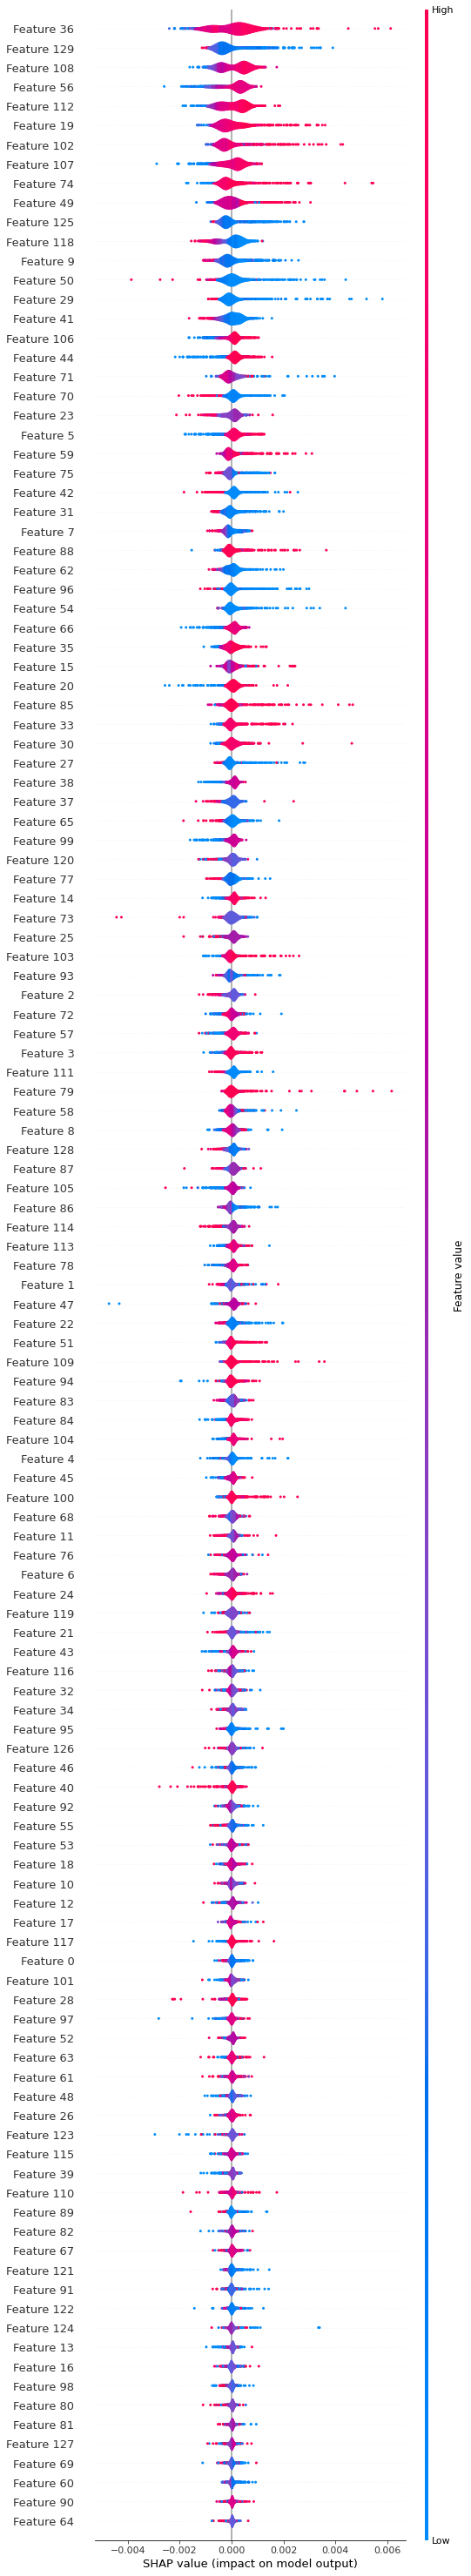

NameError: name 'violin_plot' is not defined

In [34]:
fig = plt.figure()
shap.summary_plot(shap_values, UMAP_train_x[:1000], max_display = 246,plot_type ='violin')
fig.savefig("../Figures/violin_UMAP.png", bbox_inches='tight', dpi=200)
violin_plot

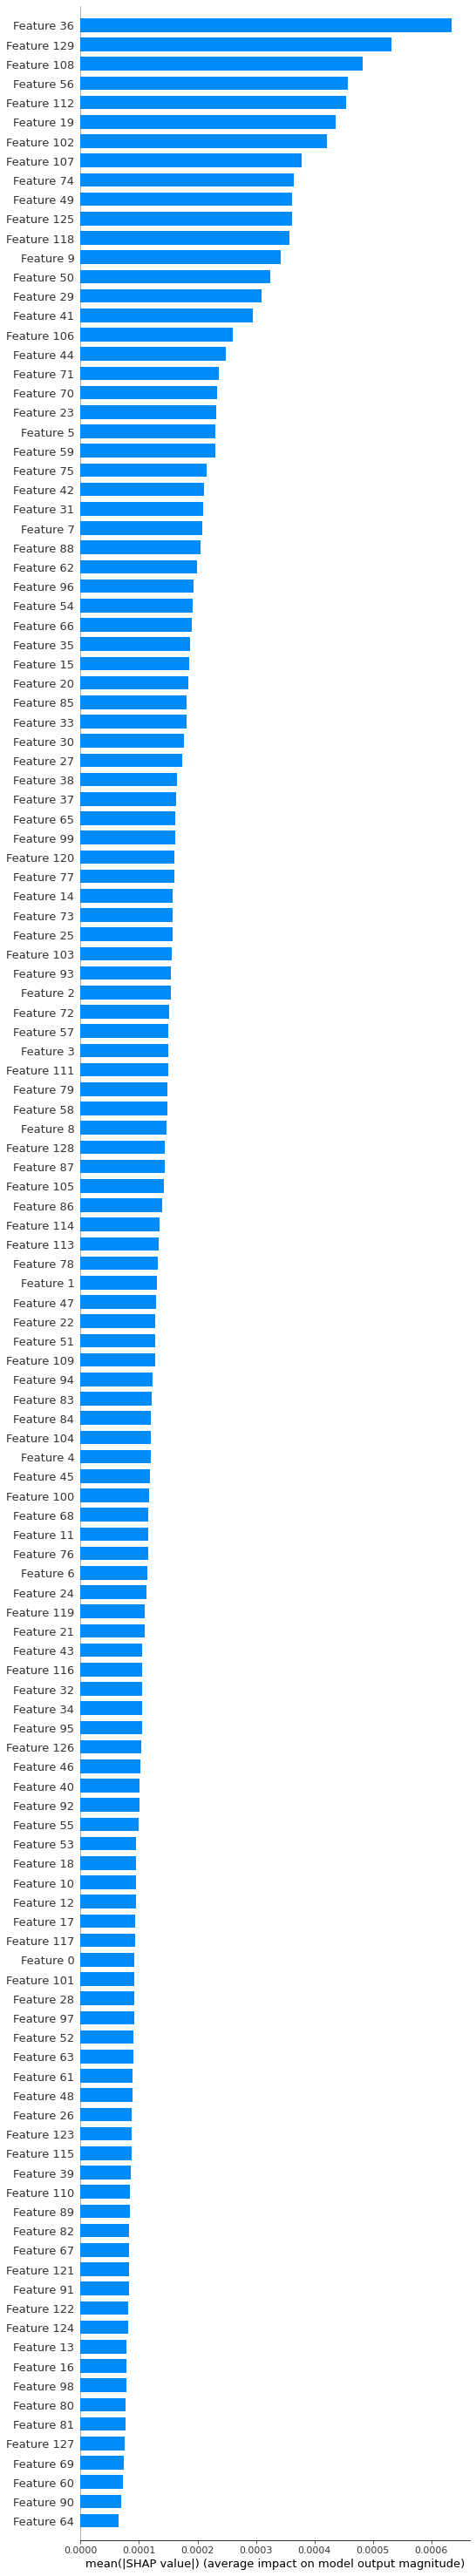

In [35]:
fig = plt.figure()

shap.summary_plot(shap_values,UMAP_train_x[:1000], plot_type="bar", max_display = 246)
fig.savefig("../Figures/mean_SHAP_UMAP.png", bbox_inches='tight', dpi=200)


In [40]:
s = SHAP_tune(UMAP_train_x,num_train_y,num_train_era,120, shap_val, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]

s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
SHAP_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
SHAP_tune_results.sort_values('Spearman Rank', ascending = False)

Int64Index([36, 129], dtype='int64', name='Feature')
Int64Index([36, 129, 108], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74, 49], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74, 49, 125], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74, 49, 125, 118], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74, 49, 125, 118, 9], dtype='int64', name='Feature')
Int64Index([36, 129, 108, 56, 112, 19, 102, 107, 74, 49, 125, 1

AttributeError: 'RandomForestRegressor' object has no attribute 'max_samples'

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


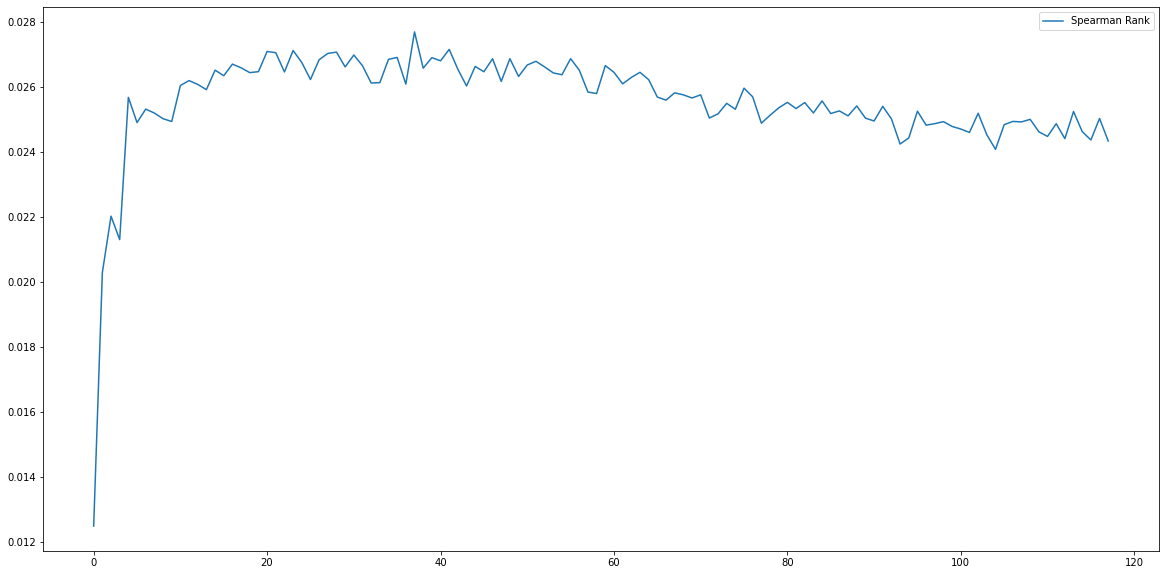

In [40]:
SHAP_tune_results.plot(y = ['Spearman Rank'],kind = 'line',figsize = (20,10))

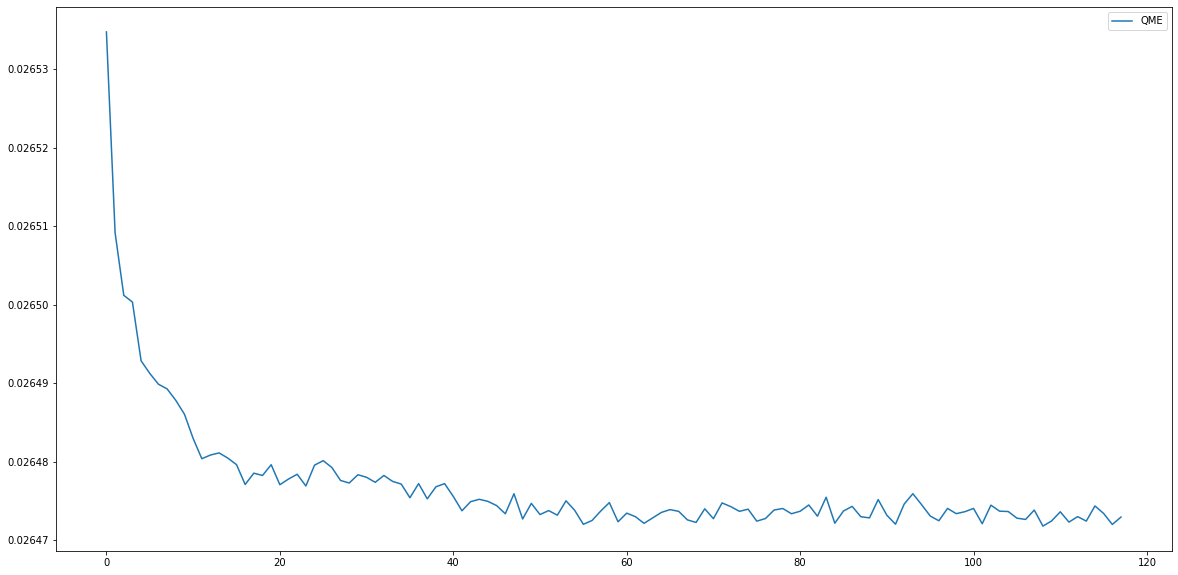

In [39]:
SHAP_tune_results.plot(y = ['QME'],kind = 'line',figsize = (20,10))

In [42]:
rel_col = (shap_val.sort_values('Score', ascending = False).iloc[:39,:]).index
SHAP_Dataset =  UMAP_train_x[:,rel_col]

SHAP_train_x   =SHAP_Dataset[:400000,:]
SHAP_test_x =SHAP_Dataset[400000:,:]
SHAP_train_x.shape

(360490, 39)

In [43]:
params = [{
    
    "n_estimators": range(500,1001,25),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(200,551,8),
    #"oob_score" :[True],
    "min_samples_leaf":range(5,40,2),
    "max_depth": range(30,51, 4),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(1,10,1),
    "criterion" : ['mse']
}]

model = RandomForestRegressor
hyp_param = tune_dask_kfold(model,SHAP_train_x, num_train_y,num_train_era, client,30, params, 100)

[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]
[24 25 26 27 28 29]
Done Scattering
{'criterion': 'mse', 'max_depth': 30, 'max_features': 2, 'max_leaf_nodes': 408, 'max_samples': 0.9, 'min_samples_leaf': 19, 'min_samples_split': 8, 'n_estimators': 900, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
0
6
12
18
24
{'criterion': 'mse', 'max_depth': 30, 'max_features': 7, 'max_leaf_nodes': 216, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 850, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
1
7
13
19
25
{'criterion': 'mse', 'max_depth': 30, 'max_features': 7, 'max_leaf_nodes': 488, 'max_samples': 0.9, 'min_samples_leaf': 37, 'min_samples_split': 6, 'n_estimators': 625, 'n_jobs': -1, 'random_state': 42, 'verbose': 0}
2
8
14
20
26
{'criterion': 'mse', 'max_depth': 30, 'max_features': 3, 'max_leaf_nodes': 448, 'max_samples': 0.9, 'min_sa

In [37]:
hyp_param.sort_values(by= ['Spearman Rank Corr by ERA Mean'], ascending= False)

criterion  max_depth  max_features  max_leaf_nodes  max_samples  \
93       mse         30             7             488          0.7   
20       mse         42             7             520          0.7   
63       mse         50             7             376          0.7   
37       mse         34             9             344          0.7   
44       mse         30             5             472          0.9   
..       ...        ...           ...             ...          ...   
57       mse         34             1             344          0.6   
81       mse         46             1             288          0.7   
90       mse         46             1             200          0.8   
16       mse         38             1             472          0.7   
87       mse         46             1             536          0.8   

    min_samples_leaf  min_samples_split  n_estimators  n_jobs  random_state  \
93                27                  2           900      -1            42   
20                27                  4           550      -1            42   
63                29                  4          1000      -1            42   
37                39                  2           525      -1            42   
44                21                  8           975      -1            42   
..               ...                ...           ...     ...           ...   
57                39                  6           575      -1            42   
81                35                  2           575      -1            42   
90                23                  2           525      -1            42   
16                15                  4           800      -1            42   
87                21                  4           575      -1            42   

    verbose  Spearman Rank Corr by ERA Mean  Quartic Mean Error  
93        0                        0.052941            0.026403  
20        0                        0.052297            0.026404  
63        0                        0.052102            0.026405  
37        0                        0.052044            0.026402  
44        0                        0.052041            0.026410  
..      ...                             ...                 ...  
57        0                        0.045189            0.026447  
81        0                        0.045154            0.026450  
90        0                        0.044364            0.026454  
16        0                        0.043400            0.026451  
87        0                        0.042719            0.026449  

[100 rows x 13 columns]

In [38]:
rf_hp = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 900,
                               max_depth= 30,
                               verbose = 0,
                               max_features= 7, 
                               n_jobs=-1, 
                               max_leaf_nodes= 488,
                               max_samples = .7, 
                               min_samples_leaf =27, 
                               min_samples_split = 2)

In [39]:
spearman, qme = kfold_dask(10, SHAP_train_x, num_train_y, num_train_era,client, rf_hp, num_workers = 30)
redux_race = redux_race.append({"Reduction Technique": "SHAP - 72", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1]}, ignore_index = True)
redux_race

0 0 10
0
0 0 10
5
0 0 10
10
9 0 1
15
10 0 0


Reduction Technique  Spearman Rank Corr by ERA Mean  S CI 2.5%  S CI 97.5%  \
0           SHAP - 54                        0.042716   0.033446    0.051985   

   Quartic Mean Error  Q CI 2.5%  Q CI 97.5%  
0            0.026422   0.026398    0.026446

## MDA on UMAP Results

In [ ]:
scores = MDA(UMAP_train_x,num_train_y,num_train_era, client, 30)
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

In [ ]:
MDA_mean = feat_score.mean()
MDA_std = feat_score.std()
feat_score

In [29]:
s = MDA_tune(UMAP_train_x,num_train_y,num_train_era,100, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
0 0 10
5
10 0 0
0
0 0 10
0
0 0 10
5
10 0 0
1
0 0 10
0
0 0 10
5
10 0 0
2
0 0 10
0
0 0 10
5
10 0 0
3
0 0 10
0
0 0 10
5
10 0 0
4
0 0 10
0
0 0 10
5
10 0 0
5
0 0 10
0
0 0 10
5
10 0 0
6
0 0 10
0
0 0 10
5
10 0 0
7
0 0 10
0
0 0 10
5
10 0 0
8
0 0 10
0
0 0 10
5
10 0 0
9
0 0 10
0
0 0 10
5
10 0 0
10
0 0 10
0
0 0 10
5
10 0 0
11
0 0 10
0
0 0 10
5
10 0 0
12
0 0 10
0
0 0 10
5
10 0 0
13
0 0 10
0
0 0 10
5
10 0 0
14
0 0 10
0
0 0 10
5
10 0 0
15
0 0 10
0
0 0 10
5
10 0 0
16
0 0 10
0
0 0 10
5
10 0 0
17
0 0 10
0
0 0 10
5
10 0 0
18
0 0 10
0
0 0 10
5
10 0 0
19
0 0 10
0
0 0 10
5
10 0 0
20
0 0 10
0
0 0 10
5
10 0 0
21
0 0 10
0
0 0 10
5
10 0 0
22
0 0 10
0
0 0 10
5
10 0 0
23
0 0 10
0
0 0 10
5
10 0 0
24
0 0 10
0
0 0 10
5
10 0 0
25
0 0 10
0
0 0 10
5
10 0 0
26
0 0 10
0
0 0 10
5
10 0 0
27
0 0 10
0
0 0 10
5
10 0 0
28
0 0 10
0
0 0 10
5
10 0 0
29
0 0 10
0
0 0 10
5
10 0 0
30
0 0 10
0
0 0 10
5
10 0 0
31
0 0 10
0
0 0 10
5
10 0 0
32
0 0 10
0
0 0 10
5
10 0 0
33
0 0 10
0
0 0 10
5
10 0 0
34
0 0 10
0
0 0 10
5
10 0 0
35
0 

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
44       0.043720   0.033458    0.053981  0.026429     0.026407      0.026450
49       0.043050   0.032395    0.053704  0.026431     0.026411      0.026451
35       0.042628   0.032614    0.052642  0.026427     0.026406      0.026447
37       0.042522   0.032666    0.052378  0.026427     0.026404      0.026449
46       0.042164   0.032782    0.051546  0.026432     0.026410      0.026453
..            ...        ...         ...       ...          ...           ...
4        0.030068   0.020692    0.039444  0.026476     0.026450      0.026502
3        0.028732   0.020654    0.036810  0.026483     0.026462      0.026503
2        0.025567   0.018784    0.032350  0.026494     0.026472      0.026516
1        0.024237   0.018374    0.030099  0.026501     0.026479      0.026523
0        0.022168   0.016573    0.027762  0.026509     0.026485      0.026532

[98 rows x 6 columns]

In [ ]:
#use above mean for the features 
rel_col = feat_score[feat_score['Score'] > float(MDA_mean )].Feature
MDA_Dataset = pd.DataFrame(UMAP_train_x)[rel_col]

MDA_UMAP_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_UMAP_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,70))
plt.axvline(x = float(MDA_mean + 2* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + 1* MDA_std), color = 'r')
plt.axvline(x = float(MDA_mean + .5* MDA_std), color = 'r')

plt.axvline(x= 0, color = 'b')

In [ ]:
rf_mean, rf_ci = kfold_dask(100, MDA_UMAP_train_x, num_train_y,num_train_era,client, rf_hp)
redux_race = redux_race.append({"Reduction Technique": "MDA on UMAP", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# Variation of Information 

## Distance Matrix Calculation

In [16]:
def pairwise(x, dist_fn):
    distance_matrix = np.zeros((x.shape[0],x.shape[0]), dtype = object)
    k = 0
    for i in range(x.shape[0]):
        for j in range(i, x.shape[0]):
            if i==j:
                distance_matrix[i][j] = 0
            else:
                d = client.submit(dist_fn,x[i], x[j], [i,j])
                distance_matrix[i][j] = d
                distance_matrix[j][i] = d
    dm = client.gather(distance_matrix)
   
    return dm

In [17]:

#------------------------------------------------------------------------------
def mutualInfo(x,y,bXY,norm=False):
 cXY=np.histogram2d(x,y,bXY)[0]
 iXY=mutual_info_score(None,None,contingency=cXY) # mutual information
 if norm:
  hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
  hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
  iXY/=min(hX,hY)
 return iXY
def varInfo(x,y,norm=False):
  bXY = 5
  cXY=np.histogram2d(x,y,bXY)[0]
  iXY=mutual_info_score(None,None,contingency=cXY) # mutual information
  hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
  hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
  vXY=hX+hY-2*iXY # variation of information
  if norm:
    hXY=hX+hY-iXY # joint
    vXY/=hXY # normalized variation of information
  return vXY

In [21]:
varMatrix = pdist(num_cluster_x.T, metric = varInfo)
varMatrix

array([3.154356  , 3.15102271, 2.64392873, ..., 3.17883789, 3.11381906,
       2.80431331])

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(squareform(np.sort(varMatrix)), cmap = 'hot')
plt.colorbar()

plt.savefig('VarInfoDistanceMatrix2d.pdf')


In [ ]:
varMatrix = varMatrix
varMatrix = np.sort(varMatrix)
sqvarMatrix=squareform(varMatrix)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111, projection='3d')
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])

# Create meshgrid
X, Y = np.meshgrid(np.linspace(0, 310, len(sqvarMatrix)), np.linspace(0, 310, len(sqvarMatrix)))
plot = ax.plot_surface(X=X, Y=Y, Z=sqvarMatrix, cmap='hot', vmin=0, vmax=max(varMatrix))
ax.view_init(elev=20, azim=265)
ax.dist=11
cbar = fig.colorbar(plot, ax=ax, shrink=0.6)
cbar.set_ticks(np.arange(51)/10)
cbar.set_ticklabels((np.arange(51)/10))
plt.savefig('VarInfoDistanceMatrix3d.pdf')


## Agglomerative Clustering

0.7458635253479144
0.8370187988601434
0.8924778733351793
0.9115245502744371
0.9274760909938216
0.934071119771102
0.9490772472167426
0.986981961151689
1.0155638986318216
1.0191156650451674
1.0203447093547342
1.1029875436008243
1.1335055353490768
1.147586659724798
1.1495725927199785
1.160415402107337
1.1615692155110717
1.1649697789654394
1.1687919355616199
1.1744725053458533
1.1811494172410426
1.183770774115792
1.1896133720239233
1.197757340699161
1.2031376923131125
1.2196158952618286
1.219865742798622
1.234170337476871
1.2353643346919916
1.246106760101124
1.254141596542715
1.260274592832614
1.2612878217356378
1.274251143903023
1.2754626816546448
1.28328898060913
1.286792323218446
1.288903317406949
1.2950640880136
1.304137319666459
1.3103628441824633
1.3104707409936855
1.3121181899971925
1.3126560292495344
1.3151106075422119
1.3174680861821986
1.326366122463912
1.3282375500696948
1.34335112274477
1.3502059084389468
1.351703153715547
1.3535112249104746
1.3551320080938716
1.357888095731429

<AxesSubplot:title={'center':'Variation of Information - Agglomerative Clustering'}, xlabel='Distance Threshold'>

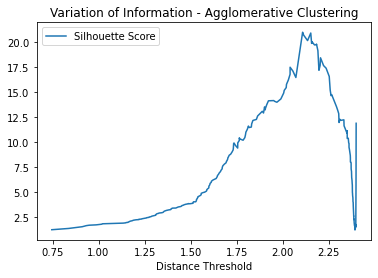

In [22]:
link = hac.linkage(varMatrix, 'single')
squareVarMatrix = squareform(varMatrix)
distance_threshold = link[:, 2][1:]
t_scores = np.array([])
for i in distance_threshold:
  print(i)
  aClustering = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = i)
  labels = aClustering.fit_predict(squareVarMatrix)
  sil_samples = silhouette_samples(squareVarMatrix, labels, metric = 'precomputed')
  t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
aClust_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Distance Threshold':distance_threshold})
aClust_t_score_vals.plot(x = 'Distance Threshold', y = 'Silhouette Score', title = 'Variation of Information - Agglomerative Clustering')

## SHAP

In [ ]:
distOpt= aClust_t_score_vals.iloc[aClust_t_score_vals['Silhouette Score'].idxmax(),1]
aClust = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = distOpt)
clustLabels = aClust.fit_predict(squareVarMatrix)



## MDA 

In [24]:
distOpt= aClust_t_score_vals.iloc[aClust_t_score_vals['Silhouette Score'].idxmax(),1]

aClust = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = distOpt)
clustLabels = aClust.fit_predict(squareVarMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
clustDict

{98: [0],
 62: [1, 2],
 5: [3, 10],
 115: [4, 11],
 27: [5, 6],
 123: [7],
 30: [8, 9],
 84: [12, 30],
 69: [13, 35],
 122: [14, 56],
 19: [15, 28],
 102: [16, 90],
 76: [17, 65],
 49: [18, 83],
 111: [19, 26],
 127: [20, 80],
 120: [21, 89],
 20: [22, 69],
 67: [23, 91],
 15: [24, 61],
 75: [25, 44],
 83: [27, 46],
 95: [29, 48, 87, 92],
 71: [31, 75],
 64: [32, 47],
 6: [33, 67, 71, 76],
 92: [34, 50],
 0: [36, 58, 117, 135],
 77: [37, 78],
 116: [38, 88],
 126: [39, 64],
 73: [40, 82],
 101: [41, 49],
 82: [42, 62],
 104: [43, 59],
 100: [45, 66],
 74: [51, 72],
 107: [52, 70],
 81: [53, 86],
 42: [54, 81],
 112: [55, 85],
 80: [57, 77],
 114: [60, 84],
 79: [63, 73],
 70: [68, 94],
 40: [74, 96],
 94: [79, 93],
 109: [95, 97],
 16: [98, 101],
 33: [99, 129],
 59: [100, 116],
 93: [102, 110],
 118: [103, 114],
 121: [104, 132],
 125: [105, 125],
 86: [106, 119],
 105: [107, 133],
 31: [108, 118],
 21: [109, 127],
 103: [111, 131],
 58: [112, 124],
 60: [113, 120],
 51: [115, 134],
 

In [25]:
scores = MDA(num_train_x, num_train_y,num_train_era, client,30, clustDict)

0 0 10
0
0 0 10
5
9 0 1
10
10 0 0


/global/homes/j/jc738/.conda/envs/numerai-dask/lib/python3.8/site-packages/distributed/worker.py:3376: UserWarning: Large object of size 4.46 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... bcb23fe05ca56')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Features sorted by their score:


In [26]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_VarInfo_AggClust.csv")


In [121]:
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_AggClust.csv',).drop('Unnamed: 0', axis = 1)
feat_score

Score            Feature
0    0.006461          [139 142]
1    0.002599          [141 146]
2    0.001380          [138 143]
3    0.001380          [147 149]
4    0.001171      [29 48 87 92]
..        ...                ...
123 -0.000171            [15 28]
124 -0.000182              [8 9]
125 -0.000278            [63 73]
126 -0.000319  [268 303 304 307]
127 -0.000354          [208 230]

[128 rows x 2 columns]

In [124]:

def MDA_clust_tune(X,Y,eras, n_components, feat_score, client, num_workers):
    futs = []
    models = []
    
    k = 0
    def fit_predict(model,x_train, y_train, x_test, y_test,eras):
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        s = score(y_test,pred, eras)
        qme = quartic_error(y_test, pred)
        return s,qme
    rf = RandomForestRegressor(criterion= 'mse',
                               random_state = 32,
                               n_estimators = 600,
                               max_depth= 50,
                               verbose = 0,
                               max_features= 2, 
                               n_jobs=-1, 
                               max_leaf_nodes= 200,
                               max_samples = .5, 
                               min_samples_leaf = 29, 
                               min_samples_split = 6 )
   
    for i in range(2,n_components):
        idx = (feat_score.sort_values('Score', ascending = False).iloc[:i,:]).apply(lambda x: ast.literal_eval(re.sub(r'(?<=[\d])\s+(?=[\d])',',', x)))
    
        #rel_col = self.feat_score[self.feat_score['Score'] > float(MDA_mean + 2*MDA_std)].Feature
        rel_col = idx.apply(lambda x: int(x.strip('[]').split("' '")[0]))
        MDA_Dataset =  pd.DataFrame(X).iloc[:,rel_col].to_numpy()

        futs.append((MDA_Dataset))
        k+=1
    k = 0
    for i in range(2,n_components):
        models.append(kfold_dask(10,futs[k], Y, eras, client, rf, num_workers))
        print(k)

        k+=1
    models = models
    return models


In [123]:
rel_col = (feat_score.sort_values('Score', ascending = False)).Feature
print(rel_col)
rel_col =rel_col.apply(lambda x: ast.literal_eval(re.sub(r'(?<=[\d])\s+(?=[\d])',',', x)))
rel_col

0              [139 142]
1              [141 146]
2              [138 143]
3              [147 149]
4          [29 48 87 92]
             ...        
123              [15 28]
124                [8 9]
125              [63 73]
126    [268 303 304 307]
127            [208 230]
Name: Feature, Length: 128, dtype: object


0                [139, 142]
1                [141, 146]
2                [138, 143]
3                [147, 149]
4          [29, 48, 87, 92]
               ...         
123                [15, 28]
124                  [8, 9]
125                [63, 73]
126    [268, 303, 304, 307]
127              [208, 230]
Name: Feature, Length: 128, dtype: object

In [29]:
s = MDA_tune(PCA_train_x,num_train_y,num_train_era,100, feat_score, client, 30)
s_ci = [x[0] for x in s]
s_mean = [x[0] for x in s_ci]
s_ci_2_5 = [x[1][0] for x in s_ci]
s_ci_97_5 = [x[1][1] for x in s_ci]
qme_ci = [x[1] for x in s]
qme_mean = [x[0] for x in qme_ci]
qme_ci_2_5 = [x[1][0] for x in qme_ci]
qme_ci_97_5 = [x[1][1] for x in qme_ci]
MDA_tune_results = pd.DataFrame({'Spearman Rank':s_mean,'S CI 2.5%': s_ci_2_5, 'S CI 97.5%': s_ci_97_5,'QME': qme_mean,'QME CI 2.5%':qme_ci_2_5, 'QME CI 97.5%':qme_ci_97_5})
MDA_tune_results.sort_values('Spearman Rank', ascending = False)

0 0 10
0
0 0 10
5
10 0 0
0
0 0 10
0
0 0 10
5
10 0 0
1
0 0 10
0
0 0 10
5
10 0 0
2
0 0 10
0
0 0 10
5
10 0 0
3
0 0 10
0
0 0 10
5
10 0 0
4
0 0 10
0
0 0 10
5
10 0 0
5
0 0 10
0
0 0 10
5
10 0 0
6
0 0 10
0
0 0 10
5
10 0 0
7
0 0 10
0
0 0 10
5
10 0 0
8
0 0 10
0
0 0 10
5
10 0 0
9
0 0 10
0
0 0 10
5
10 0 0
10
0 0 10
0
0 0 10
5
10 0 0
11
0 0 10
0
0 0 10
5
10 0 0
12
0 0 10
0
0 0 10
5
10 0 0
13
0 0 10
0
0 0 10
5
10 0 0
14
0 0 10
0
0 0 10
5
10 0 0
15
0 0 10
0
0 0 10
5
10 0 0
16
0 0 10
0
0 0 10
5
10 0 0
17
0 0 10
0
0 0 10
5
10 0 0
18
0 0 10
0
0 0 10
5
10 0 0
19
0 0 10
0
0 0 10
5
10 0 0
20
0 0 10
0
0 0 10
5
10 0 0
21
0 0 10
0
0 0 10
5
10 0 0
22
0 0 10
0
0 0 10
5
10 0 0
23
0 0 10
0
0 0 10
5
10 0 0
24
0 0 10
0
0 0 10
5
10 0 0
25
0 0 10
0
0 0 10
5
10 0 0
26
0 0 10
0
0 0 10
5
10 0 0
27
0 0 10
0
0 0 10
5
10 0 0
28
0 0 10
0
0 0 10
5
10 0 0
29
0 0 10
0
0 0 10
5
10 0 0
30
0 0 10
0
0 0 10
5
10 0 0
31
0 0 10
0
0 0 10
5
10 0 0
32
0 0 10
0
0 0 10
5
10 0 0
33
0 0 10
0
0 0 10
5
10 0 0
34
0 0 10
0
0 0 10
5
10 0 0
35
0 

Spearman Rank  S CI 2.5%  S CI 97.5%       QME  QME CI 2.5%  QME CI 97.5%
44       0.043720   0.033458    0.053981  0.026429     0.026407      0.026450
49       0.043050   0.032395    0.053704  0.026431     0.026411      0.026451
35       0.042628   0.032614    0.052642  0.026427     0.026406      0.026447
37       0.042522   0.032666    0.052378  0.026427     0.026404      0.026449
46       0.042164   0.032782    0.051546  0.026432     0.026410      0.026453
..            ...        ...         ...       ...          ...           ...
4        0.030068   0.020692    0.039444  0.026476     0.026450      0.026502
3        0.028732   0.020654    0.036810  0.026483     0.026462      0.026503
2        0.025567   0.018784    0.032350  0.026494     0.026472      0.026516
1        0.024237   0.018374    0.030099  0.026501     0.026479      0.026523
0        0.022168   0.016573    0.027762  0.026509     0.026485      0.026532

[98 rows x 6 columns]

In [47]:
rel_col = (feat_score.sort_values('Score', ascending = False).iloc[:71,:]).Feature
rel_col =rel_col.apply(lambda x: x.strip('[]')[1:][:-1].replace('\n', '').split("' '"))
print(rel_col)
MDA_Dataset =  num_x.iloc[:,rel_col]

MDA_train_x   = MDA_Dataset.iloc[:400000,:].to_numpy()
MDA_test_x = MDA_Dataset.iloc[400000:,:].to_numpy()
MDA_train_x.shape

0         [39 14]
1         [41 14]
2         [38 14]
3         [47 14]
4     [9 48 87 9]
         ...     
66          [6 9]
67        [05 12]
68        [68 22]
69          [8 9]
70        [21 12]
Name: Feature, Length: 71, dtype: object


IndexError: .iloc requires numeric indexers, got [list(['39 14']) list(['41 14']) list(['38 14']) list(['47 14'])
 list(['9 48 87 9']) list(['11 13']) list(['0 8'])
 list(['94 299 300 301 302 30']) list(['00 11']) list(['7 6'])
 list(['50 169 175 192 211 229 233 23']) list(['4 9'])
 list(['64 277 283 297 29']) list(['67 279 293 30']) list(['2 3'])
 list(['06 11']) list(['05 240 251 25']) list(['87 216 260 26'])
 list(['51 22']) list(['3 8']) list([' ']) list(['80 29'])
 list(['93 204 215 24']) list(['40 14']) list(['3 1']) list(['78 29'])
 list(['98 10']) list(['61 178 199 25']) list(['86 29']) list(['99 12'])
 list(['8 8']) list(['73 23']) list(['01 21']) list(['32 24'])
 list(['10 24']) list(['7']) list(['3 67 71 7']) list(['13 241 247 24'])
 list(['2 4']) list(['79 19']) list(['81 28']) list(['07 21'])
 list(['5 6']) list(['12 21']) list(['5 4']) list(['84 29']) list(['2 6'])
 list(['12 12']) list(['67 188 246 25']) list(['1 7']) list(['4 8'])
 list(['65 270 275 30']) list(['2']) list(['1 8']) list(['73 28'])
 list(['87 296 30']) list(['57 16']) list(['']) list(['5 9'])
 list(['15 13']) list(['04 13']) list(['5 8']) list(['7']) list(['4 1'])
 list(['4 5']) list(['2 6']) list(['6 9']) list(['05 12']) list(['68 22'])
 list(['8 9']) list(['21 12'])]

In [28]:
rel_col = feat_score.Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.apply(lambda x: x.strip('[]')[1:][:-1].replace('\n', '').split("' '")) 
clusters_train = pd.DataFrame()
clusters_test = pd.DataFrame()
num_col = 30
i = 0
for c in rel_col:
    if i>=30:
        break
    clusters_train=pd.concat([clusters_train,num_x.iloc[:400000, :][c]],axis =1)
    clusters_test=pd.concat([clusters_test,num_x.iloc[400000:,:][c]], axis=1)
    i+=1
print(clusters_train)

KeyError: "None of [Index(['39 14'], dtype='object')] are in the [columns]"

In [ ]:
rf_mean, rf_ci = kfold_dask(10, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Var. of Info. Hierarchical", 'Spearman Rank Corr by ERA Mean: rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

## K-Medoids

In [ ]:
squareVarMatrix = squareform(varMatrix)
num_clusters = range(2,200)
t_scores = np.array([])
for i in num_clusters:
  kmedoids = KMedoids(n_clusters = i, metric = 'precomputed',init = 'k-medoids++' )
  labels = kmedoids.fit_predict(squareVarMatrix)
  sil_samples = silhouette_samples(squareVarMatrix, labels)
  t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
kMed_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Number of Clusters':num_clusters})
kMed_t_score_vals.plot(x = 'Number of Clusters', y = 'Silhouette Score', title = 'Variation of Information - K-Medoids')
kMed_t_score_vals

In [ ]:
clustOpt= kMed_t_score_vals.iloc[kMed_t_score_vals['Silhouette Score'].idxmax(),1]

aClust = KMedoids(n_clusters = clustOpt, metric = 'precomputed',init = 'k-medoids++' )
clustLabels = aClust.fit_predict(squareVarMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
clustDict

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, 60, clustDict)

In [ ]:
feat_score = feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_VarInfo_kMedoids.csv")
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_kMedoids.csv')

In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_kMedoids.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Var. of Info. K-Medoids", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# HDBSCAN Clustering

In [ ]:
squareVarMatrix = squareform(varMatrix)
clust = range(2,7)
t_scores = np.array([])
for c in clust:
      print(type(c))
      dbscan = hdbscan.HDBSCAN(min_cluster_size=c, metric = 'precomputed', n_jobs = -1)
      labels =dbscan.fit_predict(squareVarMatrix)
      sil_samples = silhouette_samples(squareVarMatrix, labels)
      t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
dbscan_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Min Cluster Size' :clust})
dbscan_t_score_vals.plot(x = 'Min Cluster Size', y = 'Silhouette Score', title = 'Var of Info - HDBSCAN')
dbscan_t_score_vals

In [ ]:
clustOpt= dbscan_t_score_vals.iloc[dbscan_t_score_vals['Silhouette Score'].idxmax(),1]
aClust = hdbscan.HDBSCAN(min_cluster_size=int(clustOpt), metric = 'precomputed', n_jobs = -1)
clustLabels = aClust.fit_predict(squareVarMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y, num_train_era, client, clustDict. 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score.to_csv("MDA_Feature_Clustering_VarInfo_dbscan.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_dbscan.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train,num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Var. of Info. HDBSCAN", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# Maximal Correlation

## Distance Matrix Calculation

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [1]:
from ace import model # https://pypi.org/project/ace/
#------------------------------------------------------------------------------
def max_correlation(x,y):
  # Get max correlation using ace package
  # https://mlfinlab.readthedocs.io/en/latest/implementations/codependence.html 
    with HiddenPrints():
        ace_model=model.Model()

        ace_model.build_model_from_xy([x],y)
        val = 1-np.corrcoef(ace_model.ace.x_transforms[0], ace_model.ace.y_transform)[0][1]
    return val

In [ ]:
maxCorrMatrix = pairwise(num_cluster_x.T, max_correlation)


In [ ]:
while(True):
    complete = 0
    error = 0
    pending = 0
    for i in range(310):

        for j in range(i,310):
            if maxCorrMatrix[i][j] == 0:
                complete+=1
            elif maxCorrMatrix[i][j].status == 'finished':
                complete += 1
            elif maxCorrMatrix[i][j].status == 'error':
                error+=1
            else:
                pending +=1
    print(complete, error,pending)
    time.sleep(30)

In [ ]:

d_matrix = [[x.result() if x != None and x!= 0 else x for x in k] for k in maxCorrMatrix]
print(d_matrix)
pd.DataFrame(d_matrix).to_csv( 'maxCorr_pairwise_matrix')

In [ ]:
maxCorrMatrix = pd.read_csv('maxCorr_pairwise_matrix').drop('Unnamed: 0', axis = 1)
maxCorrMatrix = maxCorrMatrix.to_numpy()

In [ ]:
single = pd.DataFrame({'Distance':squareform(maxCorrMatrix)})
maxCorr_idx = single.sort_values('Distance').index

In [ ]:
squareform(maxCorrMatrix)[distCorr_idx]

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(squareform(squareform(maxCorrMatrix)[distCorr_idx]), cmap = 'hot')
plt.colorbar()

plt.savefig('MaxCorr+DistCorrRankDistanceMatrix2d.pdf')


In [ ]:
maxCorrMatrix = squareform(maxCorrMatrix)
maxCorrMatrix = np.sort(maxCorrMatrix)
maxCorrMatrix=squareform(maxCorrMatrix)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111, projection='3d')
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])

# Create meshgrid
X, Y = np.meshgrid(np.linspace(0, 310, len(maxCorrMatrix)), np.linspace(0, 310, len(maxCorrMatrix)))
plot = ax.plot_surface(X=X, Y=Y, Z=maxCorrMatrix, cmap='hot', vmin=0, vmax=1)
ax.view_init(elev=20, azim=280)
ax.dist=11
cbar = fig.colorbar(plot, ax=ax, shrink=0.6)
cbar.set_ticks(np.arange(11)/10)
cbar.set_ticklabels((np.arange(11)/10))
plt.savefig('MaxCorrDistanceMatrix.pdf')


## Agglomerative Clustering

In [ ]:

link = hac.linkage (squareform(maxCorrMatrix), 'single')
squareMaxCorrMatrix = (maxCorrMatrix)
distance_threshold = link[:, 2][1:]
t_scores = np.array([])
for i in distance_threshold:
  aClustering = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = i)
  labels = aClustering.fit_predict(squareMaxCorrMatrix)
  sil_samples = silhouette_samples(squareMaxCorrMatrix, labels, metric = 'precomputed')
  t_scores = np.append(t_scores,np.mean(sil_samples)/np.var(sil_samples))
aClust_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Distance Threshold':distance_threshold})
aClust_t_score_vals.plot(x = 'Distance Threshold', y = 'Silhouette Score', title = 'Maximal Correlation - Agglomerative Clustering')
aClust_t_score_vals

In [ ]:
distOpt= aClust_t_score_vals.iloc[aClust_t_score_vals['Silhouette Score'][1:].idxmax(),1]
aClust = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = distOpt)
clustLabels = aClust.fit_predict(squareMaxCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_MaxCorr_AggClust.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_MaxCorr_AggClust.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Maximal Corr. Hierarchical", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

## K-Medoids

In [ ]:
squareMaxCorrMatrix = maxCorrMatrix
num_clusters = range(2,310)
t_scores = np.array([])
for i in num_clusters:
  kmedoids = KMedoids(n_clusters = i, metric = 'precomputed',init = 'k-medoids++' )
  labels = kmedoids.fit_predict(squareMaxCorrMatrix)
  sil_samples = silhouette_samples(squareMaxCorrMatrix, labels)
  t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
kMeds_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Number of Clusters':num_clusters})
kMeds_t_score_vals.plot(x = 'Number of Clusters', y = 'Silhouette Score', title = 'Maximal Correlation - K-Medoids')
kMeds_t_score_vals

In [ ]:
clustOpt= kMeds_t_score_vals.iloc[kMeds_t_score_vals['Silhouette Score'].idxmax(),1]

aClust = KMedoids(n_clusters = clustOpt, metric = 'precomputed',init = 'k-medoids++' )
clustLabels = aClust.fit_predict(squareMaxCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_MaxCorr_kMeds.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_MaxCorr_kMeds.csv')
feat_score

In [ ]:
rel_col = feat_score
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train,num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Maximal Corr. K-Medoids", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# HDBSCAN Clustering

In [ ]:
squareMaxCorrMatrix = maxCorrMatrix
clust = range(5,20)
t_scores = np.array([])
for c in clust:
      print(type(c))
      dbscan = hdbscan.HDBSCAN(min_cluster_size=c, metric = 'precomputed', n_jobs = -1)
      labels =dbscan.fit_predict(squareMaxCorrMatrix)
      sil_samples = silhouette_samples(squareMaxCorrMatrix, labels)
      t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
dbscan_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Min Cluster Size' :clust})
dbscan_t_score_vals.plot(x = 'Min Cluster Size', y = 'Silhouette Score', title = 'Maximal Correlation - HDBSCAN')
dbscan_t_score_vals

In [ ]:
clustOpt= dbscan_t_score_vals.iloc[dbscan_t_score_vals['Silhouette Score'].idxmax(),1]
aClust = hdbscan.HDBSCAN(min_cluster_size=int(clustOpt), metric = 'precomputed', n_jobs = -1)
clustLabels = aClust.fit_predict(squareMaxCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_MaxCorr_dbscan.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_MaxCorr_dbscan.csv')
feat_score

In [ ]:
rel_col = feat_score
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Maximal Corr. HDBSCAN", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# Distance Correlation

In [ ]:
def distcorr(Xval, Yval, pval=False, nruns=500):
    """ Compute the distance correlation function, returning the p-value.
    Based on Satra/distcorr.py (gist aa3d19a12b74e9ab7941)
    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    (0.76267624241686671, 0.266)
    """
    X = np.atleast_1d(Xval)
    Y = np.atleast_1d(Yval)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / float(n * n)
    dcov2_xx = (A * A).sum() / float(n * n)
    dcov2_yy = (B * B).sum() / float(n * n)
    dcor = np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))

    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Yval)
            np.random.shuffle(Y_r)
            if distcorr(Xval, Y_r, pval=False) > dcor:
                greater += 1
        return (dcor, greater / float(nruns))
    else:
        
        return 1-dcor

In [ ]:
distCorrMatrix = pairwise(num_cluster_x.T,distcorr)
distCorrMatrix

In [ ]:
while(True):
    complete = 0
    error = 0
    pending = 0
    for i in range(310): 
        for j in range(i,310):
            if distCorrMatrix[i][j] == 0:
                complete+=1
            elif distCorrMatrix[i][j].status == 'finished':
                complete += 1
            elif distCorrMatrix[i][j].status == 'error':
                error+=1
            else:
                pending +=1
    print(complete, error,pending)
    if pending ==0:
        break
    time.sleep(30)

In [ ]:

d_matrix = [[x.result()[0] if x != None and x!= 0 else x for x in k] for k in distCorrMatrix]
print(d_matrix)
pd.DataFrame(d_matrix).to_csv( 'distcorr_pairwise_matrix')

In [ ]:
distCorrMatrix = pd.read_csv('distcorr_pairwise_matrix').drop('Unnamed: 0', axis = 1)
distCorrMatrix = distCorrMatrix.to_numpy()

In [ ]:
single = pd.DataFrame({'Distance':squareform(distCorrMatrix)})
distCorr_idx = single.sort_values('Distance').index

In [ ]:
squareform(distCorrMatrix)[maxCorr_idx]

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(squareform(squareform(distCorrMatrix)[maxCorr_idx]), cmap = 'hot')
plt.colorbar()

plt.savefig('DistCorr+MaxCorrRankDistanceMatrix2d.pdf')


In [ ]:
distCorrMatrix = squareform(distCorrMatrix)
distCorrMatrix = np.sort(distCorrMatrix)
distCorrMatrix=squareform(distCorrMatrix)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111, projection='3d')
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])

# Create meshgrid
X, Y = np.meshgrid(np.linspace(0, 310, len(distCorrMatrix)), np.linspace(0, 310, len(distCorrMatrix)))
plot = ax.plot_surface(X=X, Y=Y, Z=distCorrMatrix, cmap='hot', vmin=0, vmax=1)
ax.view_init(elev=20, azim=250)
ax.dist=11
cbar = fig.colorbar(plot, ax=ax, shrink=0.6)
cbar.set_ticks(np.arange(11)/10)
cbar.set_ticklabels((np.arange(11)/10))
plt.savefig('DistCorrMatrix.pdf')


## Agglomerative Clustering

In [ ]:
link = hac.linkage(squareform(distCorrMatrix), 'single')
squareDistCorrMatrix = (distCorrMatrix)
distance_threshold = link[:, 2][1:]
t_scores = np.array([])
for i in distance_threshold:
  aClustering = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = i)
  labels = aClustering.fit_predict(squareDistCorrMatrix)
  sil_samples = silhouette_samples(squareDistCorrMatrix, labels, metric = 'precomputed')
  t_scores = np.append(t_scores,np.mean(sil_samples)/np.var(sil_samples))
aClust_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Distance Threshold':distance_threshold})
aClust_t_score_vals.plot(x = 'Distance Threshold', y = 'Silhouette Score', title = 'Distance Correlation - Agglomerative Clustering')
aClust_t_score_vals.head(10)

In [ ]:
distOpt= aClust_t_score_vals.iloc[aClust_t_score_vals['Silhouette Score'].idxmax(),1]
aClust = AgglomerativeClustering(n_clusters = None, affinity = 'precomputed', linkage = 'single', distance_threshold = distOpt)
clustLabels = aClust.fit_predict(squareDistCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60 )

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_DistCorr_AClust.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_DistCorr_AClust.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Dist. Corr. Hierarchical", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

## K-Medoids Clustering

In [ ]:
squareDistCorrMatrix = (distCorrMatrix)
num_clusters = range(2,310)
t_scores = np.array([])
for i in num_clusters:
  kmedoids = KMedoids(n_clusters = i, metric = 'precomputed',init = 'k-medoids++' )
  labels = kmedoids.fit_predict(squareDistCorrMatrix)
  sil_samples = silhouette_samples(squareDistCorrMatrix, labels)
  t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
kMeds_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Number of Clusters':num_clusters})
kMeds_t_score_vals.plot(x = 'Number of Clusters', y = 'Silhouette Score', title = 'Distance Correlation - K-Medoids')
kMeds_t_score_vals

In [ ]:
clustOpt= kMeds_t_score_vals.iloc[kMeds_t_score_vals['Silhouette Score'].idxmax(),1]

aClust = KMedoids(n_clusters = clustOpt, metric = 'precomputed',init = 'k-medoids++' )
clustLabels = aClust.fit_predict(squareDistCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score.to_csv("MDA_Feature_Clustering_DistCorr_KMeds.csv")


In [ ]:
feat_score = pd.read_csv('"MDA_Feature_Clustering_DistCorr_Kmeds.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train,num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Dist. Corr. K-Medoids", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# HDBSCAN Clustering

In [ ]:
squareDistCorrMatrix = distCorrMatrix
clust = range(2,5)
t_scores = np.array([])
for c in clust:
      print(type(c))
      dbscan = hdbscan.HDBSCAN(min_cluster_size=c, metric = 'precomputed', n_jobs = -1)
      labels =dbscan.fit_predict(squareDistCorrMatrix)
      sil_samples = silhouette_samples(squareDistCorrMatrix, labels)
      t_scores = np.append(t_scores,(np.mean(sil_samples)/np.var(sil_samples)))
dbscan_t_score_vals = pd.DataFrame({'Silhouette Score':t_scores,'Min Cluster Size' :clust})
dbscan_t_score_vals.plot(x = 'Min Cluster Size', y = 'Silhouette Score', title = 'Distance Correlation - HDBSCAN')
dbscan_t_score_vals

In [ ]:
clustOpt= dbscan_t_score_vals.iloc[dbscan_t_score_vals['Silhouette Score'].idxmax(),1]
aClust = hdbscan.HDBSCAN(min_cluster_size=int(clustOpt), metric = 'precomputed', n_jobs = -1)
clustLabels = aClust.fit_predict(squareDistCorrMatrix)
names = pd.DataFrame(num_train_x).columns.values
clustNames = zip(clustLabels,names)
clustDict = dict()
for c, n in clustNames:
  if c not in clustDict.keys():
    clustDict[c] = [n]
  else:
    clustDict[c].append(n)
len(clustDict)

## MDA

In [ ]:
scores = MDA(num_train_x, num_train_y,num_train_era, client, clustDict, 60)

In [ ]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score.to_csv("MDA_Feature_Clustering_DistCorr_HDBSCAN.csv")


In [ ]:
feat_score = pd.read_csv('MDA_Feature_Clustering_DistCorr_HDBSCAN.csv')
feat_score

In [ ]:
rel_col = feat_score.iloc[0].Feature
#MaxCorrMDA = pd.DataFrame(num_train_x)[rel_col]
rel_col = rel_col.strip('[]')[1:][:-1].replace('\n', '').split("' '")
mda_train = num_x.iloc[:400000, :][rel_col]
mda_test = num_x.iloc[400000:,:][rel_col]

In [ ]:
rf_mean, rf_ci = kfold_dask(100, mda_train, num_train_y,num_train_era,client, rf_hp, 60)
redux_race = redux_race.append({"Reduction Technique": "FC-Dist. Corr. HDBSCAN", 'Spearman Rank Corr by ERA Mean': rf_mean,'Confidence Interval 2.5%': rf_ci[0],'Confidence Interval 97.5%':rf_ci[1]}, ignore_index = True)
redux_race

# DNN for regression


In [ ]:
import horovod.tensorflow as hvd

In [ ]:
def nn_score(y_true, y_pred):
    
    return tfp.stats.correlation(y_true, y_pred)

In [ ]:

def evaluate_model(trainX, trainy, testx, testy, batch_size, epochs,verbose, model_weights = None):
  #look into automatic keras neural network layer choice
  #SVM
    

      verbose, epochs, batch_size = verbose, epochs, batch_size
      n_timesteps, n_features, n_outputs = 80, 1, 1

      #trainX = trainX.reshape(trainX.shape[0], trainX.shape[1],1)
      #testX = testX.reshape(testX.shape[0], testX.shape[1],1)
      
      model = Sequential()
      model.add(Dense(310, activation='relu', batch_size = (trainX.shape[0], trainX.shape[1])))
      #expand to nodes in a few layers.
      model.add(Dropout(0.2))
      model.add(Dense(200, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(150, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(100, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(50, activation = 'relu', kernel_constraint = maxnorm(4)))

      model.add(Dense(70, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(90, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(100, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(150, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dense(200, activation = 'relu', kernel_constraint = maxnorm(4)))
      model.add(Dropout(0.2))
  
      model.add(Dense(1, activation = 'relu'))
      opt = optimizers.adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1)

             
      # if model_weights != None:

      #   model.load_weights("/content/drive/My Drive/Stock Price Prediction Research/weights_fact.best.hdf5")
      #   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      #else:
      model.compile(loss='mse', optimizer=opt, metrics=['acc'])
      # fit network
      #filepath="/content/drive/My Drive/Stock Price Prediction Research/weights_fact.best.hdf5"
      #checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
      #callbacks_list = [checkpoint]

      model.fit(trainX, trainy,validation_split = .1, epochs=epochs, batch_size=batch_size, verbose=verbose,shuffle =  True,use_multiprocessing =True)
      # evaluate model"
      pred = model.predict(testx, batch_size = batch_size, verbose = 0)
      weights = True
      spearman_rank = score(testy, pred)
      return model, pred, spearman_rank

In [ ]:
model, predictions = evaluate_model(num_train_x, num_train_y, num_test_x, num_test_y, 2**13,1000, 2)

In [ ]:
plt.title('Loss - 2 dropout layer at .4, Learning Rate .1')

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.legend()

In [ ]:
model.history.history